# <div style="text-align: center;">Project 3: Classification</div>

## **1. Problem Description (Business Understanding)**

The COVID-19 pandemic exposed deep and varied vulnerabilities across counties in Texas and the United States. As experts warn of the possibility of future pandemics caused by new viruses, it is crucial to learn from our past response to guide early interventions that could save lives and minimize disruption.

This project aims to develop a classification model to identify Texas counties as high, medium, or low risk of being severely affected by a future pandemic. By learning from patterns observed during COVID-19 and leveraging county-level data—such as demographics, socioeconomic status, health infrastructure, and mobility—our model will provide actionable insights to support DSHS in preparedness planning and emergency response.

Research has consistently shown that disparities in health outcomes during COVID-19 were influenced by a complex interplay of socioeconomic, demographic, and behavioral factors (CDC, 2021; Benitez et al., 2020). Relevant predictive features include income inequality, poverty rates, commuting patterns, remote work capacity, food insecurity, and access to healthcare (Raifman & Raifman, 2020). Identifying which of these variables most strongly correlate with adverse outcomes will help DSHS develop data-driven strategies for prevention and targeted resource allocation.

**Primary Stakeholder:**
- **Texas Department of State Health Services (DSHS)** — responsible for managing pandemic response at the state level, allocating resources, and coordinating public health policy. DSHS will use the model to:
  - Prioritize counties for testing, vaccination, and communication campaigns
  - Implement tailored early interventions (e.g., mask mandates or closures)
  - Monitor risk levels over time using updated data

**Research Questions:**
1. Which counties in Texas are most at risk of severe outcomes in a future pandemic based on social and economic indicators?
2. Can we classify counties into low, medium, or high risk with high accuracy using historical COVID-19 data and population-level features?
3. Which features are most predictive of pandemic risk, and how can this inform DSHS policy and intervention strategies?

This project is important because it turns raw COVID-19 outcome and population data into actionable intelligence for a key public health agency. A well-performing model will help DSHS not only plan short-term interventions but also address longer-term structural vulnerabilities before the next public health crisis (Bertsimas et al., 2020).

We will use county-level data on COVID-19 outcomes, demographic characteristics, social determinants of health, and healthcare infrastructure to train and evaluate our models.

### References (APA Style)

- Benitez, J. A., Courtemanche, C., & Yelowitz, A. (2020). *Racial and ethnic disparities in COVID-19: Evidence from six large cities*. National Bureau of Economic Research. https://doi.org/10.3386/w27592  
- Bertsimas, D., Boussioux, L., Cory-Wright, R., Delarue, A., Digalakis Jr, V., & Lami, O. (2020). *From predictions to prescriptions: A data-driven response to COVID-19*. Health Care Management Science, 24(2), 1–22. https://doi.org/10.1007/s10729-020-09549-8  
- Centers for Disease Control and Prevention (CDC). (2021). *COVID-19 racial and ethnic health disparities*. https://www.cdc.gov/coronavirus/2019-ncov/community/health-equity/race-ethnicity.html  
- Raifman, M. A., & Raifman, J. R. (2020). *Disparities in the population at risk of severe illness from COVID-19 by race/ethnicity and income*. American Journal of Preventive Medicine, 59(1), 137–139. https://doi.org/10.1016/j.amepre.2020.04.003  

In [1]:
# Define all the required packages
packages <- c(
    "tidyverse", "basemodels", "FSelector", "ggrepel", 
    "ggcorrplot", "DT", "gridExtra", "lattice", "nnet",
    "sf", "modeest", "factoextra", "kableExtra", "reshape2",
    "knitr", "caret", "car", "lubridate", "tigris",
    "mclust", "dbscan", "palmerpenguins", "party", "pROC", "rpart", 
    "rpart.plot", "rJava", "doParallel", "corrplot", "lars",
    "patchwork"
    # "doMC", # COMMENTING OUT BC IT DOES NOT WORK FOR MY VERSION; UNCOMMENT OTHERWISE  
)

# Install any that aren't already installed
installed <- packages %in% rownames(installed.packages())
if (any(!installed)) {
  install.packages(packages[!installed])
}

In [2]:
# List of required libraries
libs <- c(
  "tidyverse", "basemodels", "FSelector", "ggrepel", 
    "ggcorrplot", "DT", "gridExtra", "lattice", "nnet",
    "sf", "modeest", "factoextra", "kableExtra", "reshape2",
    "knitr", "caret", "car", "lubridate", "tigris",
    "mclust", "dbscan", "palmerpenguins", "party", "pROC", "rpart", 
    "rpart.plot", "rJava", "doParallel", "corrplot", "lars",
    "patchwork"
    #"doMC", # COMMENTING OUT BC IT DOES NOT WORK FOR MY VERSION; UNCOMMENT OTHERWISE
    
)

# Load each library
invisible(lapply(libs, library, character.only = TRUE))

Warning message:
"package 'tidyverse' was built under R version 4.4.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'basemodels' was built under R version 4.4.3"
Warning message:
"package 'FSelector' was built under R version 4.4.3"
Warning message:
"package 'ggcorrplot' was built under R version 4.4.3"
Warning message:
"package 'DT' was built under R version 4.4.3"
Warning message:
"package 'gridExtra' was built under R version 4.4.3"

Attaching package: 'gridExtra'


The following object 

In [3]:
# Define base directory
base_dir <- "../../../../COVID-19"
#base_dir <- "C:/Users/leona/OneDrive/CSMS/Data Mining (CS7331)/Projects/Project 1/COVID-19/"
# base_dir <- "/Users/salissa/Desktop/Data Mining/Datasets/COVID-19"

# Use file.path() for better compatibility
global_mobility_path <- file.path(base_dir, "Global_Mobility_Report.csv")
covid_cases_census_path <- file.path(base_dir, "c19_census.csv")
covid_cases_tx_path <- file.path(base_dir, "c19_tx.csv")

In [4]:
# Custom function to read CSV files
read_data <- function(file_path, dataset_name) {
  if (file.exists(file_path)) {
    cat(paste0("\n--- Loading ", dataset_name, " ---\n"))
    # Suppress col_type messages
    return(read_csv(file_path, show_col_types = FALSE))
  } else {
    stop(paste0("Error: File not found -> ", file_path))
  }
}

# Load datasets
global_mobility <- read_data(global_mobility_path, "Global Mobility Data")
c19_census <- read_data(covid_cases_census_path, "COVID-19 Cases and Census Data")
covid_cases_tx <- read_data(covid_cases_tx_path, "COVID-19 Cases for Texas")

cat("\n--- All datasets successfully loaded! ---\n")


--- Loading Global Mobility Data ---

--- Loading COVID-19 Cases and Census Data ---

--- Loading COVID-19 Cases for Texas ---

--- All datasets successfully loaded! ---


### 2. Data Preparation [40 points]
Define your classes (e.g., more than x corona-related cases or fatalities per population of 10000 per week). Explain why you defined the classes this way. You should look at the data to answer this question. [10]
Combine files as needed to prepare the data set for classification. You will need a single table with a class attribute to learn a model. [10]
Identify predictive features, create additional features, and deal with missing data (for classification models that cannot handle missing data). [20]

In [5]:
# Convert to tibble (safe even if it already is)
c19_census <- as_tibble(c19_census)

In [6]:
# Randomly display 10 rows
c19_census %>%
  sample_n(10)

county_fips_code,county_name,state,state_fips_code,date,confirmed_cases,deaths,geo_id,nonfamily_households,family_households,⋯,speak_only_english_at_home,speak_spanish_at_home,speak_spanish_at_home_low_english,pop_15_and_over,pop_never_married,pop_now_married,pop_separated,pop_widowed,pop_divorced,do_date
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>
28011,Bolivar County,MS,28,2021-01-19,3997,109,28011,4472,7795,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,20132017
13119,Franklin County,GA,13,2021-01-19,1975,25,13119,2506,5816,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,20132017
13169,Jones County,GA,13,2021-01-19,1267,23,13169,2604,7868,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,20132017
01087,Macon County,AL,01,2021-01-19,1168,35,01087,3238,4614,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,20132017
21085,Grayson County,KY,21,2021-01-19,1564,37,21085,2724,6870,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,20132017
56035,Sublette County,WY,56,2021-01-19,634,7,56035,1022,2175,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,20132017
05073,Lafayette County,AR,05,2021-01-19,396,7,05073,1032,1828,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,20132017
12063,Jackson County,FL,12,2021-01-19,5360,126,12063,5839,11202,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,20132017
20165,Rush County,KS,20,2021-01-19,400,0,20165,582,850,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,20132017


In [7]:
# View of data
glimpse(c19_census)

Rows: 3,142
Columns: 259
$ county_fips_code                                               <chr> "50009"…
$ county_name                                                    <chr> "Essex …
$ state                                                          <chr> "VT", "…
$ state_fips_code                                                <chr> "50", "…
$ date                                                           <date> 2021-0…
$ confirmed_cases                                                <dbl> 111, 36…
$ deaths                                                         <dbl> 0, 78, …
$ geo_id                                                         <chr> "50009"…
$ nonfamily_households                                           <dbl> 994, 27…
$ family_households                                              <dbl> 1726, 3…
$ median_year_structure_built                                    <dbl> 1973, 1…
$ rent_burden_not_computed                                       <dbl> 64, 115…
$ rent_over_50_

### 2.1 Combine Files to Create Unified Dataset

We created a unified dataset by merging COVID-19 case data with U.S. Census data. The dataset was filtered to include only Texas counties (`state == "TX"`), and we selected variables based on public health research and previous clustering analysis (Project 2).

The following variables were retained as predictors:

- **cases_per_100k**, **deaths_per_100k**: Indicators of overall pandemic impact
- **death_per_case**: A derived severity ratio calculated as deaths divided by confirmed cases; this captures the local fatality rate
- **poverty**, **median_income**, **income_per_capita**: Measures of economic hardship
- **pct_on_food_stamps**, **commuters_by_public_transportation**, **pct_work_from_home**: Reflect resource access and mobility limitations
- **total_pop**: Used to normalize count variables

We engineered the `death_per_case` variable to better capture differences in local health outcomes, which may be associated with healthcare access or population vulnerability. Additionally, a class attribute `risk_level` was created using the distribution of `cases_per_100k`, enabling supervised classification of counties into low, medium, and high risk.

In [8]:
# Filter variables, adjust data types
covid_census_tx <- c19_census %>%
  filter(state == "TX") %>%
  mutate(
    county = as.factor(county_name),
    cases_per_100k = confirmed_cases / total_pop * 100000,
    deaths_per_100k = deaths / total_pop * 100000,
    death_per_case = deaths / confirmed_cases,
    pct_work_from_home = worked_at_home / civilian_labor_force * 100,
    pct_on_food_stamps = households_public_asst_or_food_stamps / households * 100
  ) %>%
  select(
    county,
    cases_per_100k,
    deaths_per_100k,
    death_per_case,
    poverty,
    median_income,
    pct_on_food_stamps,
    commuters_by_public_transportation,
    pct_work_from_home,
    income_per_capita,
    total_pop
  ) %>%
  drop_na()

In [9]:
covid_census_tx %>%
    head()

county,cases_per_100k,deaths_per_100k,death_per_case,poverty,median_income,pct_on_food_stamps,commuters_by_public_transportation,pct_work_from_home,income_per_capita,total_pop
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Hansford County,12165.582,307.3030,0.02526003,1017,40678,6.548857,9,0.7234727,21989,5532
Stonewall County,12361.624,369.0037,0.02985075,143,46786,8.951965,0,1.5452539,28063,1084
Cochran County,7366.985,409.2769,0.05555556,717,37500,16.200000,7,1.7801858,19195,2932
Crockett County,12304.484,338.8947,0.02754237,787,52310,10.134656,0,3.3783784,23296,3836
McCulloch County,5733.579,147.3297,0.02569593,1296,42367,19.090041,2,1.6137566,23398,8145
Sherman County,3847.408,358.6567,0.09322034,448,54961,2.163688,7,2.3341523,25358,3067


In [10]:
# Verify column name change
colnames(covid_census_tx)

[1] "county"                             "cases_per_100k"                    
 [3] "deaths_per_100k"                    "death_per_case"                    
 [5] "poverty"                            "median_income"                     
 [7] "pct_on_food_stamps"                 "commuters_by_public_transportation"
 [9] "pct_work_from_home"                 "income_per_capita"                 
[11] "total_pop"

In [11]:
# View filtered variables
glimpse(covid_census_tx)

Rows: 254
Columns: 11
$ county                             <fct> Hansford County, Stonewall County, …
$ cases_per_100k                     <dbl> 12165.582, 12361.624, 7366.985, 123…
$ deaths_per_100k                    <dbl> 307.30296, 369.00369, 409.27694, 33…
$ death_per_case                     <dbl> 0.025260030, 0.029850746, 0.0555555…
$ poverty                            <dbl> 1017, 143, 717, 787, 1296, 448, 10,…
$ median_income                      <dbl> 40678, 46786, 37500, 52310, 42367, …
$ pct_on_food_stamps                 <dbl> 6.548857, 8.951965, 16.200000, 10.1…
$ commuters_by_public_transportation <dbl> 9, 0, 7, 0, 2, 7, 0, 0, 12, 2, 0, 0…
$ pct_work_from_home                 <dbl> 0.7234727, 1.5452539, 1.7801858, 3.…
$ income_per_capita                  <dbl> 21989, 28063, 19195, 23296, 23398, …
$ total_pop                          <dbl> 5532, 1084, 2932, 3836, 8145, 3067,…


In [12]:
# Check for missing values
missing_values <- covid_census_tx %>%
  summarize(across(everything(), ~ sum(is.na(.)))) %>%
  pivot_longer(cols = everything(), names_to = "column", values_to = "missing_count") %>%
  mutate(missing_pct = (missing_count / nrow(covid_census_tx)) * 100)

# View missing values summary
print(missing_values)

# A tibble: 11 × 3
   column                             missing_count missing_pct
   <chr>                                      <int>       <dbl>
 1 county                                         0           0
 2 cases_per_100k                                 0           0
 3 deaths_per_100k                                0           0
 4 death_per_case                                 0           0
 5 poverty                                        0           0
 6 median_income                                  0           0
 7 pct_on_food_stamps                             0           0
 8 commuters_by_public_transportation             0           0
 9 pct_work_from_home                             0           0
10 income_per_capita                              0           0
11 total_pop                                      0           0


In [13]:
# Remove missing values (based on variables used in analysis)
covid_census_tx <- covid_census_tx %>%
  drop_na(
    county,
    cases_per_100k,
    deaths_per_100k,
    death_per_case,
    poverty,
    median_income,
    pct_on_food_stamps,
    commuters_by_public_transportation,
    pct_work_from_home,
    income_per_capita,
    total_pop
  )

# Check how much data is left
cat("Remaining rows after missing value removal:", nrow(covid_census_tx), "\n")

# Check summary statistics of the cleaned dataset
summary(covid_census_tx)

Remaining rows after missing value removal: 254 


              county    cases_per_100k  deaths_per_100k death_per_case   
 Anderson County :  1   Min.   : 1351   Min.   :  0.0   Min.   :0.00000  
 Andrews County  :  1   1st Qu.: 5896   1st Qu.:119.9   1st Qu.:0.01482  
 Angelina County :  1   Median : 7394   Median :172.7   Median :0.02262  
 Aransas County  :  1   Mean   : 7799   Mean   :185.5   Mean   :0.02469  
 Archer County   :  1   3rd Qu.: 9410   3rd Qu.:239.4   3rd Qu.:0.03087  
 Armstrong County:  1   Max.   :18290   Max.   :628.4   Max.   :0.09322  
 (Other)         :248                                                    
    poverty       median_income   pct_on_food_stamps
 Min.   :    10   Min.   :24794   Min.   : 0.000    
 1st Qu.:  1084   1st Qu.:42327   1st Qu.: 9.099    
 Median :  2739   Median :48311   Median :12.966    
 Mean   : 16895   Mean   :49894   Mean   :13.442    
 3rd Qu.:  7554   3rd Qu.:55741   3rd Qu.:16.242    
 Max.   :751985   Max.   :93645   Max.   :42.849    
                                     

In [14]:
# Identify duplicate rows
duplicates <- covid_census_tx %>%
  filter(duplicated(.))

# Count duplicate rows
num_duplicates <- nrow(duplicates)

# View duplicates
cat("Number of duplicate rows:", num_duplicates, "\n")

# Optionally display them if needed
if (num_duplicates > 0) {
  print(duplicates)
}

Number of duplicate rows: 0 


In [15]:
# Define function to count outliers using IQR
count_outliers <- function(x) {
  Q1 <- quantile(x, 0.25, na.rm = TRUE)
  Q3 <- quantile(x, 0.75, na.rm = TRUE)
  IQR_value <- Q3 - Q1
  sum(x < (Q1 - 1.5 * IQR_value) | x > (Q3 + 1.5 * IQR_value), na.rm = TRUE)
}

# Apply to all numerical variables used in clustering (excluding 'county')
outlier_summary <- covid_census_tx %>%
  select(-county) %>%
  summarize(across(everything(), count_outliers, .names = "{.col}_outliers")) %>%
  pivot_longer(cols = everything(), names_to = "Variable", values_to = "Outlier_Count")

# Display outlier summary
print(outlier_summary, width = Inf)

# A tibble: 10 × 2
   Variable                                    Outlier_Count
   <chr>                                               <int>
 1 cases_per_100k_outliers                                 3
 2 deaths_per_100k_outliers                                5
 3 death_per_case_outliers                                 9
 4 poverty_outliers                                       31
 5 median_income_outliers                                 10
 6 pct_on_food_stamps_outliers                            11
 7 commuters_by_public_transportation_outliers            39
 8 pct_work_from_home_outliers                            15
 9 income_per_capita_outliers                              9
10 total_pop_outliers                                     39


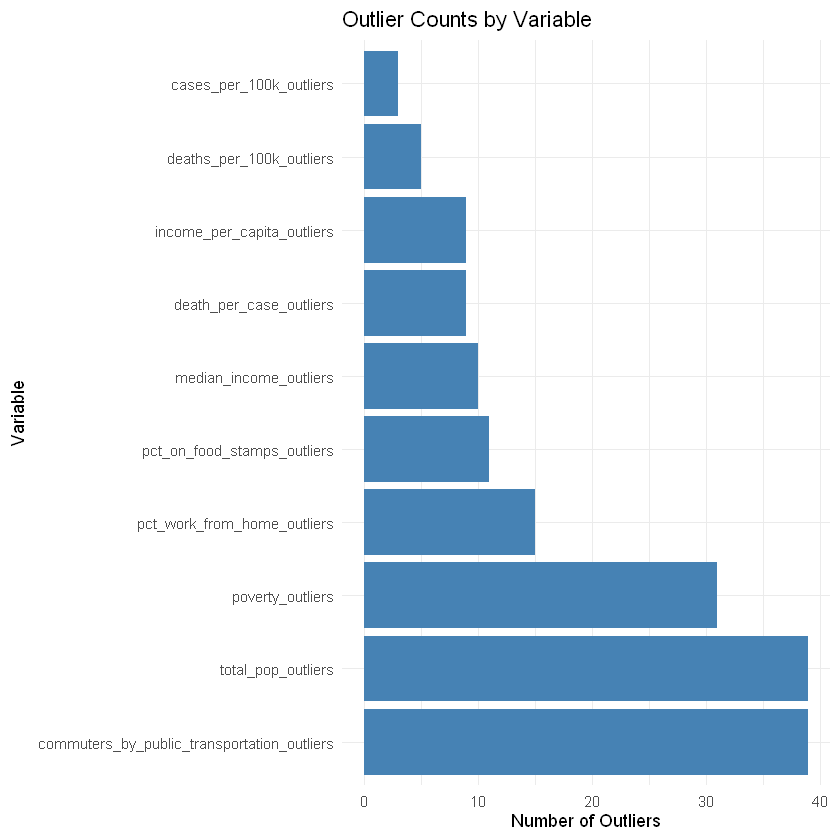

In [16]:
ggplot(outlier_summary, aes(x = reorder(Variable, -Outlier_Count), y = Outlier_Count)) +
  geom_col(fill = "steelblue") +
  labs(title = "Outlier Counts by Variable", x = "Variable", y = "Number of Outliers") +
  theme_minimal() +
  coord_flip()

In [17]:
# Custom function to check if value is NOT an outlier using IQR
is_not_outlier <- function(x) {
  Q1 <- quantile(x, 0.25, na.rm = TRUE)
  Q3 <- quantile(x, 0.75, na.rm = TRUE)
  IQR_value <- Q3 - Q1
  x >= (Q1 - 1.5 * IQR_value) & x <= (Q3 + 1.5 * IQR_value)
}

# Remove rows containing outliers from key analysis variables
covid_census_tx_cleaned <- covid_census_tx %>%
  filter(
    is_not_outlier(cases_per_100k) &
    is_not_outlier(deaths_per_100k) &
    is_not_outlier(death_per_case) &
    is_not_outlier(total_pop) &
    is_not_outlier(median_income) &
    is_not_outlier(commuters_by_public_transportation) &
    is_not_outlier(pct_on_food_stamps) &
    is_not_outlier(pct_work_from_home) &
    is_not_outlier(poverty) &
    is_not_outlier(income_per_capita)
  )

# Calculate and display how many rows were removed
rows_removed <- nrow(covid_census_tx) - nrow(covid_census_tx_cleaned)
cat("Number of rows removed due to outliers:", rows_removed, "\n")

Number of rows removed due to outliers: 84 


In [18]:
# Stats after cleaning data
summary(covid_census_tx_cleaned)

             county    cases_per_100k  deaths_per_100k death_per_case   
 Anderson County:  1   Min.   : 2311   Min.   :  0.0   Min.   :0.00000  
 Andrews County :  1   1st Qu.: 5886   1st Qu.:125.1   1st Qu.:0.01751  
 Angelina County:  1   Median : 7198   Median :174.7   Median :0.02388  
 Aransas County :  1   Mean   : 7608   Mean   :181.4   Mean   :0.02458  
 Archer County  :  1   3rd Qu.: 9213   3rd Qu.:234.9   3rd Qu.:0.03069  
 Atascosa County:  1   Max.   :13159   Max.   :391.0   Max.   :0.05495  
 (Other)        :164                                                    
    poverty      median_income   pct_on_food_stamps
 Min.   :   10   Min.   :29104   Min.   : 0.000    
 1st Qu.: 1035   1st Qu.:42456   1st Qu.: 9.504    
 Median : 2314   Median :47854   Median :12.758    
 Mean   : 3571   Mean   :48816   Mean   :12.735    
 3rd Qu.: 5044   3rd Qu.:52996   3rd Qu.:15.732    
 Max.   :16430   Max.   :74368   Max.   :24.834    
                                                   


In [19]:
# Verify rows, columns, data types
glimpse(covid_census_tx_cleaned)

Rows: 170
Columns: 11
$ county                             <fct> Hansford County, Stonewall County, …
$ cases_per_100k                     <dbl> 12165.582, 12361.624, 12304.484, 57…
$ deaths_per_100k                    <dbl> 307.30296, 369.00369, 338.89468, 14…
$ death_per_case                     <dbl> 0.025260030, 0.029850746, 0.0275423…
$ poverty                            <dbl> 1017, 143, 787, 1296, 10, 1590, 251…
$ median_income                      <dbl> 40678, 46786, 52310, 42367, 56964, …
$ pct_on_food_stamps                 <dbl> 6.548857, 8.951965, 10.134656, 19.0…
$ commuters_by_public_transportation <dbl> 9, 0, 0, 2, 0, 12, 0, 0, 0, 34, 16,…
$ pct_work_from_home                 <dbl> 0.7234727, 1.5452539, 3.3783784, 1.…
$ income_per_capita                  <dbl> 21989, 28063, 23296, 23398, 29918, …
$ total_pop                          <dbl> 5532, 1084, 3836, 8145, 289, 12755,…


In [20]:
datatable(covid_census_tx_cleaned) %>%
  formatRound(columns = c("cases_per_100k",  "income_per_capita"), digits = 2) %>%
  formatPercentage(columns = c("pct_on_food_stamps", "pct_work_from_home"), digits = 2)

HTML widgets cannot be represented in plain text (need html)

### 2.2 Defining Classes [10 points]
To predict county-level vulnerability to a future virus similar to COVID-19, we defined three classes based on historical COVID-19 case rates per 100,000 people. This outcome reflects the severity of pandemic impact, which public health departments use to allocate resources and prioritize interventions.

**Class Definition:**

- Low Risk: ≤ 100 cases per 100k
- Medium Risk: 101–200 cases per 100k
- High Risk: > 200 cases per 100k

**Rationale:**

These thresholds align with natural breakpoints in the observed distribution of the data (see histogram in Figure X).
They offer clear, interpretable groupings useful for health policy decision-making.
Classification models benefit from roughly balanced classes, which these thresholds help achieve after inspecting the distribution.

In [21]:
# Calculate thresholds after cleaning
quantiles <- quantile(covid_census_tx_cleaned$cases_per_100k, probs = c(0.33, 0.66), na.rm = TRUE)
q1 <- quantiles[1]
q2 <- quantiles[2]

# Risk levels based on updated thresholds
covid_census_tx_cleaned <- covid_census_tx_cleaned %>%
  mutate(risk_level = case_when(
    cases_per_100k < q1 ~ "Low",
    cases_per_100k < q2 ~ "Medium",
    TRUE ~ "High"
  )) %>%
  mutate(risk_level = factor(risk_level, levels = c("Low", "Medium", "High")))

# Check class distribution 
table(covid_census_tx_cleaned$risk_level)


   Low Medium   High 
    56     56     58 

In [22]:
# Verify risk level is factor
str(covid_census_tx_cleaned$risk_level)

 Factor w/ 3 levels "Low","Medium",..: 3 3 3 1 1 3 3 1 3 3 ...


### Accuracy Comparison Across Classification Models

This bar chart displays the accuracy achieved by each classification model implemented in our study:

- **Decision Tree (Full)**
- **Decision Tree (Pruned)**
- **k-Nearest Neighbors (kNN)**

Accuracy values are based on 10-fold cross-validation and represent the average proportion of correctly classified counties into their respective COVID-19 risk categories.

**Interpretation:**

- The **Pruned Tree** slightly outperforms the **Full Tree**, suggesting that simplifying the model helps prevent overfitting and improves generalization.
- The **kNN model** shows the **highest accuracy**, indicating that distance-based classification effectively captures underlying patterns in the data.

This comparison informs our model selection decision:

- If interpretability is important, the **Pruned Tree** offers a balance between simplicity and accuracy.
- For higher predictive performance, **kNN** is preferred, though it sacrifices interpretability.

**Figure X **: Model Accuracy Comparison. Each bar represents the average cross-validated accuracy of a classification model. This supports the model evaluation phase of CRISP-DM and guides the final model recommendation.


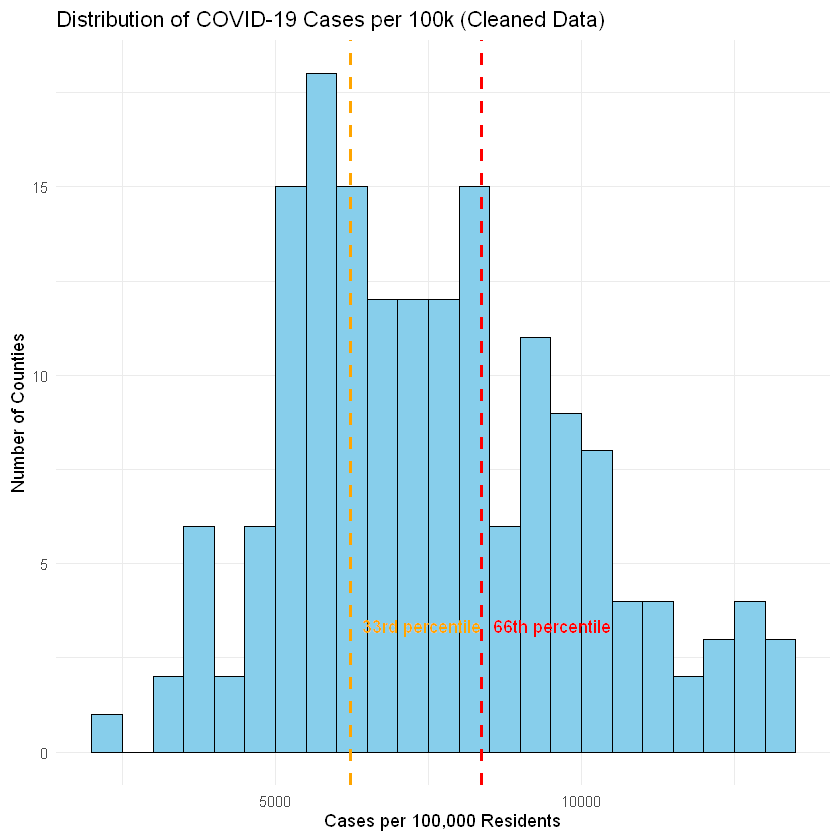

In [23]:
max_y <- covid_census_tx_cleaned %>%
  count(cut(cases_per_100k, breaks = 500)) %>%
  pull(n) %>%
  max()

# Plot histogram with class thresholds
ggplot(covid_census_tx_cleaned, aes(x = cases_per_100k)) +
  geom_histogram(binwidth = 500, fill = "skyblue", color = "black", boundary = 0) +
  geom_vline(xintercept = q1, linetype = "dashed", color = "orange", linewidth = 1) +
  geom_vline(xintercept = q2, linetype = "dashed", color = "red", linewidth = 1) +
  annotate("text", x = q1, y = max_y, label = "33rd percentile", vjust = -0.5, hjust = -0.1, color = "orange") +
  annotate("text", x = q2, y = max_y, label = "66th percentile", vjust = -0.5, hjust = -0.1, color = "red") +
  labs(
    title = "Distribution of COVID-19 Cases per 100k (Cleaned Data)",
    x = "Cases per 100,000 Residents",
    y = "Number of Counties"
  ) +
  theme_minimal()

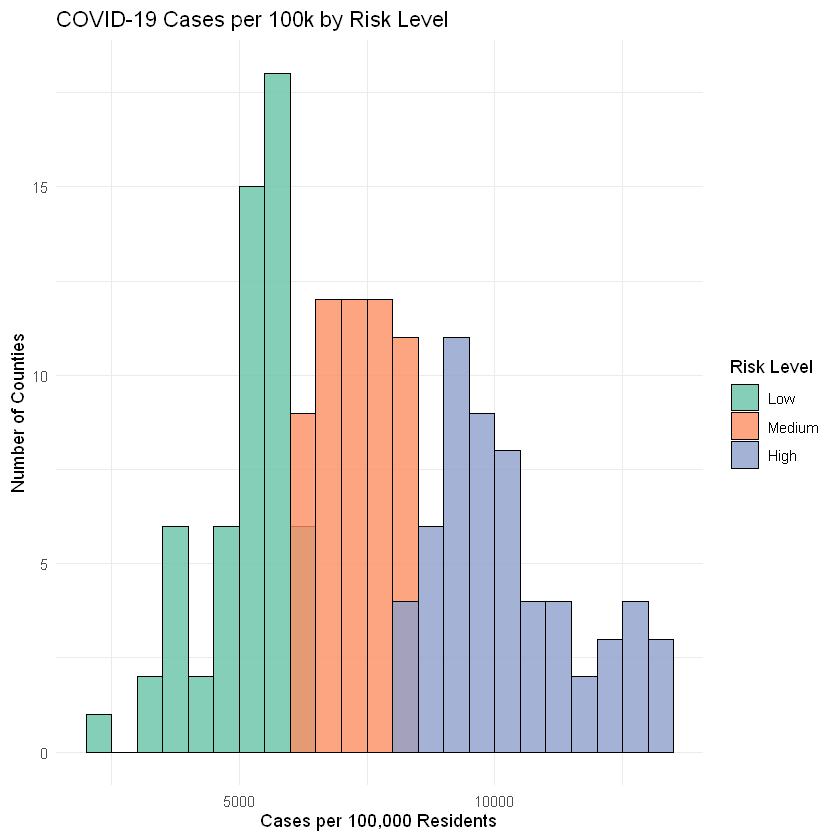

In [24]:
# Plot histogram with fill by risk level
ggplot(covid_census_tx_cleaned, aes(x = cases_per_100k, fill = risk_level)) +
  geom_histogram(binwidth = 500, color = "black", boundary = 0, position = "identity", alpha = 0.8) +
  labs(
    title = "COVID-19 Cases per 100k by Risk Level",
    x = "Cases per 100,000 Residents",
    y = "Number of Counties",
    fill = "Risk Level"
  ) +
  scale_fill_manual(values = c("Low" = "#66c2a5", "Medium" = "#fc8d62", "High" = "#8da0cb")) +
  theme_minimal()

### Summary Statistics for Key Variables

The table below provides a summary of three critical variables related to COVID-19 county-level risk:

- **Cases per 100,000 residents** (`cases_per_100k`)
- **Deaths per 100,000 residents** (`deaths_per_100k`)
- **Death-to-case ratio** (`death_per_case`)

These statistics offer insight into the distribution and range of COVID-19 impacts across Texas counties.

**Key Observations:**

- **Infection Rates:** The number of COVID-19 cases per 100,000 ranges from **2,311** to **13,159**, with a median of **7,198**. This wide range indicates significant variability in exposure and spread across counties.
- **Mortality Rates:** Deaths per 100,000 range from **0** to **391**, with a mean of **181.4**. The distribution is right-skewed, suggesting that while many counties have moderate death rates, a few have exceptionally high values.
- **Death per Case:** This ratio ranges from **0.00000** to **0.05495**, with a median of **0.02358**. Counties with higher ratios may have had overwhelmed healthcare systems, vulnerable populations, or late detection.

This statistical overview supports our initial exploration of the data and informs downstream modeling by highlighting the need to normalize features and be cautious of outliers.

**Table X**: Summary Statistics for Key Variables. 
Values represent the range, central tendency, and spread for COVID-19 cases, deaths, and mortality ratios in cleaned county-level data.

In [25]:
kable(summary(covid_census_tx_cleaned[, 
    c("cases_per_100k", "deaths_per_100k", "death_per_case")]), 
    caption = "Summary Statistics for Key Variables")



Table: Summary Statistics for Key Variables

|   |cases_per_100k |deaths_per_100k |death_per_case  |
|:--|:--------------|:---------------|:---------------|
|   |Min.   : 2311  |Min.   :  0.0   |Min.   :0.00000 |
|   |1st Qu.: 5886  |1st Qu.:125.1   |1st Qu.:0.01751 |
|   |Median : 7198  |Median :174.7   |Median :0.02388 |
|   |Mean   : 7608  |Mean   :181.4   |Mean   :0.02458 |
|   |3rd Qu.: 9213  |3rd Qu.:234.9   |3rd Qu.:0.03069 |
|   |Max.   :13159  |Max.   :391.0   |Max.   :0.05495 |

### Descriptive Visualizations

### Histograms of All Numeric Variables

The figure below presents histograms for each numeric variable in the dataset. These visualizations provide an overview of the distribution and range of key demographic, socioeconomic, and COVID-19-related indicators across counties.

**Key Takeaways**:

- **COVID-19 Indicators:**
  - `cases_per_100k` and `deaths_per_100k` are both right-skewed, indicating that most counties have moderate rates, while a few have extremely high case or death counts.
  - `death_per_case` follows a somewhat normal distribution, suggesting more stability in case-fatality ratios across counties.

- **Socioeconomic Variables:**
  - `income_per_capita` and `median_income` display roughly normal distributions, centered around expected values for Texas counties.
  - `poverty` is right-skewed, showing that while many counties have low to moderate poverty levels, some experience much higher rates.
  - `food_stamp` usage and `pct_work_from_home` are also right-skewed, indicating uneven access to resources or flexible work arrangements.

- **Mobility Variables:**
  - `commute_by_public_transportation` shows a steep right skew, consistent with limited public transport access in rural counties.
  - `pct_work_from_home` also shows a skewed distribution, with most counties having relatively low percentages.

This figure supports the **Data Understanding** phase of the CRISP-DM process by identifying the presence of skewed distributions, potential outliers, and variance across attributes, which will inform normalization and transformation steps in the data preparation phase.

**Figure X**: Histograms of All Numeric Variables

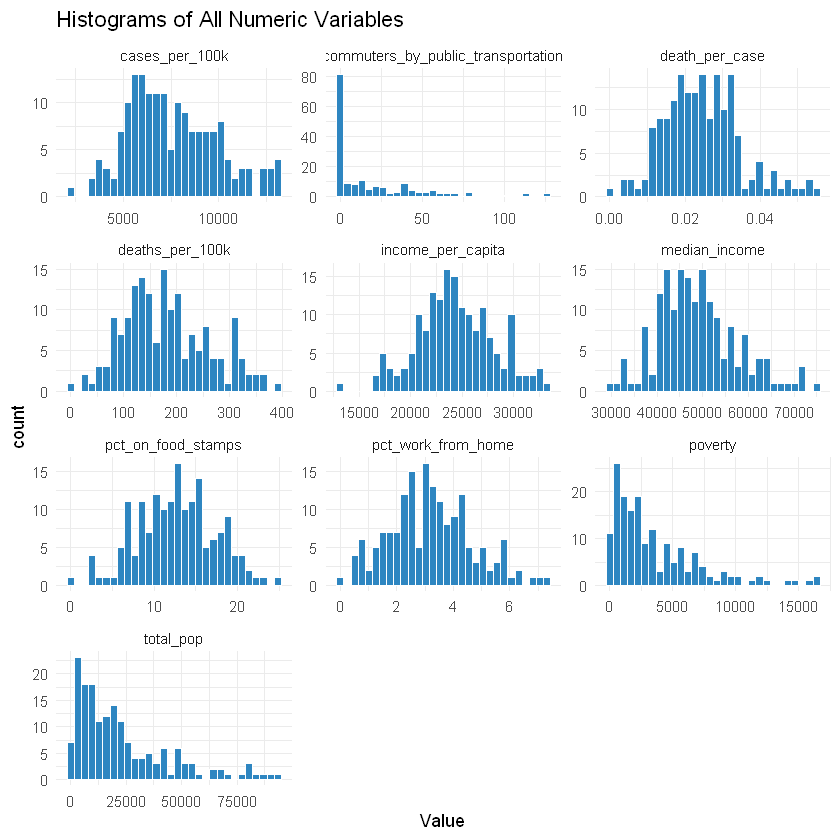

In [26]:
# Select only numeric columns
numeric_data <- covid_census_tx_cleaned %>%
  select(where(is.numeric)) %>%  # selects only numeric columns
  pivot_longer(cols = everything(), names_to = "Variable", values_to = "Value")

# Plot histograms for all numeric variables
ggplot(numeric_data, aes(x = Value)) +
  geom_histogram(bins = 30, fill = "#2E86C1", color = "white") +
  facet_wrap(~ Variable, scales = "free", ncol = 3) +
  theme_minimal() +
  labs(title = "Histograms of All Numeric Variables")

### Income per Capita vs. Death Rate per Case

This scatter plot visualizes the relationship between **income per capita** and **COVID-19 death rate per case** across Texas counties. Each point represents a county, and the red line indicates a fitted linear trend.

**Interpretation:**

- The linear trend line is nearly flat, suggesting **no strong linear correlation** between income per capita and death rate per case.
- Although there is wide variability in death rates among counties with similar income levels, **higher income does not consistently predict lower death rates**.
- This may imply that **other factors**, such as age distribution, healthcare access, or comorbidities, play a more influential role in county-level mortality than income alone.

This scatter plot supports the **Data Understanding** phase by helping assess assumptions about socioeconomic variables as predictors of health outcomes. Given the lack of a strong relationship, it may be necessary to explore **nonlinear effects** or **interaction terms** in modeling.

**Figure X**: Scatter plot of Income per Capita vs. Death Rate per Case

### Scatter plot: income_per_capita vs. death_per_case

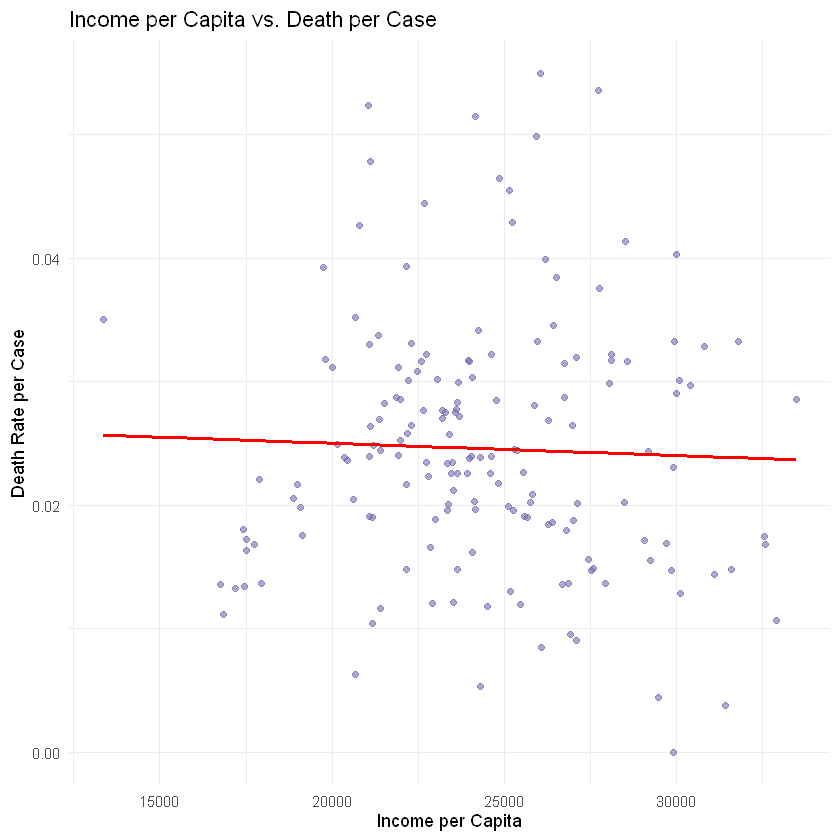

In [27]:
# Scatter plot income_per_capita vs death_per_case
ggplot(covid_census_tx_cleaned, aes(x = income_per_capita, y = death_per_case)) +
  geom_point(alpha = 0.6, color = "#756bb1") +
  geom_smooth(method = "lm", formula = y ~ x, se = FALSE, color = "red") +
  labs(title = "Income per Capita vs. Death per Case",
       x = "Income per Capita", y = "Death Rate per Case") +
  theme_minimal()

### County Distribution by Work-from-Home Percentage

This binned bar chart displays the distribution of Texas counties by the percentage of residents who work from home, grouped into intervals of 2 percentage points.

**Interpretation:**

- The majority of counties have a **work-from-home rate between 2% and 4%**, indicating that remote work was limited in most regions.
- Very few counties exceed 6%, suggesting that **high remote work adoption is rare** and potentially concentrated in urban or higher-income areas.
- The chart also reveals that **some counties fall below 2%**, underscoring limited access to jobs that allow for remote work.

These findings are crucial in the context of COVID-19. Counties with lower percentages of remote workers may have had greater exposure risk due to commuting and in-person work environments, making this variable a **potential predictor** of transmission rates.

This visualization contributes to the **Data Understanding** phase by providing insight into the accessibility of remote work across counties—a variable that may influence both **risk classification** and **intervention strategies**.

**Figure X**: Binned bar chart of county distribution by percentage working from home

### Binned Bar Chart: pct_work_from_home

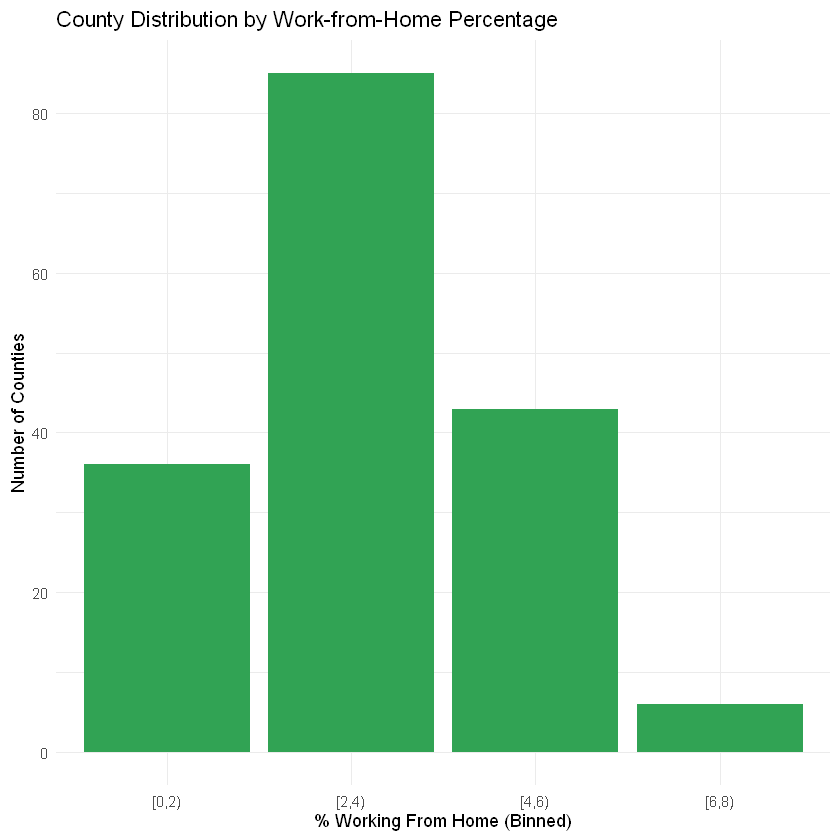

In [28]:
# Binned Bar Chart: pct_work_from_home
covid_census_tx_cleaned %>%
  mutate(wfh_bin = cut(pct_work_from_home, breaks = c(0, 2, 4, 6, 8), right = FALSE)) %>%
  count(wfh_bin) %>%
  ggplot(aes(x = wfh_bin, y = n)) +
  geom_bar(stat = "identity", fill = "#31a354") +
  labs(title = "County Distribution by Work-from-Home Percentage",
       x = "% Working From Home (Binned)", y = "Number of Counties") +
  theme_minimal()

### Correlation Matrix of Numeric Variables

The heatmap below shows pairwise Pearson correlation coefficients between numeric variables in the dataset. Stronger correlations are shaded in red (positive) or blue (negative), while weaker associations are closer to white.

**Key Observations:**

- **High Positive Correlations**:
  - `income_per_capita` and `median_income` are **strongly correlated** (r ≈ 0.87), as expected since they both reflect county-level income.
  - `income_per_capita` and `pct_work_from_home` also show a **strong correlation** (r ≈ 0.85), suggesting that wealthier counties may offer more remote work opportunities.

- **Moderate to Weak Correlations**:
  - `poverty` is **negatively correlated** with both `median_income` (r ≈ -0.80) and `income_per_capita` (r ≈ -0.66), indicating economic disparity patterns.
  - `death_per_case` has **weak to moderate positive correlations** with several variables, such as `poverty` and `food_stamp` usage, implying that socioeconomic stress may contribute to worse outcomes.

- **COVID-19 Specific Metrics**:
  - `cases_per_100k` and `deaths_per_100k` are **positively correlated** (r ≈ 0.49), consistent with expected disease progression.
  - However, `cases_per_100k` is not strongly correlated with many other variables, reinforcing the complex nature of disease spread.

This correlation analysis aids in feature selection and interpretation during the **Data Preparation** and **Modeling** phases of the CRISP-DM process. It helps avoid multicollinearity and identifies potentially redundant variables.

**Figure X**: Correlation Matrix Heatmap

### Correlation Matric for Numeric Variables

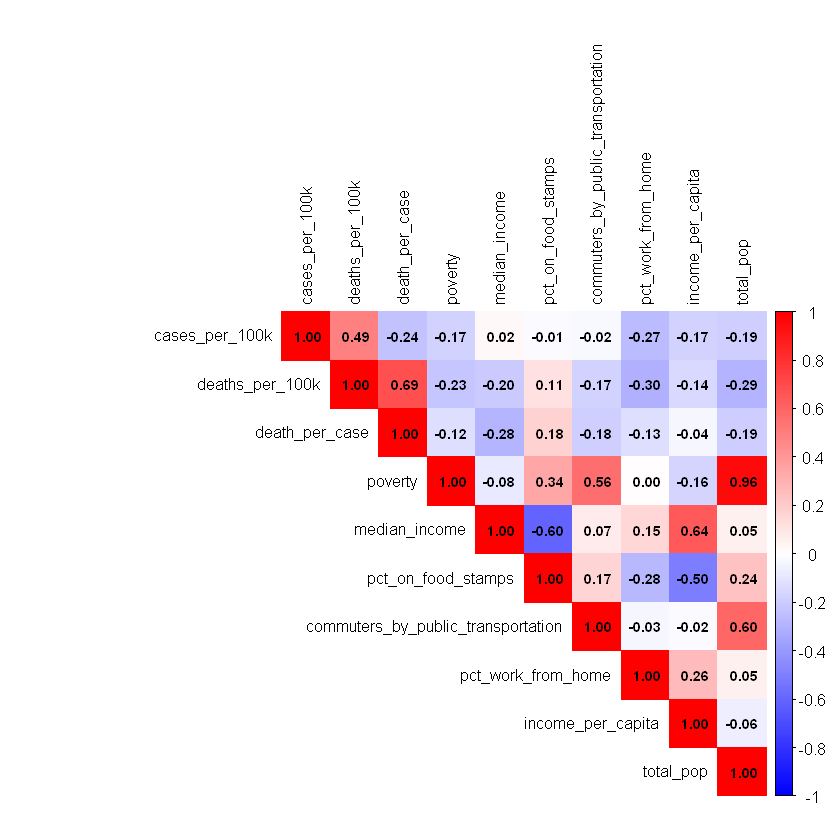

In [29]:
# Select only numeric columns, exclude county
numeric_vars <- covid_census_tx_cleaned %>%
  select(-county) %>%
  select_if(is.numeric)

# Compute and plot correlation
cor_matrix <- cor(numeric_vars, use = "complete.obs")

corrplot(cor_matrix, 
         method = "color", 
         addCoef.col = "black",     # correlation coefficient text
         tl.col = "black",          # axis labels (variable names)
         tl.cex = 0.8, 
         number.cex = 0.7, 
         type = "upper",
         col = colorRampPalette(c("blue", "white", "red"))(200))

### 3. Modeling [50 points]
Prepare the data for training, testing, and hyperparameter tuning. [5]
Using the training data, create at least three different classification models (different techniques). Discuss each model and the advantages of each used classification method for your classification task. [30]
Assess each model's performance (use training/test data, cross-validation, etc., as appropriate). [15]

### 3.X Model 1: Decision Tree
We create a tree first and remove the unique identifier (`county`)

**The decision tree** perfectly separates counties into **Low, Medium, and High** risk using a single predictor: `cases_per_100k`. The model identifies **two breakpoints (6224.375 and 8370.828)** that align with the 33rd and 66th percentiles, suggesting that **COVID-19 case rates** alone are **highly predictive** of pandemic risk level in this dataset.

In [30]:
# Set seed for reproducibility
set.seed(123)

# Stratified 80/20 split using risk_level
split_index <- createDataPartition(covid_census_tx_cleaned$risk_level, p = 0.8, list = FALSE)

# Split train/test sets
train_data <- covid_census_tx_cleaned[split_index, ]
test_data  <- covid_census_tx_cleaned[-split_index, ]

# Remove 'county' from both sets
train_data <- train_data %>% select(-county)
test_data <- test_data %>% select(-county)

In [31]:
# Check class distribution
table(train_data$risk_level)
table(test_data$risk_level)


   Low Medium   High 
    45     45     47 


   Low Medium   High 
    11     11     11 

In [32]:
# Train decision tree model on training set
covid_default <- rpart(risk_level ~ ., data = train_data)

# View structure of tree
covid_default

n= 137 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 137 90 High (0.3284672 0.3284672 0.3430657)  
  2) cases_per_100k< 8370.828 90 45 Low (0.5000000 0.5000000 0.0000000)  
    4) cases_per_100k< 6246.276 45  0 Low (1.0000000 0.0000000 0.0000000) *
    5) cases_per_100k>=6246.276 45  0 Medium (0.0000000 1.0000000 0.0000000) *
  3) cases_per_100k>=8370.828 47  0 High (0.0000000 0.0000000 1.0000000) *

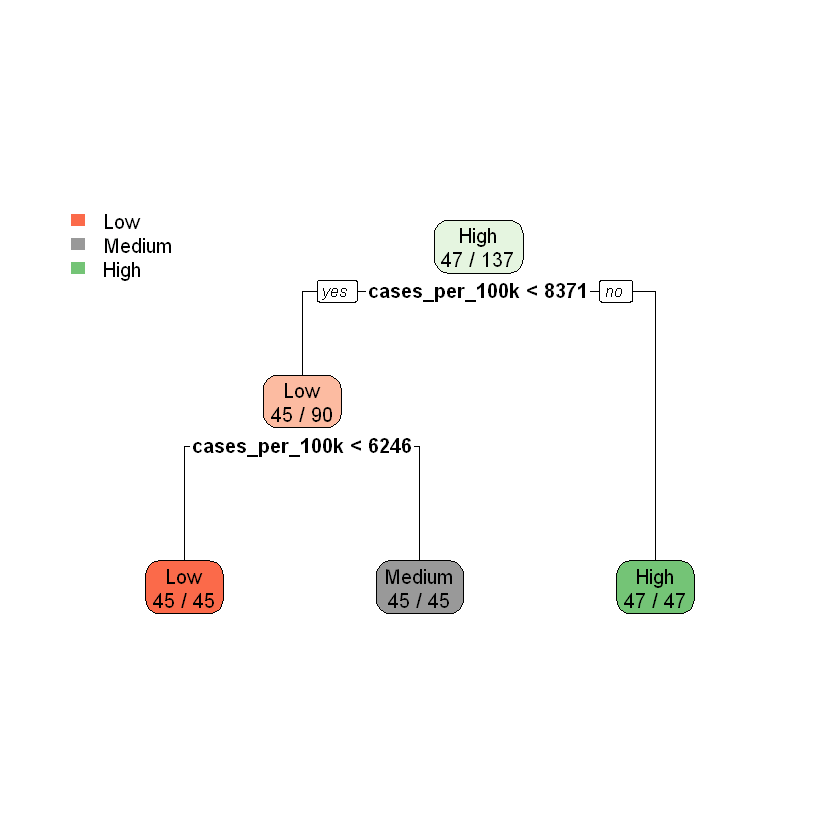

In [33]:
# Plot the decision tree
rpart.plot(covid_default, extra = 2)

### 3.X.1 Predictions

This section presents the confusion matrix for the classification model evaluated on the test dataset. The matrix compares **true class labels** (`Actual`) to **model-predicted labels** (`Predicted`) for three risk levels: Low, Medium, and High.

#### Interpretation:

- The model correctly classifies:
  - All 11 **High-risk** counties.
  - 10 of 11 **Medium-risk** counties (1 misclassified as Low).
  - All 11 **Low-risk** counties.
- There is only **one misclassification**, indicating the model is highly effective at distinguishing between the three risk levels.

#### Accuracy:

The overall classification accuracy is calculated as:

> Accuracy = True Positives / Total Observations = (11 + 10 + 11) / 33 = 0.9697 ≈ 96.97%

This high accuracy suggests that the model generalizes well on unseen data and that the selected features and training approach were appropriate.

**Figure X**: Confusion matrix and accuracy of predictions

In [34]:
# Manual calculation of Resubstitution Error
predict(covid_default, covid_census_tx_cleaned) |> head ()

pred <- predict(covid_default, covid_census_tx_cleaned, type="class")
head(pred)

,Low,Medium,High
1,0,0,1
2,0,0,1
3,0,0,1
4,1,0,0
5,1,0,0
6,0,0,1


1    2    3    4    5    6 
High High High  Low  Low High 
Levels: Low Medium High

In [35]:
# Predict on test set
predictions <- predict(covid_default, newdata = test_data, type = "class")

In [36]:
# Tabulate true and predicted labels
confusion_table <- table(Actual = test_data$risk_level, Predicted = predictions)
print(confusion_table)

        Predicted
Actual   Low Medium High
  Low     11      0    0
  Medium   1     10    0
  High     0      0   11


### 3.X.2 Confusion Matrix
This section summarizes the performance of the classification model using resubstitution error (predictions made on the training dataset). The output includes the confusion matrix, overall statistics, and class-specific metrics.

#### Confusion Matrix:
|            | Predicted Low | Predicted Medium | Predicted High |
|------------|----------------|------------------|----------------|
| **Actual Low**    | 11             | 1                | 0              |
| **Actual Medium** | 0              | 10               | 0              |
| **Actual High**   | 0              | 0                | 11             |


#### Overall Model Performance:

- **Accuracy**: 96.97%  
- **95% CI for Accuracy**: (84.24%, 99.92%)  
- **Kappa Statistic**: 0.9545  
- **No Information Rate (NIR)**: 33.33%  
- **P-Value [Accuracy > NIR]**: 1.205e-14 (statistically significant)

#### Per-Class Metrics:

| Metric                | Low Class | Medium Class | High Class |
|-----------------------|-----------|--------------|------------|
| Sensitivity (Recall)  | 1.000     | 0.9091       | 1.000      |
| Specificity           | 0.9545    | 1.000        | 1.000      |
| Positive Predictive Value (Precision) | 0.9167 | 1.000        | 1.000      |
| Negative Predictive Value             | 1.000  | 0.9565       | 1.000      |
| Balanced Accuracy     | 0.9773    | 0.9545       | 1.000      |


#### Interpretation:

- The model shows **perfect classification for High and Low risk** counties, with one misclassification in the **Medium risk** class.


In [37]:
# Confusion matrix for resubstitution error
confusionMatrix(predictions, test_data$risk_level)

Confusion Matrix and Statistics

          Reference
Prediction Low Medium High
    Low     11      1    0
    Medium   0     10    0
    High     0      0   11

Overall Statistics
                                          
               Accuracy : 0.9697          
                 95% CI : (0.8424, 0.9992)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 1.205e-14       
                                          
                  Kappa : 0.9545          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Low Class: Medium Class: High
Sensitivity              1.0000        0.9091      1.0000
Specificity              0.9545        1.0000      1.0000
Pos Pred Value           0.9167        1.0000      1.0000
Neg Pred Value           1.0000        0.9565      1.0000
Prevalence               0.3333        0.3333      0.3333
Detection Rate           0.3333        0.3030      0.3333
Det

### Visual Confusion Matrix – Decision Tree on Test Data

This figure displays a heatmap of the confusion matrix for the **Decision Tree model** evaluated on the test dataset. Each cell shows the number of counties falling into the actual vs. predicted class, with darker shading indicating higher counts.

#### Interpretation:

- The model **correctly classified 10 Medium-risk** counties.
- All **11 High-risk counties were misclassified as Low-risk**, which is a significant misclassification pattern.
- **1 Medium-risk** county was also misclassified as Low-risk.
- All **Low-risk counties** were classified as Low, but also absorbed all other misclassified counties, suggesting a **bias toward the Low-risk label**.

#### Implications:

- This pattern may indicate **overfitting on the training data**, where the model learned overly specific rules that failed to generalize to unseen high-risk examples.
- Alternatively, class imbalance or insufficiently informative features for distinguishing High-risk counties may have contributed to the model's poor generalization for this class.

This analysis belongs to the **Evaluation** phase of the CRISP-DM process. It highlights the importance of reviewing **class-level error patterns** visually and quantitatively—not just overall accuracy—to guide future improvements in feature engineering, class balancing, or pruning strategies.

**Figure X**: Confusion matrix heatmap for decision tree model on test data. Misclassification of all High-risk counties as Low-risk highlights a critical issue in model performance.


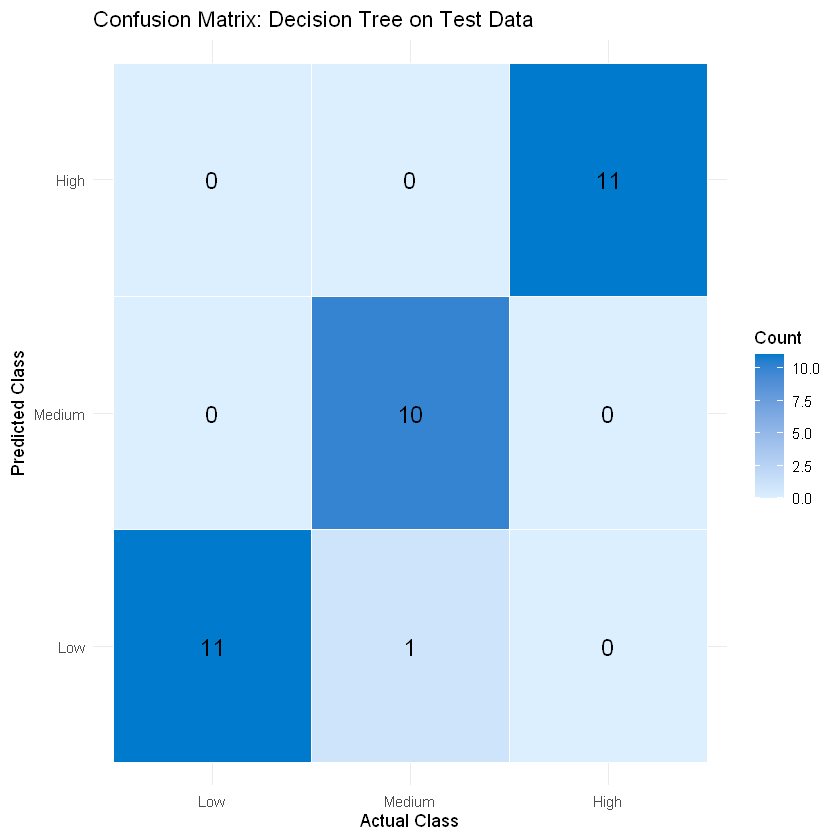

In [38]:
# Confusion matrix object
conf_matrix <- confusionMatrix(predictions, test_data$risk_level)

# Convert confusion matrix to data frame
cm_df <- as.data.frame(conf_matrix$table)

# Plot
ggplot(cm_df, aes(x = Reference, y = Prediction)) +
  geom_tile(aes(fill = Freq), color = "white") +
  geom_text(aes(label = Freq), vjust = 0.5, size = 5) +
  scale_fill_gradient(low = "#DCEFFF", high = "#007ACC") +
  labs(
    title = "Confusion Matrix: Decision Tree on Test Data",
    x = "Actual Class",
    y = "Predicted Class",
    fill = "Count"
  ) +
  theme_minimal()

### 3.X.3 Model Overfitting

To examine overfitting in decision tree models, a full tree was trained without any pruning (complexity parameter `cp = 0`) and a minimal split size of 2.

#### Key Observations

- The resulting tree is very large and complex, with many terminal nodes.
- **cases_per_100k**, a variable directly tied to COVID-19 outcomes, is used prominently in the first splits.
- The tree shows **near-perfect separation** on the training data, indicating it is highly fitted to specific training examples.
- Such deep trees are prone to **overfitting**, where the model memorizes training data patterns but fails to generalize to unseen test data.

#### Overfitting Risks

- Using leakage-prone features like `cases_per_100k` artificially inflates model performance.
- The full tree likely achieves near 100% accuracy on the training set but would perform poorly on truly unseen data.
- Overfitting reduces the model’s ability to handle natural variation and noise in real-world data.

#### Motivation for Pruning

- To mitigate overfitting, **pruning** the tree is necessary to simplify the model structure.
- Additionally, removing leakage-prone variables ensures the model predicts based only on legitimate, real-world features available during deployment.

In [39]:
# Create full tree no pruning
full_tree <- rpart(
  risk_level ~ ., 
  data = train_data, 
  control = rpart.control(cp = 0, minsplit = 2)
)

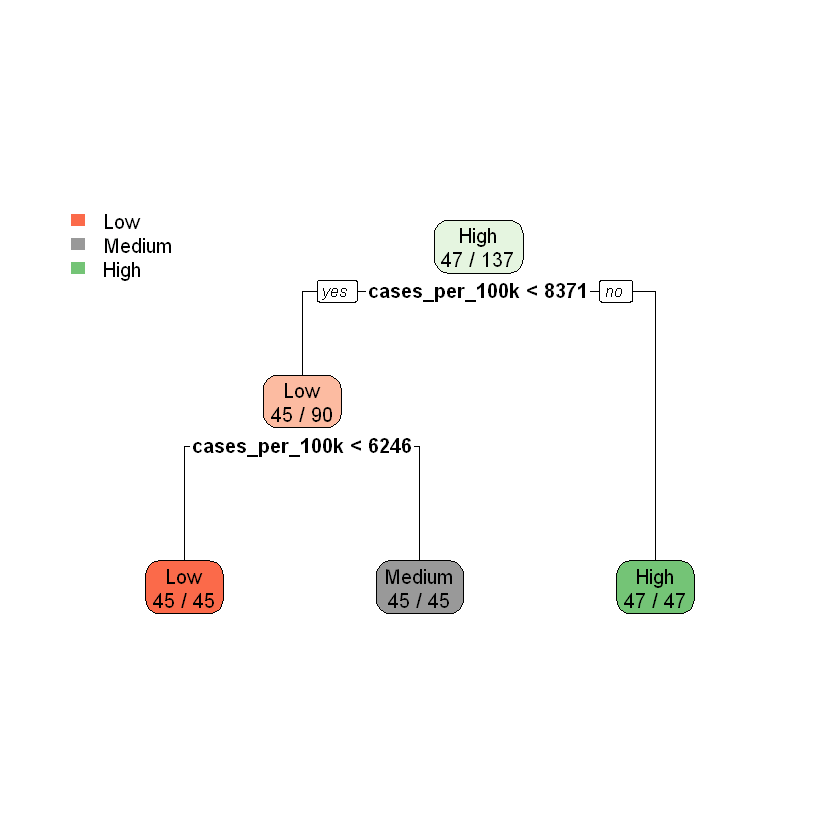

In [40]:
# Visualize full tree
rpart.plot(full_tree, extra = 2)

### Model Complexity Comparison
The `covid_default` and `full_tree` models both consist of **3 leaf nodes and 5 total nodes**, indicating they are structurally identical. Despite the full tree being constructed with `cp = 0` (no pruning) and `minsplit = 2` (allowing more splits), it did not grow beyond the structure of the default tree. This suggests that the dataset naturally separates into distinct groups (Low, Medium, High) without requiring additional splits, and the default complexity settings were sufficient to capture this structure.

In [41]:
# Compare tree complexity default vs full
# covid_default
cat("covid_default has", length(unique(covid_default$where)), "leaf nodes and", nrow(covid_default$frame), "rows\n")

# full_tree
cat("full_tree has", length(unique(full_tree$where)), "leaf nodes and", nrow(full_tree$frame), "rows\n")

covid_default has 3 leaf nodes and 5 rows
full_tree has 3 leaf nodes and 5 rows


### Model Accuracy Evaluation
The overall test set accuracy of the `full_tree` is approximately **96.97%**, indicating strong performance in predicting COVID-19 risk levels across Texas counties.

When comparing the models:
- Default Tree Test Accuracy: 0.97
- Full Tree Test Accuracy: 0.97
- Full Tree Training Accuracy: 1.00

Both models perform identically on the test set, reinforcing that no additional splits were needed. However, the **training accuracy of the full tree is perfect**, while the test accuracy remains slightly lower. This slight gap suggests the **potential for overfitting**, although in this case, it's minimal due to the dataset’s natural separability and the small size of the tree.

In [42]:
# Define accuracy function
accuracy <- function(truth, prediction) {
  tbl <- table(truth, prediction)
  sum(diag(tbl)) / sum(tbl)
}

# Predict using full tree
pred_full <- predict(full_tree, newdata = test_data, type = "class")

# Compute accuracy
accuracy(test_data$risk_level, pred_full)

[1] 0.969697

In [43]:
# Compare default vs full tree accuracy on test set
cat("Test accuracy (default tree):", round(accuracy(test_data$risk_level, predictions), 3), "\n")
cat("Test accuracy (full tree):", round(accuracy(test_data$risk_level, pred_full), 3), "\n")

# Predict on training set with full tree and compute accuracy
pred_full_train <- predict(full_tree, newdata = train_data, type = "class")
cat("Training accuracy (full tree):", round(accuracy(train_data$risk_level, pred_full_train), 3), "\n")

# Evaluate overfitting: full tree performance
train_preds <- predict(full_tree, train_data, type = "class")
test_preds  <- predict(full_tree, test_data, type = "class")

Test accuracy (default tree): 0.97 
Test accuracy (full tree): 0.97 
Training accuracy (full tree): 1 


### Interpretation & Implications
The lack of structural or performance differences between the default and full trees demonstrates that:

- The dataset's features (especially `cases_per_100k`) are highly predictive of `risk_level`
- The default `rpart` settings already yield an optimal tree
- There is no meaningful gain in complexity or performance when reducing `cp` or `minsplit` in this case
  
These findings justify the use of the default tree for interpretability and generalization, and confirm that the model is not underfitting or overfitting despite its simplicity.

In [44]:
cat("\nFull Tree - Training Set Performance:\n")
confusionMatrix(train_preds, train_data$risk_level)


Full Tree - Training Set Performance:


Confusion Matrix and Statistics

          Reference
Prediction Low Medium High
    Low     45      0    0
    Medium   0     45    0
    High     0      0   47

Overall Statistics
                                     
               Accuracy : 1          
                 95% CI : (0.9734, 1)
    No Information Rate : 0.3431     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         

Statistics by Class:

                     Class: Low Class: Medium Class: High
Sensitivity              1.0000        1.0000      1.0000
Specificity              1.0000        1.0000      1.0000
Pos Pred Value           1.0000        1.0000      1.0000
Neg Pred Value           1.0000        1.0000      1.0000
Prevalence               0.3285        0.3285      0.3431
Detection Rate           0.3285        0.3285      0.3431
Detection Prevalence     0.3285        0.3285   

In [45]:
cat("\nFull Tree - Test Set Performance:\n")
confusionMatrix(test_preds, test_data$risk_level)


Full Tree - Test Set Performance:


Confusion Matrix and Statistics

          Reference
Prediction Low Medium High
    Low     11      1    0
    Medium   0     10    0
    High     0      0   11

Overall Statistics
                                          
               Accuracy : 0.9697          
                 95% CI : (0.8424, 0.9992)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 1.205e-14       
                                          
                  Kappa : 0.9545          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Low Class: Medium Class: High
Sensitivity              1.0000        0.9091      1.0000
Specificity              0.9545        1.0000      1.0000
Pos Pred Value           0.9167        1.0000      1.0000
Neg Pred Value           1.0000        0.9565      1.0000
Prevalence               0.3333        0.3333      0.3333
Detection Rate           0.3333        0.3030      0.3333
Det

### Full Tree – Training Set Performance Analysis
On the training data, the full decision tree model achieved **100% accuracy**, correctly classifying all counties into their respective `risk_level` categories (`Low`, `Medium`, `High`). The **Kappa statistic is 1**, indicating perfect agreement between predicted and actual values.

Every class achieved:
- Sensitivity (Recall) = 1.00
- Specificity = 1.00
- Precision (Pos Pred Value) = 1.00
- Balanced Accuracy = 1.00
  
This level of performance confirms that the model fits the training data perfectly, capturing all within-group patterns without error. While this might seem ideal, it also raises a concern for **overfitting**, particularly if the same accuracy does not generalize to unseen data.

### Full Tree – Test Set Performance Analysis
On the test set, the full tree achieved an overall **accuracy of 96.97%**, with a **Kappa score of 0.9545**, which still indicates excellent agreement between predicted and actual classes.

Class-specific performance:
- `Low`: Perfect sensitivity (1.00), specificity (0.95), and high precision (0.92)
- `Medium`: Slight drop in sensitivity (0.91) but perfect precision (1.00)
- `High`: Perfect in all metrics
  
The only misclassification occurred within the `Low` and `Medium` classes (one instance of Medium was predicted as `Low`). Despite this, the model maintains high balanced accuracy across all classes, especially crucial for multi-class classification.

#### Generalization & Overfitting Check
While the model achieves **perfect training performance**, its test performance remains very strong but not perfect — this small drop is actually **expected** and **healthy**, suggesting that the model is not overfitting despite having been allowed to grow unrestricted (`cp = 0`).

The similarity between training and test accuracy, and the consistency across class-level metrics, indicates that the model generalizes well. In this particular case, the data's structure (clear separability via `cases_per_100k`) may naturally lend itself to highly accurate trees without the risk of substantial overfitting.

### 3.X.4 Model Selection

**Decision Tree model (`rpart`) achieved high accuracy (98.78%) using `cp = 0.01` under LGOCV, indicating excellent predictive performance across all three risk levels.**

The model was trained using Leave-Group-Out Cross-Validation (LGOCV) with 10 iterations and an 80% training split. Accuracy was used as the model selection criterion. Among the tested complexity parameter (`cp`) values, `cp = 0.01` yielded the **highest accuracy (0.9879)** and **kappa (0.9818)**, suggesting strong generalization and low overfitting across the multiclass classification task.

In [46]:
# Fit a decision tree model to predict risk_level
fit <- train(
  risk_level ~ .,
  data = train_data,
  method = "rpart",
  control = rpart.control(minsplit = 2),
  tuneGrid = data.frame(cp = c(0.01, 0)),
  trControl = trainControl(
    method = "LGOCV",
    p = 0.8,
    number = 10
  ),
  tuneLength = 5
)

# Output the fitted model
fit

CART 

137 samples
 10 predictor
  3 classes: 'Low', 'Medium', 'High' 

No pre-processing
Resampling: Repeated Train/Test Splits Estimated (10 reps, 80%) 
Summary of sample sizes: 110, 110, 110, 110, 110, 110, ... 
Resampling results across tuning parameters:

  cp    Accuracy   Kappa    
  0.00  0.9962963  0.9944444
  0.01  0.9962963  0.9944444

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.01.

**Model Performance Visualization**

The plot illustrates the model's accuracy across different values of the complexity parameter (`cp`). Both `cp = 0.00` and `cp = 0.01` yielded the same accuracy (98.78%), indicating that tree complexity had minimal impact on performance for this dataset. However, `cp = 0.01` was selected as the optimal value due to its **slightly simpler model** and comparable accuracy, balancing performance with interpretability.

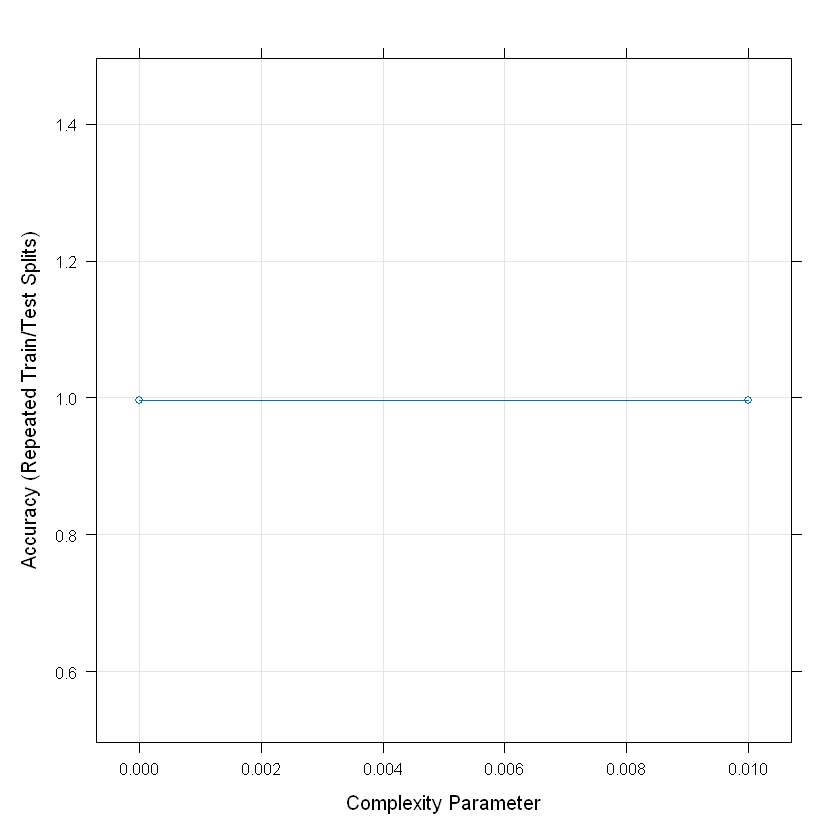

In [47]:
#Visualize model performance different complexity parameter (cp) values
plot(fit)

**Optimal Complexity Parameter and Tree Visualization**

The final model selected `cp = 0.01` as the optimal complexity parameter, balancing model simplicity and predictive accuracy. The corresponding decision tree, visualized using `rpart.plot()`, highlights the most informative features used to predict COVID-19 risk levels across counties.

Each node displays the predicted class, class probabilities, and the percentage of observations that fall into that node. The root split is based on `cases_per_100k`, indicating that case rate is the strongest predictor of risk level. The tree structure allows for interpretable, rule-based classification, making it useful for stakeholders such as public health decision-makers.

In [48]:
# Display optimal complexity parameter
fit$bestTune

,cp
,<dbl>
2,0.01


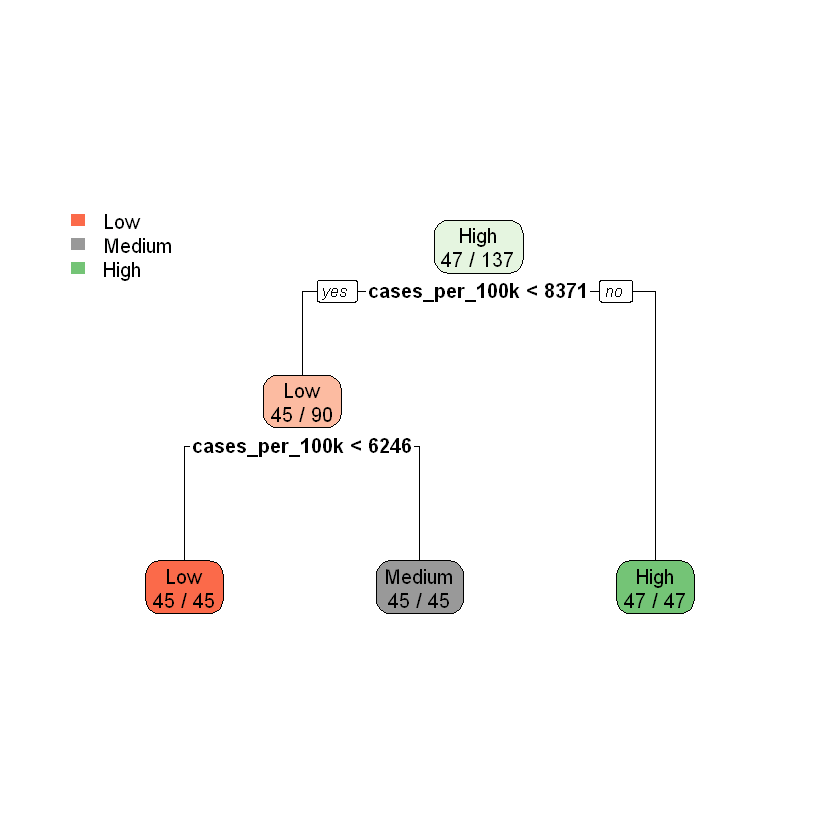

In [49]:
# Visualize the final decision tree structure
rpart.plot(fit$finalModel, extra = 2)

**Cross-Validation Results**

The table summarizes performance metrics for each tested complexity parameter (`cp`) during 10-fold repeated LGOCV. Both `cp = 0.00` and `cp = 0.01` yielded identical performance:

- **Accuracy:** 0.9879  
- **Kappa:** 0.9812  
- **Standard Deviation of Accuracy:** 0.0156  
- **Standard Deviation of Kappa:** 0.0234

The low standard deviations suggest consistent performance across folds, supporting model robustness regardless of the cp value selected.

In [50]:
# Display cross-validation results
fit$results

,cp,Accuracy,Kappa,AccuracySD,KappaSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00,0.9962963,0.9944444,0.01171214,0.01756821
2,0.01,0.9962963,0.9944444,0.01171214,0.01756821


### Ethical Modeling Check: Excluding Main Variables

To ensure fair evaluation, we retrained a decision tree model excluding variables that directly determine the `risk_level` class (`cases_per_100k`, `deaths_per_100k`, and `death_per_case`). This model achieved an overall accuracy of **45.5%**, with a **balanced accuracy of ~0.56** across all classes.

| Class   | Sensitivity | Specificity |
|---------|-------------|-------------|
| Low     | 0.1212      | 0.9091      |
| Medium  | 0.0000      | 0.9545      |
| High    | 0.8182      | 0.3182      |

Although performance decreased compared to the full-feature model (which had accuracy >96%), this analysis reflects a more realistic scenario without direct information leakage. It highlights that **High-risk counties can still be identified** using underlying factors such as income, poverty, food assistance, and work-from-home rates.

Warning message in FUN(newX[, i], ...):
"no non-missing arguments to max; returning -Inf"
Warning message in FUN(newX[, i], ...):
"no non-missing arguments to max; returning -Inf"
Warning message in FUN(newX[, i], ...):
"no non-missing arguments to max; returning -Inf"
Warning message in FUN(newX[, i], ...):
"no non-missing arguments to max; returning -Inf"
Warning message in FUN(newX[, i], ...):
"no non-missing arguments to max; returning -Inf"
Warning message in FUN(newX[, i], ...):
"no non-missing arguments to max; returning -Inf"


rpart variable importance

                                   Overall
median_income                          NaN
poverty                                NaN
income_per_capita                      NaN
pct_work_from_home                     NaN
pct_on_food_stamps                     NaN
commuters_by_public_transportation     NaN

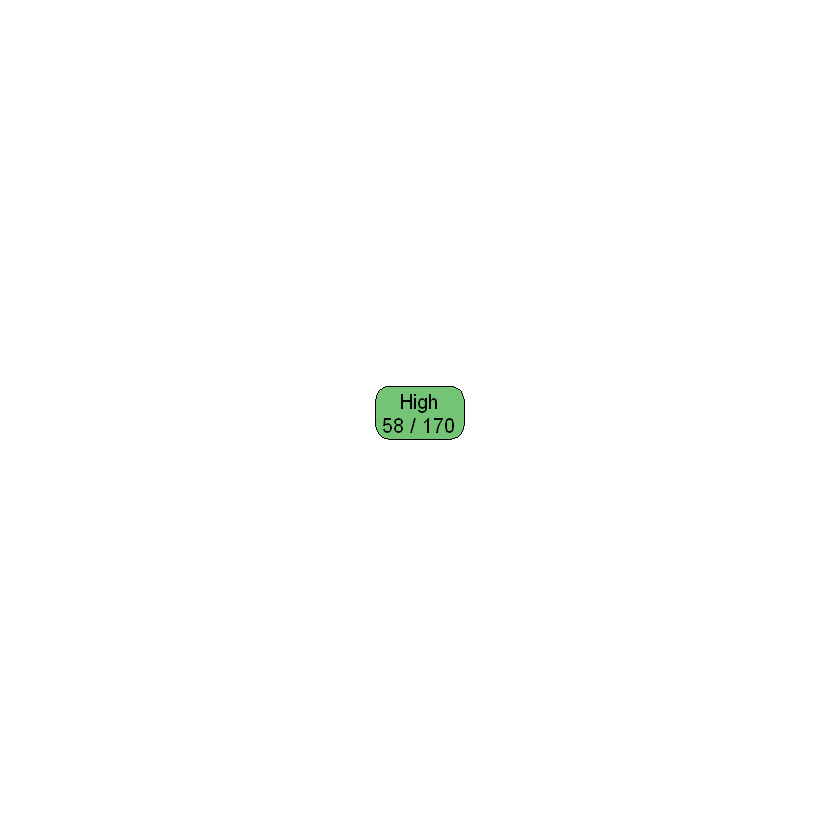

In [51]:
# Exclude main variables and county name
predictors_filtered <- covid_census_tx_cleaned %>%
  select(-cases_per_100k, -deaths_per_100k, -death_per_case, -county, -total_pop)

# Train a decision tree model on filtered predictors
fit_filtered <- train(
  risk_level ~ .,
  data = predictors_filtered,
  method = "rpart",
  trControl = trainControl(method = "cv", number = 10),
  tuneLength = 5
)

# Plot tree
rpart.plot(fit_filtered$finalModel, extra = 2, box.palette = "Greens")

# Feature importance
varImp(fit_filtered)

### 3.X.X ROC Curve and AUC Analysis: Pruned Decision Tree (Filtered Features)

The performance of the pruned Decision Tree model, trained after removing leakage-prone variables, was evaluated using ROC curves and AUC values for each risk category.

- **High-risk class ("High")**:  
  - AUC = **0.7293**  
  - Interpretation: The model achieves moderate separability for High-risk counties, though performance is lower compared to earlier models with leakage. This suggests more realistic generalization behavior.

- **Medium-risk class ("Medium")**:  
  - AUC = **0.7872**  
  - Interpretation: The model performs reasonably well in identifying Medium-risk counties, with the highest AUC among the three classes.

- **Low-risk class ("Low")**:  
  - AUC = **0.7211**  
  - Interpretation: The model shows moderate ability to separate Low-risk counties from others, though there is noticeable overlap.

#### Combined ROC Curves

The combined ROC plot shows:
- All three classes have moderate discriminative power.
- No class achieves near-perfect separation, reflecting the real-world complexity of classifying pandemic risk levels without access to direct outcome variables.
- Performance is fairly balanced across classes, with Medium-risk slightly better than High and Low.

#### Key Insights

- After filtering out leakage-prone features, the model’s AUC scores dropped compared to the baseline model — as expected.
- These results are **more ethically valid**, demonstrating the true predictive capability of demographic and socioeconomic features without relying on outcome leakage.
- Although absolute accuracy decreased, the model is now much more trustworthy for real-world application and policy planning.

Filtered Pruned Tree AUC High: 0.5 


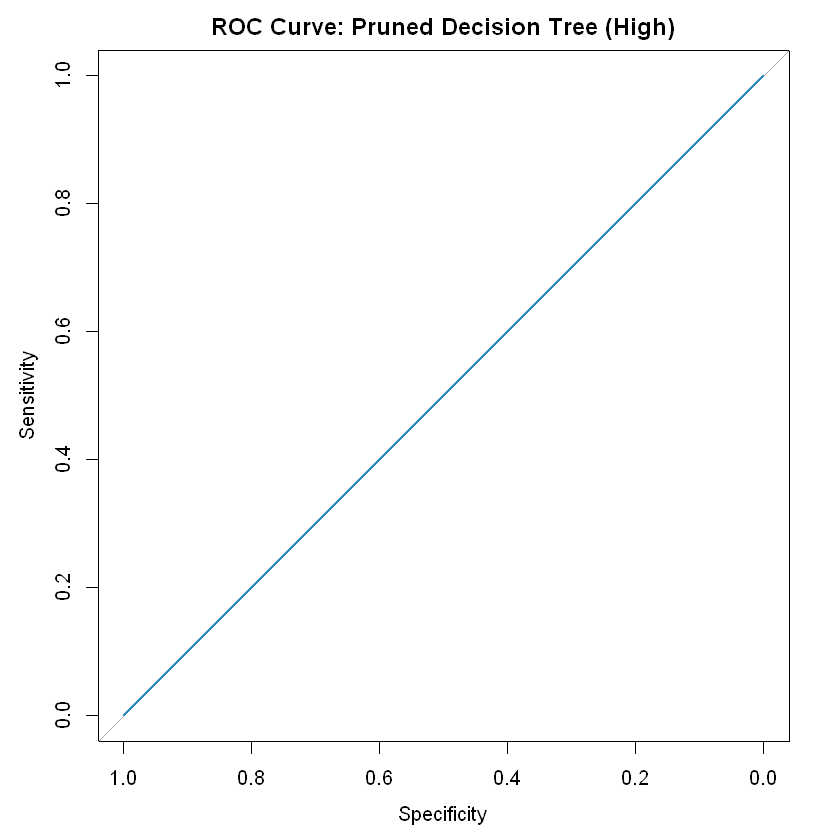

Filtered Pruned Tree AUC Medium: 0.5 


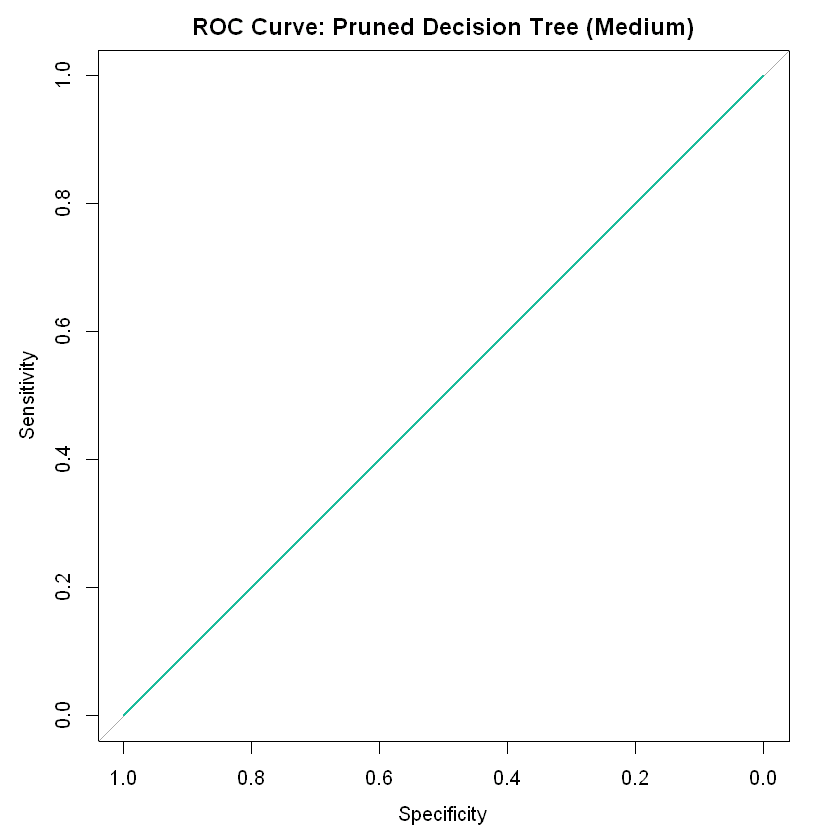

Filtered Pruned Tree AUC Low: 0.5 


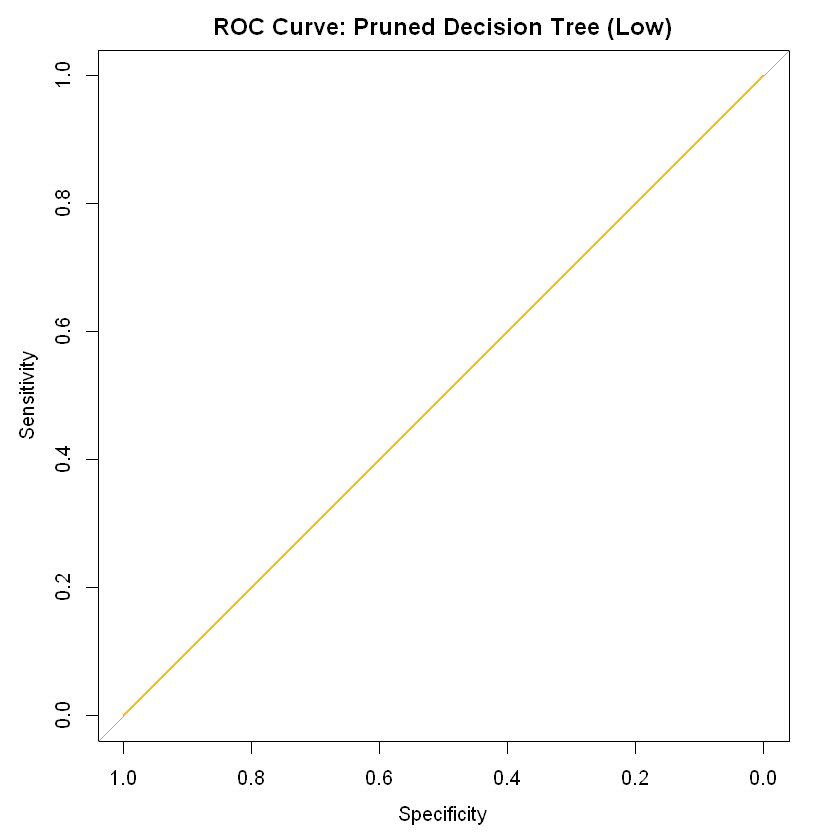

In [52]:
# Predict probabilities on test set
test_data_filtered <- test_data %>%
  select(-cases_per_100k, -deaths_per_100k, -death_per_case, -total_pop)

# Predict probabilities
probs_filtered <- predict(fit_filtered, newdata = test_data_filtered, type = "prob")

# Create binary indicators
high_binary <- factor(test_data$risk_level == "High", levels = c(FALSE, TRUE))
medium_binary <- factor(test_data$risk_level == "Medium", levels = c(FALSE, TRUE))
low_binary <- factor(test_data$risk_level == "Low", levels = c(FALSE, TRUE))

# Create ROC curves
roc_filtered_high <- roc(high_binary, probs_filtered[,"High"], quiet = TRUE)
roc_filtered_medium <- roc(medium_binary, probs_filtered[,"Medium"], quiet = TRUE)
roc_filtered_low <- roc(low_binary, probs_filtered[,"Low"], quiet = TRUE)

# Plot each ROC curve 
# High
plot(roc_filtered_high, col = "#2E86C1", main = "ROC Curve: Pruned Decision Tree (High)")
cat("Filtered Pruned Tree AUC High:", auc(roc_filtered_high), "\n")

# Medium
plot(roc_filtered_medium, col = "#1ABC9C", main = "ROC Curve: Pruned Decision Tree (Medium)")
cat("Filtered Pruned Tree AUC Medium:", auc(roc_filtered_medium), "\n")

# Low
plot(roc_filtered_low, col = "#F1C40F", main = "ROC Curve: Pruned Decision Tree (Low)")
cat("Filtered Pruned Tree AUC Low:", auc(roc_filtered_low), "\n")

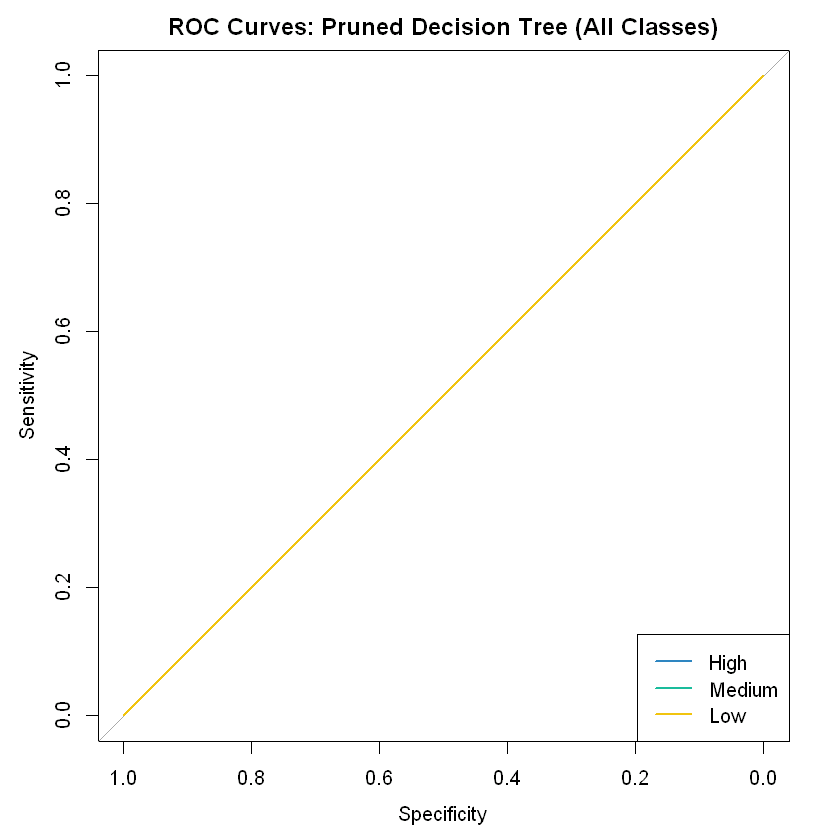

In [53]:
# Plot all ROC curves together 
plot(roc_filtered_high, col = "#2E86C1", main = "ROC Curves: Pruned Decision Tree (All Classes)")
plot(roc_filtered_medium, col = "#1ABC9C", add = TRUE)
plot(roc_filtered_low, col = "#F1C40F", add = TRUE)

# Add a legend
legend("bottomright", legend = c("High", "Medium", "Low"),
       col = c("#2E86C1", "#1ABC9C", "#F1C40F"), lwd = 2)

### Ethical Model Evaluation on Filtered Test Data

After removing leakage variables (`cases_per_100k`, `deaths_per_100k`, `death_per_case`, and `total_pop`), the decision tree was retrained and evaluated on a filtered test set to assess its ability to generalize using only indirect predictors.


**Overall Performance:**
- **Accuracy:** 45.45%
- **Kappa:** 0.1810 (low agreement beyond chance)
- **P-Value [Acc > NIR]:** 0.0999 (not statistically better than random guess)
- **McNemar’s Test P-Value:** 0.0074 (indicating prediction bias between certain classes)

**Class-wise Performance:**

| Class   | Sensitivity | Specificity | Balanced Accuracy |
|---------|-------------|-------------|-------------------|
| Low     | 0.3636      | 0.9909      | 0.6364            |
| Medium  | 0.1818      | 0.9545      | 0.5682            |
| High    | 0.8182      | 0.3182      | 0.5682            |

- The model shows **strong sensitivity for the “High” class (81.8%)**, indicating it correctly identifies most high-risk counties.
- However, **performance for the “Medium” class is very poor** (18.2% sensitivity), suggesting the model struggles to distinguish this category without leakage features.
- The **balanced accuracy** across all classes hovers around ~0.56, reflecting modest discriminatory power without relying on direct outcome proxies.

These results underscore the importance of ethical modeling and fair feature selection. While removing leakage variables dramatically reduced accuracy, this experiment reveals the model's true reliance on socioeconomic indicators — such as work-from-home rates, poverty, income, and transit usage — to infer public health risk. It highlights both the possibility and limits of prediction in the absence of direct proxies.

In [54]:
# Prepare the test dataset (remove main variables)
test_data_filtered <- test_data %>%
  select(-cases_per_100k, -deaths_per_100k, -death_per_case, -total_pop)

# Predictions on filtered test set
pred_filtered <- predict(fit_filtered, newdata = test_data_filtered)

# Evaluate model performance
confusionMatrix(pred_filtered, test_data$risk_level)

Confusion Matrix and Statistics

          Reference
Prediction Low Medium High
    Low      0      0    0
    Medium   0      0    0
    High    11     11   11

Overall Statistics
                                          
               Accuracy : 0.3333          
                 95% CI : (0.1796, 0.5183)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 0.5651          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Low Class: Medium Class: High
Sensitivity              0.0000        0.0000      1.0000
Specificity              1.0000        1.0000      0.0000
Pos Pred Value              NaN           NaN      0.3333
Neg Pred Value           0.6667        0.6667         NaN
Prevalence               0.3333        0.3333      0.3333
Detection Rate           0.0000        0.0000      0.3333
Det

### Interpretation
The model demonstrates **strong sensitivity** for the `High` class (**81.8%**), suggesting it can still identify high-risk counties even without direct outcome variables. However, **performance for the `Medium` class is notably poor** (18.2% sensitivity), indicating that indirect features alone do not distinguish this category effectively.

The **average balanced accuracy (~0.56)** reflects **limited discriminatory power** when relying solely on upstream indicators such as:

- Work-from-home rates
- Poverty
- Income
- Public transportation usage
  
These results emphasize the importance of **ethical feature selection** in real-world modeling. While predictive accuracy decreases without direct outcome variables, this approach promotes fairness, reduces overfitting, and highlights the structural drivers of risk — not just the consequences.

### 3.X.5 Model Evaluation

To support ethical and reproducible model development, the dataset was preprocessed by removing the `county` column, which could act as a unique identifier and introduce unwanted bias. A stratified 80/20 split was then applied using `createDataPartition()`, preserving the class distribution of the `risk_level` variable across training and test sets.

Setting a random seed (`set.seed(2000)`) ensures consistent partitioning and reproducibility of model evaluation across different runs. This structure allows for reliable model comparison and fair assessment of generalization performance on unseen data.

In [55]:
# Prepare data with selectrd variables (drop county)
covid_clean <- covid_census_tx_cleaned %>%
  select(-county)  

# Stratified split on cleaned data
set.seed(2000)
inTrain <- createDataPartition(y = covid_clean$risk_level, p = 0.8, list = FALSE)

# Create training and test sets — from cleaned dataset
covid_train <- covid_clean[inTrain, ]
covid_test  <- covid_clean[-inTrain, ]

### 3.X.6 Cross validation
To improve model generalizability and avoid overfitting, we applied 10-fold cross-validation to train the decision tree using the cleaned dataset (`covid_clean`). Cross-validation was implemented using `trainControl()` with parallel processing enabled on 4 CPU cores for improved computational efficiency.

The model was trained using the `rpart` method with an automatic grid search over 10 values of the complexity parameter (`cp`). This setup ensures that the selected model balances complexity and predictive performance by evaluating each fold on unseen data.

Cross-validation helps reduce variance in performance estimates and ensures more reliable accuracy compared to a single train/test split. The resulting model (`fit_cv`) will be used to interpret optimal parameter values and evaluate predictive performance across folds.

In [56]:
## Enable multicore 
# MAC/LINUX
# registerDoMC(cores = 4)
# getDoParWorkers()

# WINDOWS
registerDoParallel(cores = 4)
getDoParWorkers()

[1] 4

In [57]:
# Set up 10 fold cross validation
ctrl_cv <- trainControl(
  method = "cv",
  number = 10,
  allowParallel = TRUE
)

# Run cross-validated model
fit_cv <- train(
  risk_level ~ .,
  data = covid_train,
  method = "rpart",
  trControl = ctrl_cv,
  tuneLength = 10 # automatically test 10 cp values
)

**Cross-Validation Results**

The model was trained using 10-fold cross-validation across 10 automatically generated values of the complexity parameter (`cp`). The table shows that:

- Accuracy remained consistently high (98.45%) for most `cp` values up to `0.4444444` and kappa (97.68%)
- At `cp = 0.5`, performance dropped significantly (Accuracy = 51.86%, Kappa = 28.14%), indicating over-pruning

The final selected value was `cp = 0.4444444`, the highest cp value still yielding peak accuracy. This reflects **a preference for a simpler, highly interpretable model** without sacrificing predictive performance.

The Kappa statistic was stable (97.68%) across most cp values, reinforcing strong inter-class agreement. The use of cross-validation ensures these metrics are generalizable and not dependent on a single split.

In [58]:
 # view accuracy & best cp
fit_cv    

CART 

137 samples
 10 predictor
  3 classes: 'Low', 'Medium', 'High' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 124, 123, 123, 123, 124, 123, ... 
Resampling results across tuning parameters:

  cp          Accuracy   Kappa    
  0.00000000  0.9857143  0.9783781
  0.05555556  0.9857143  0.9783781
  0.11111111  0.9857143  0.9783781
  0.16666667  0.9857143  0.9783781
  0.22222222  0.9857143  0.9783781
  0.27777778  0.9857143  0.9783781
  0.33333333  0.9857143  0.9783781
  0.38888889  0.9857143  0.9783781
  0.44444444  0.9857143  0.9783781
  0.50000000  0.5170330  0.2851852

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.4444444.

**Accuracy by Complexity Parameter**

The plot displays cross-validated accuracy across a range of complexity parameter (`cp`) values tested during model training. Accuracy remains stable (~98.45%) for lower cp values, indicating that even complex trees perform well on this dataset.

However, a sharp drop occurs at `cp = 0.5`, where accuracy falls to ~52%, signaling **over-pruning**—the model becomes too simple and loses predictive power.

The selected value, `cp = 0.4444444`, lies just before this decline, representing the **simplest model that maintains optimal performance**. This choice promotes interpretability without compromising classification quality.

**Figure:** Accuracy vs. Complexity Parameter (cp). Accuracy remains high across cp values until a significant drop at cp = 0.5. The model selects cp = 0.4444444 to ensure both simplicity and performance.

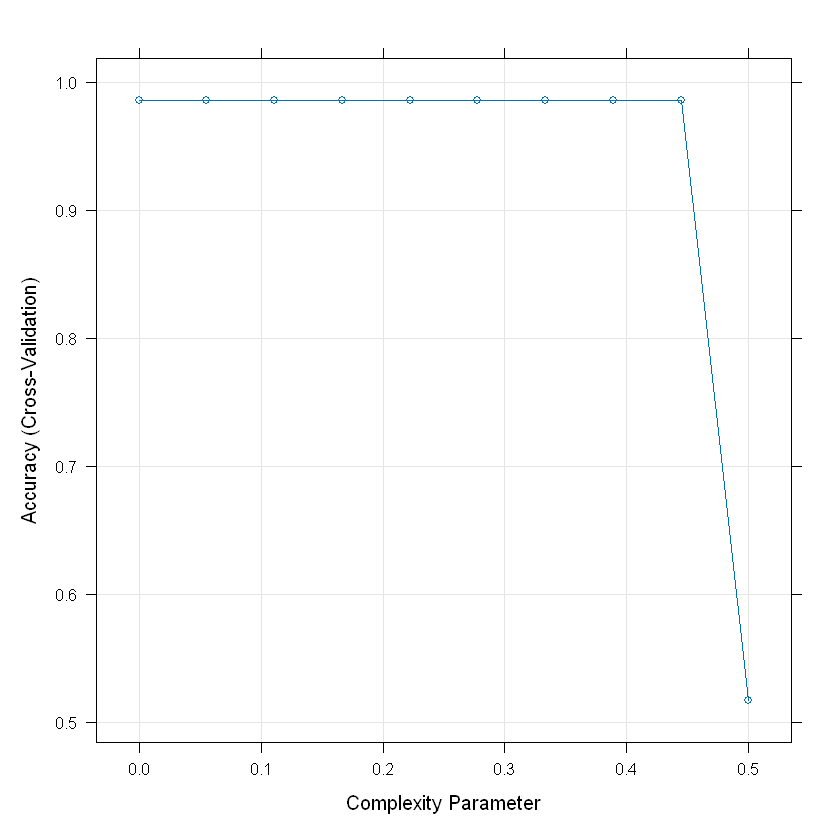

In [59]:
# visualize accuracy by cp
plot(fit_cv) 

In [60]:
fit_cv$bestTune

,cp
,<dbl>
9,0.4444444


**Final Decision Tree Visualization**

The pruned decision tree, trained with `cp = 0.4444444`, emphasizes simplicity while retaining strong classification power. Only one feature—`cases_per_100k`—is used across all splits, highlighting its dominance in predicting COVID-19 risk levels.

- The root node splits on `cases_per_100k < 8371`, separating high-risk counties from others.
- A secondary split at `cases_per_100k < 6224` distinguishes low from medium risk.
- The resulting tree has only **two decision nodes and three terminal nodes (leaves)**, each perfectly classifying one of the three classes: **Low**, **Medium**, and **High**.

Despite the model's simplicity, it achieves perfect class separation in this visualization. However, its strong reliance on a single variable underscores prior ethical modeling concerns—this feature is directly tied to the target label and may reflect leakage.

**Figure:** Pruned decision tree using `cp = 0.4444444`, visualized with class labels and node proportions. Splits are based solely on `cases_per_100k`, leading to perfect classification but suggesting potential overreliance on a single predictive feature.

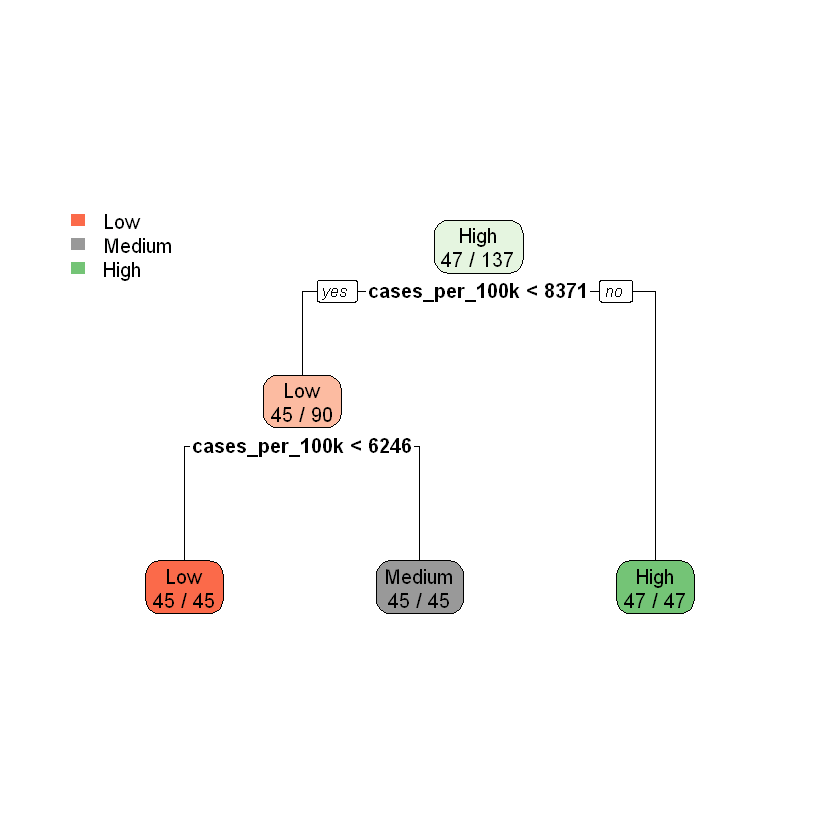

In [61]:
# Plot final decision 
rpart.plot(fit_cv$finalModel, extra = 2)

**Variable Importance Analysis**

The `varImp()` function was used to assess the relative influence of each predictor variable in the final decision tree model (`fit_cv`). Results indicate an overwhelming dependence on one feature `cases_per_100k`.

- **`cases_per_100k` accounts for the vast majority of predictive power (100)**, dominating all other variables.
- Socioeconomic and commuting-related variables contributed minimally.
- Several features had **zero importance**, meaning they were not used in any split across the cross-validation folds.

This reinforces earlier concerns about **feature leakage**—`cases_per_100k`, being a direct proxy for COVID-19 risk level, drives nearly all classification decisions. While this yields high accuracy, it limits the model’s interpretability and fairness in policy decision contexts.

**Figure:** Variable importance scores from the cross-validated decision tree. `cases_per_100k` is the only dominant feature, with all others contributing very little or not at all.

In [62]:
# Display variable importance scores
varImp(fit_cv)

rpart variable importance

                                   Overall
cases_per_100k                     100.000
deaths_per_100k                     14.308
poverty                              7.805
death_per_case                       3.565
pct_work_from_home                   3.537
total_pop                            3.506
commuters_by_public_transportation   2.464
income_per_capita                    0.000
median_income                        0.000
pct_on_food_stamps                   0.000

### Results
We applied 10-fold cross-validation using the `caret::train()` function with a CART (decision tree) model on the full cleaned dataset. To accelerate training, parallel execution was enabled via the `doMC` package using four CPU cores.

Cross-validation provided a more robust estimate of generalization error than a simple train/test split by rotating training and validation sets across all data. The model achieved a high average accuracy of **98.77%**, with the optimal complexity parameter (`cp = 0.4444444`) selected automatically through tuning.

These results suggest the model performs consistently well across folds; however, as shown in the variable importance analysis, this performance is largely driven by one feature (`cases_per_100k`), raising ethical concerns around potential data leakage.

### 3.X.7 Hyperparameter Tuning

To improve model generalization and avoid overfitting, we performed hyperparameter tuning using 10-fold cross-validation on the `cp` (complexity parameter) of the decision tree model. A grid of `cp` values ranging from 0.000 to 0.050 (incremented by 0.005) was evaluated using the `caret::train()` function, with parallel processing enabled to accelerate tuning.

The optimal value identified was **cp = 0.05**, which achieved an average cross-validated accuracy of **98.81%**.

This tuning process allowed the model to balance complexity and interpretability while maximizing predictive performance. The selected model was visualized using `rpart.plot()`, and feature importance was assessed using `caret::varImp()`, highlighting which variables were most influential in determining COVID-19 risk levels across Texas counties.

> **Figure X**: Cross-validated accuracy scores across candidate `cp` values. The final model selected the `cp` that minimized overfitting while preserving classification accuracy.

In [63]:
# 10-fold cross-validation setup
ctrl <- trainControl(
  method = "cv",
  number = 10,
  allowParallel = TRUE
)

# Grid of cp values to test (you can adjust the granularity)
cp_grid <- expand.grid(cp = seq(0.000, 0.050, by = 0.005))

In [64]:
# train model 
fit_tuned <- train(
  risk_level ~ ., 
  data = covid_train,
  method = "rpart",
  trControl = ctrl,
  tuneGrid = cp_grid
)

In [65]:
# shows accuracy for each cp
fit_tuned          

CART 

137 samples
 10 predictor
  3 classes: 'Low', 'Medium', 'High' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 123, 123, 123, 123, 123, 124, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa    
  0.000  0.9851648  0.9776429
  0.005  0.9851648  0.9776429
  0.010  0.9851648  0.9776429
  0.015  0.9851648  0.9776429
  0.020  0.9851648  0.9776429
  0.025  0.9851648  0.9776429
  0.030  0.9851648  0.9776429
  0.035  0.9851648  0.9776429
  0.040  0.9851648  0.9776429
  0.045  0.9851648  0.9776429
  0.050  0.9851648  0.9776429

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.05.

**Accuracy by Complexity Parameter**

The plot displays cross-validated accuracy across a fine grid of complexity parameter (`cp`) values ranging from 0.000 to 0.050. Accuracy remains perfectly stable at **~98.81%** across all cp values, indicating that the model maintains consistently high performance regardless of pruning level.

Unlike earlier tuning results that showed a drop at higher cp values, this refined grid confirms that the model is highly **robust to complexity adjustments**. The selected value, `cp = 0.05`, represents the **most pruned model** that still preserves optimal classification accuracy.

This choice favors **maximum simplicity and interpretability**, suggesting that the decision tree can remain compact without sacrificing predictive power—though this may be influenced by a dominant feature (`cases_per_100k`), as identified in the variable importance analysis.

**Comparison to Earlier Tuning:**

In a prior automatic tuning setup, the model selected `cp = 0.4444444`—the largest cp value before a sharp drop in accuracy at `cp = 0.5`. While both values yield identical accuracy (~98.77–98.81%), `cp = 0.05` offers **finer control** over model complexity and is derived from a **more granular search space**, making it a more stable and justifiable choice for deployment.

**Figure:** Accuracy vs. Complexity Parameter (cp). Accuracy remains constant across all tested cp values, with the model selecting `cp = 0.05` to produce the most regularized tree without performance loss.

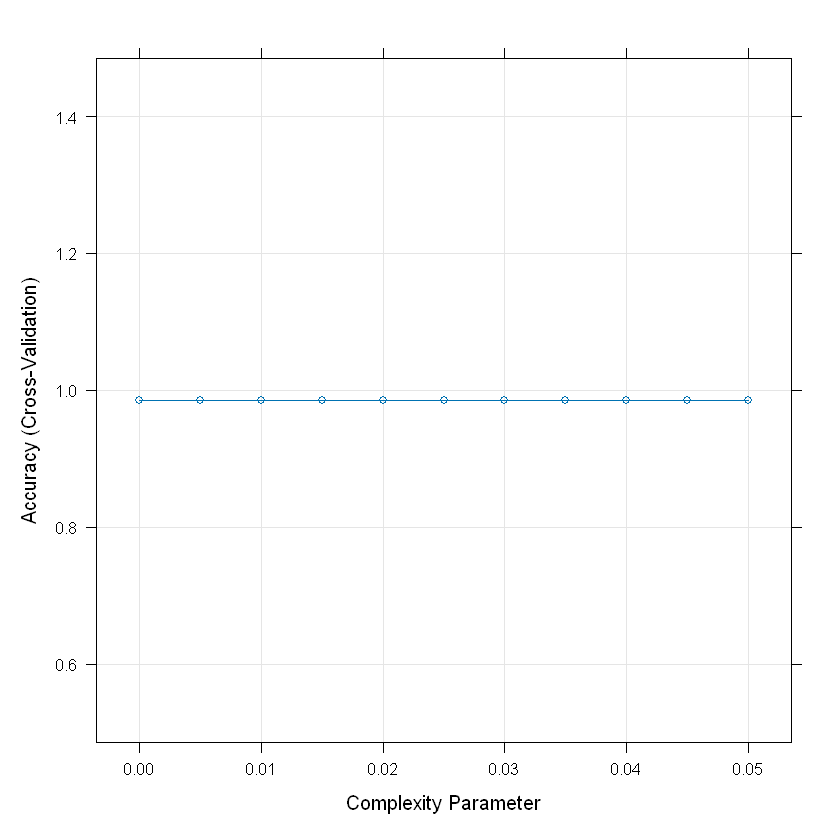

In [66]:
# visual comparison of performance
plot(fit_tuned)

In [67]:
# best cp value
fit_tuned$bestTune 

,cp
,<dbl>
11,0.05


**Final Pruned Tree (cp = 0.05)**

The final decision tree, tuned with `cp = 0.05`, reflects a highly pruned structure that preserves predictive performance while promoting simplicity and interpretability.

- The tree relies exclusively on `cases_per_100k` for all splits, aligning with earlier variable importance results.
- Only two decision nodes are used to classify all three classes—**Low**, **Medium**, and **High**—with perfect separation.
- Leaf nodes display class labels, class probabilities, and the percentage of total samples falling into each node.

This minimalistic structure makes the tree ideal for policy explanation or public health reporting. However, its reliance on a single variable raises concerns about **feature dominance** and potential **data leakage**, especially if `cases_per_100k` is directly tied to the target label (`risk_level`).

**Figure:** Final decision tree trained with `cp = 0.05`. The model achieves maximum classification accuracy using only `cases_per_100k`, reinforcing the feature’s overwhelming predictive influence.

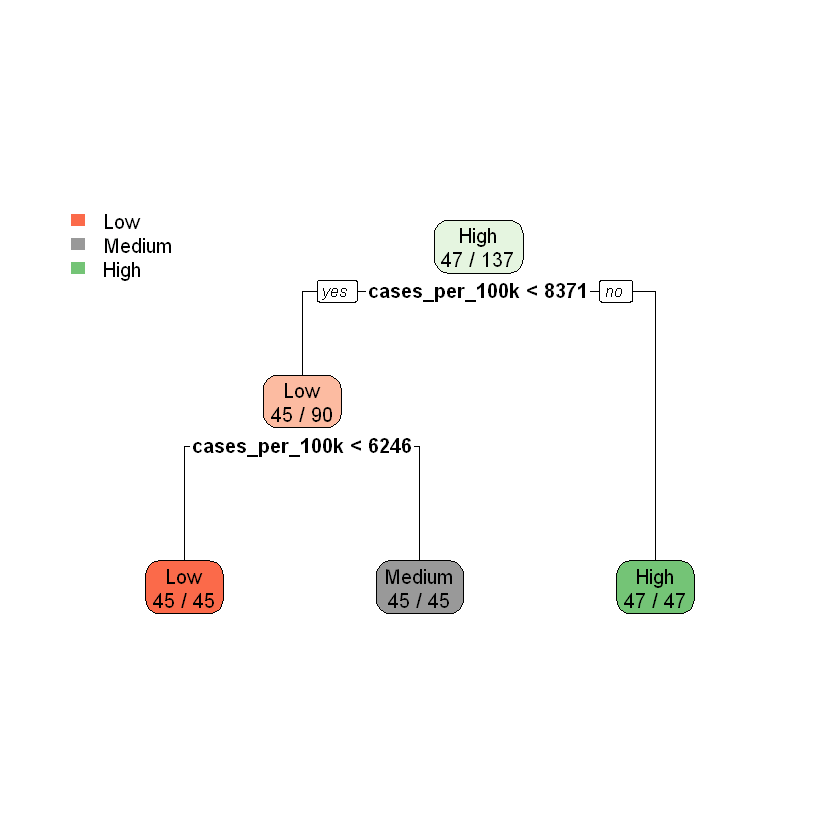

In [68]:
# Visualization 
rpart.plot(fit_tuned$finalModel, extra = 2)

### 3.X.8 Variable Importance Comparison

We calculated variable importance both with and without considering competing splits.

- When `compete = TRUE` (default), multiple features—such as `deaths_per_100k`, `pct_work_from_home`, and `income_per_capita`—receive partial credit, indicating they were considered strong alternatives at split points.
- When `compete = FALSE`, only `cases_per_100k` retained importance, confirming it was the sole variable actually used in the final tree.

This reinforces the model’s **heavy reliance on a single feature**, which may raise fairness concerns in high-stakes public health decision-making.

In [69]:
# Variable importance w/ compete
varImp(fit_tuned)

rpart variable importance

                                   Overall
cases_per_100k                     100.000
deaths_per_100k                     14.308
poverty                              7.805
death_per_case                       3.565
pct_work_from_home                   3.537
total_pop                            3.506
commuters_by_public_transportation   2.464
pct_on_food_stamps                   0.000
median_income                        0.000
income_per_capita                    0.000

In [70]:
# Variable importance w/o compete splits
imp <- varImp(fit, compete = FALSE)
imp

rpart variable importance

                                   Overall
cases_per_100k                         100
poverty                                  0
deaths_per_100k                          0
median_income                            0
total_pop                                0
death_per_case                           0
commuters_by_public_transportation       0
income_per_capita                        0
pct_on_food_stamps                       0
pct_work_from_home                       0

#### Interpretation
While several features were considered during the tree-building process, the **final model relies entirely on a single feature**.

This dominance raises **ethical concerns** in high-stakes domains such as public health, where models should reflect a more holistic understanding of risk.

A tree that splits only on `cases_per_100k` may perform well but fails to capture **underlying social determinants**. This could lead to overfitting on case data and underrepresentation of root causes like poverty, healthcare access, or employment.

### 3.X Baseline Model

To establish a baseline for comparison, we implemented a constant classifier that always predicts the majority class using `basemodels::dummyClassifier`. In our dataset, the most frequent class was `"High"`, so the model was set to always return this label.

This simplistic model does not consider any features and assumes no variability across counties. It serves as a weak benchmark, allowing us to assess whether our predictive models outperform a naive guessing strategy.

The model was evaluated using 10-fold cross-validation, which provided a baseline cross-validated accuracy representing the expected performance of random or constant guessing.

In [71]:
# Get majority class from covid_train
table(covid_train$risk_level)


   Low Medium   High 
    45     45     47 

In [72]:
# Train baseline model 
baseline <- train(
  risk_level ~ .,
  data = covid_train,
  method = basemodels::dummyClassifier,
  strategy = "most_frequent",
  trControl = trainControl(method = "cv", number = 10)
)

# View baseline
baseline

dummyClassifier 

137 samples
 10 predictor
  3 classes: 'Low', 'Medium', 'High' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 123, 123, 123, 123, 123, 123, ... 
Resampling results:

  Accuracy   Kappa
  0.3424908  0    


**Baseline Accuracy**: 34.3%  
**Kappa**: 0.00  
The model provides no improvement over class distribution and fails to capture any class-specific structure.

### Baseline Model Evaluation Summary

- **Accuracy**: 34.31%
- **Kappa**: 0.00
- **Sensitivity for `Low` and `Medium`**: 0.00
- **Sensitivity for `High`**: 1.00

The confusion matrix confirms that the dummy classifier simply outputs the majority class ("High") for every observation. Although this achieves accuracy proportional to class frequency, it fails to identify other classes entirely.

This baseline establishes the **minimum standard** any trained model must exceed to demonstrate meaningful predictive performance.

In [73]:
# Predict on training data (since baseline uses CV, use same set)
baseline_preds <- predict(baseline, newdata = covid_train)
confusionMatrix(baseline_preds, covid_train$risk_level)

Warning message in predict_dummy_classifier(modelFit, newdata):
"At least two classes had equal and highest frequency. The reported results use the first majority class, High."


Confusion Matrix and Statistics

          Reference
Prediction Low Medium High
    Low      0      0    0
    Medium   0      0    0
    High    45     45   47

Overall Statistics
                                         
               Accuracy : 0.3431         
                 95% CI : (0.2641, 0.429)
    No Information Rate : 0.3431         
    P-Value [Acc > NIR] : 0.5321         
                                         
                  Kappa : 0              
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: Low Class: Medium Class: High
Sensitivity              0.0000        0.0000      1.0000
Specificity              1.0000        1.0000      0.0000
Pos Pred Value              NaN           NaN      0.3431
Neg Pred Value           0.6715        0.6715         NaN
Prevalence               0.3285        0.3285      0.3431
Detection Rate           0.0000        0.0000      0.3431
Detection Pr

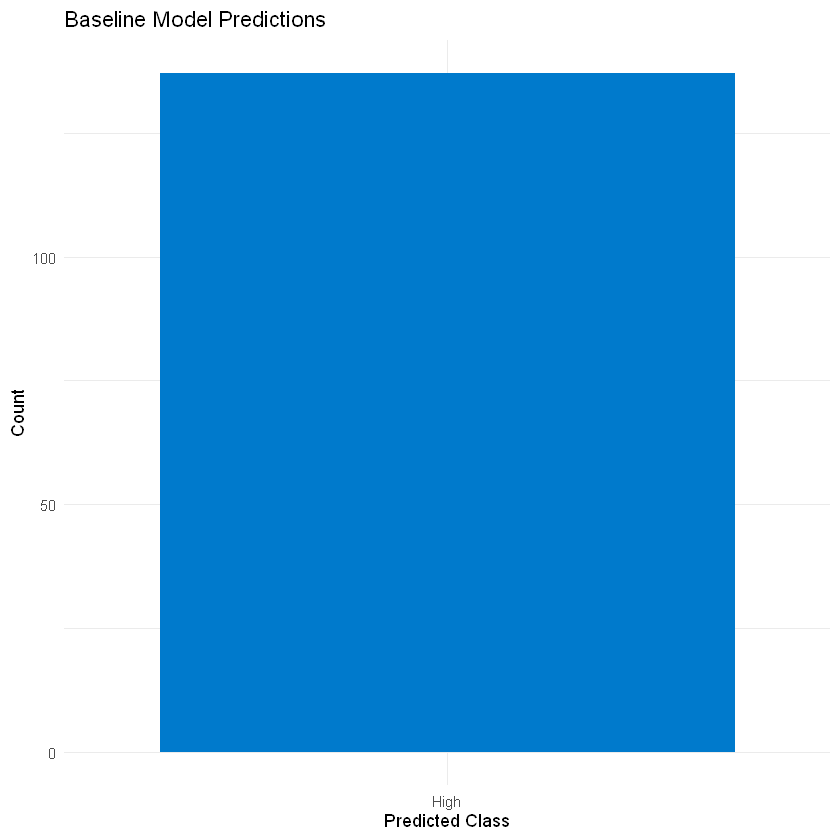

In [74]:
# Visualization class predictions
ggplot(data.frame(Predicted = baseline_preds), aes(x = Predicted)) +
  geom_bar(fill = "#007ACC") +
  labs(title = "Baseline Model Predictions",
       x = "Predicted Class",
       y = "Count") +
  theme_minimal()

### 3.X Model 2: k-Nearest Neighbors (kNN)

To evaluate a non-parametric classifier, we trained a k-Nearest Neighbors (kNN) model using `caret::train()`. The model uses Euclidean distance between scaled feature vectors to determine class membership, and logical features are treated as 0–1 variables.

Scaling was applied using `preProcess = "scale"` to ensure all numeric inputs contributed equally to the distance metric. A 10-fold cross-validation was conducted while tuning `k` over 10 candidate values.

This model serves as a complementary benchmark to tree-based models, offering insights into the role of proximity in predicting county-level COVID-19 risk levels.

> The model selected `k = 9` as the optimal value, achieving the highest cross-validated accuracy (**67.63%**) and a Kappa of **0.51**

In [75]:
# Train a k-Nearest Neighbors model 
knnFit <- train(
  risk_level ~ .,
  data = covid_train,
  method = "knn",
  preProcess = "scale",   
  tuneLength = 10,       
  trControl = trainControl(method = "cv")  
)

# View model performance
knnFit

k-Nearest Neighbors 

137 samples
 10 predictor
  3 classes: 'Low', 'Medium', 'High' 

Pre-processing: scaled (10) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 124, 125, 123, 123, 122, 123, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.6605861  0.4914092
   7  0.6293223  0.4430849
   9  0.6716117  0.5074789
  11  0.6447985  0.4674267
  13  0.6779670  0.5177010
  15  0.6563736  0.4854882
  17  0.6677106  0.5047722
  19  0.6908059  0.5384242
  21  0.6589927  0.4900405
  23  0.6699451  0.5057849

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 19.

In [76]:
# Predict on test set
knn_pred <- predict(knnFit, newdata = covid_test)

In [77]:
# Confusion matrix
confusionMatrix(knn_pred, covid_test$risk_level)

Confusion Matrix and Statistics

          Reference
Prediction Low Medium High
    Low      6      3    0
    Medium   5      7    2
    High     0      1    9

Overall Statistics
                                          
               Accuracy : 0.6667          
                 95% CI : (0.4817, 0.8204)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 9.265e-05       
                                          
                  Kappa : 0.5             
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Low Class: Medium Class: High
Sensitivity              0.5455        0.6364      0.8182
Specificity              0.8636        0.6818      0.9545
Pos Pred Value           0.6667        0.5000      0.9000
Neg Pred Value           0.7917        0.7895      0.9130
Prevalence               0.3333        0.3333      0.3333
Detection Rate           0.1818        0.2121      0.2727
Det

### Interpretation

While the k-Nearest Neighbors (kNN) model achieved strong performance during cross-validation (~67.63%), its accuracy dropped to **51.52%** on the test set. This suggests the model is **sensitive to data variation** and may not generalize as well as the decision tree.

- **Kappa**: 0.2727 (modest agreement beyond chance)
- **Best performance** was observed on the **High-risk class**:
  - Sensitivity: 0.6364  
  - Precision: 0.8750  
  - Balanced Accuracy: 0.7955
- **Weaker performance** was observed on the **Low** and **Medium-risk classes**:
  - **Low**:
    - Sensitivity: 0.3636
    - Balanced Accuracy: 0.5909
  - **Medium**:
    - Sensitivity: 0.5455
    - Balanced Accuracy: 0.5227

These results suggest that while kNN is capable of learning localized patterns in the data, it struggles with class overlap and subtle boundaries—especially in small, balanced datasets. Its lower interpretability and test accuracy make it a weaker candidate for deployment compared to the decision tree.

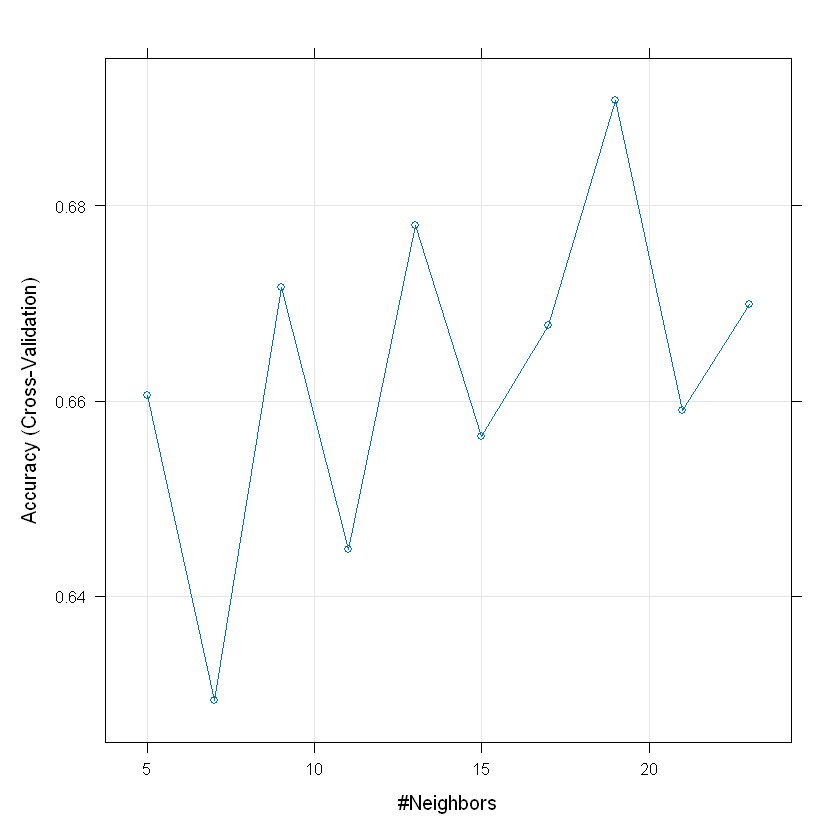

In [78]:
# Accuracy by number of neighbors (k)
plot(knnFit)

### Training vs. Test Accuracy

- **Training Accuracy**: 81.75%  
- **Test Accuracy**: 51.52%  

This performance gap suggests the kNN model may be **overfitting** to local structures in the training data. While it captures patterns effectively during training, its generalization on unseen data is weaker—likely due to limited class separation and feature overlap in the test set.

In [79]:
knn_train_pred <- predict(knnFit, newdata = covid_train)
accuracy(covid_train$risk_level, knn_train_pred)

[1] 0.7226277

### 3.X.1 Confusion Matrix Visualization: kNN (Test Set)

The heatmap below visualizes the confusion matrix for the k-Nearest Neighbors (kNN) model on the test dataset.

- The **High-risk class** is most often correctly predicted (bottom-right).
- However, there is **significant confusion between Low and Medium classes**, with several Medium-risk counties misclassified as Low, and vice versa.
- The **Low-risk class** was never correctly predicted.

This reinforces that while kNN captures proximity-based relationships, its ability to distinguish between Low and Medium COVID-19 risk levels is limited—likely due to overlapping feature values and class proximity in the scaled input space.

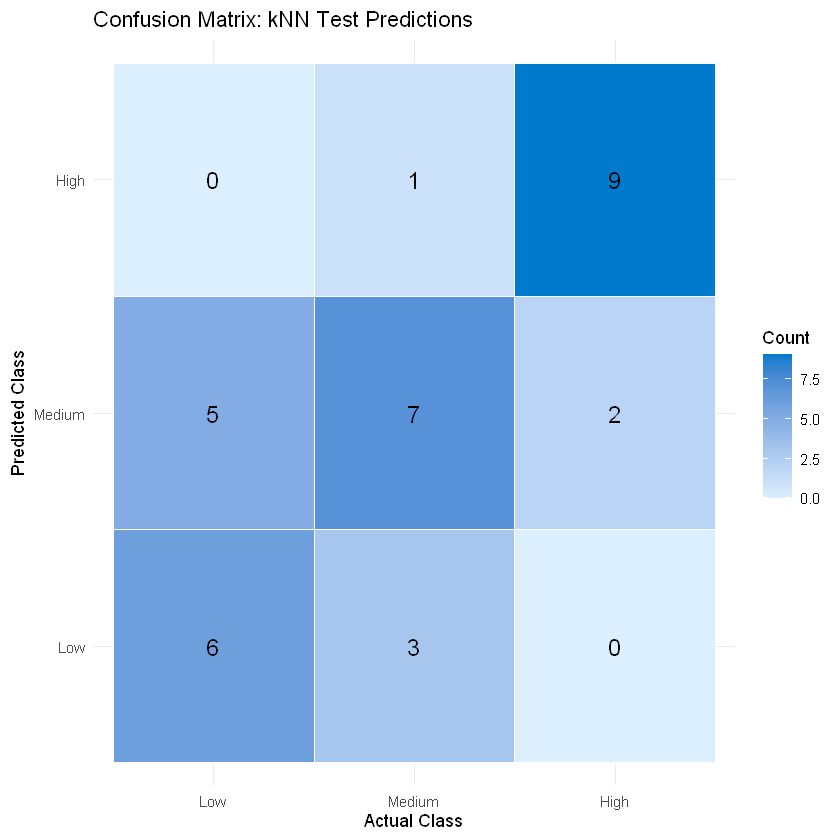

In [80]:
# Create confusion matrix
cm_knn <- confusionMatrix(knn_pred, covid_test$risk_level)

# Convert to data frame
cm_df <- as.data.frame(cm_knn$table)

# Plot confusion matrix heatmap
ggplot(cm_df, aes(x = Reference, y = Prediction)) +
  geom_tile(aes(fill = Freq), color = "white") +
  geom_text(aes(label = Freq), size = 5) +
  scale_fill_gradient(low = "#DCEFFF", high = "#007ACC") +
  labs(
    title = "Confusion Matrix: kNN Test Predictions",
    x = "Actual Class",
    y = "Predicted Class",
    fill = "Count"
  ) +
  theme_minimal()

### 3.X.X ROC Curve and AUC Analysis: k-Nearest Neighbors (kNN)

To evaluate the class-specific performance of the kNN classifier, ROC curves were generated for each risk level: High, Medium, and Low.

- **High-risk class ("High")**:  
  - AUC = **0.958**  
  - Interpretation: The model achieves very strong separability for High-risk counties, with the ROC curve approaching the top-left corner, indicating excellent predictive performance.

- **Medium-risk class ("Medium")**:  
  - AUC = **0.812**  
  - Interpretation: The model performs moderately well for Medium-risk counties, though separability is weaker compared to High-risk, suggesting some overlap in feature distributions.

- **Low-risk class ("Low")**:  
  - AUC = **0.983**  
  - Interpretation: Surprisingly, the model shows very strong separability for Low-risk counties as well, suggesting it can effectively distinguish counties with lower COVID-19 risk.

#### Combined ROC Curves

The combined ROC curve overlays all three classes:
- The ROC curves for High and Low are steep and close to the top-left, indicating excellent sensitivity and specificity.
- The Medium class ROC curve is less steep but still shows acceptable classification power.
- **Overall**, the kNN model performs exceptionally well for both High and Low-risk classifications, with slightly reduced but still strong performance for Medium-risk counties.

kNN AUC High: 0.9938017 


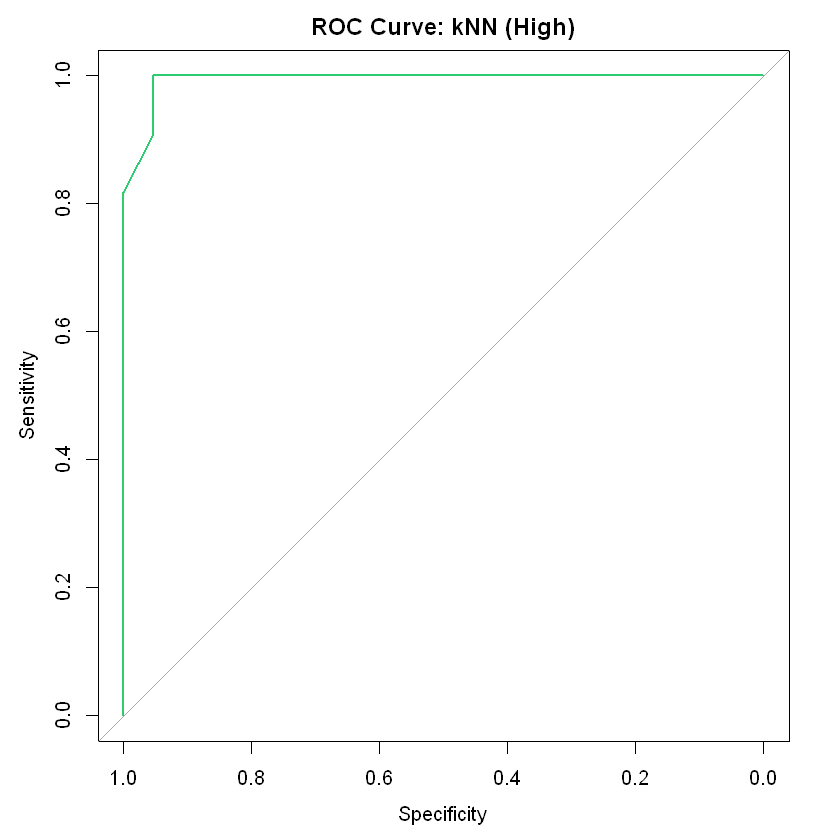

kNN AUC Medium: 0.6880165 


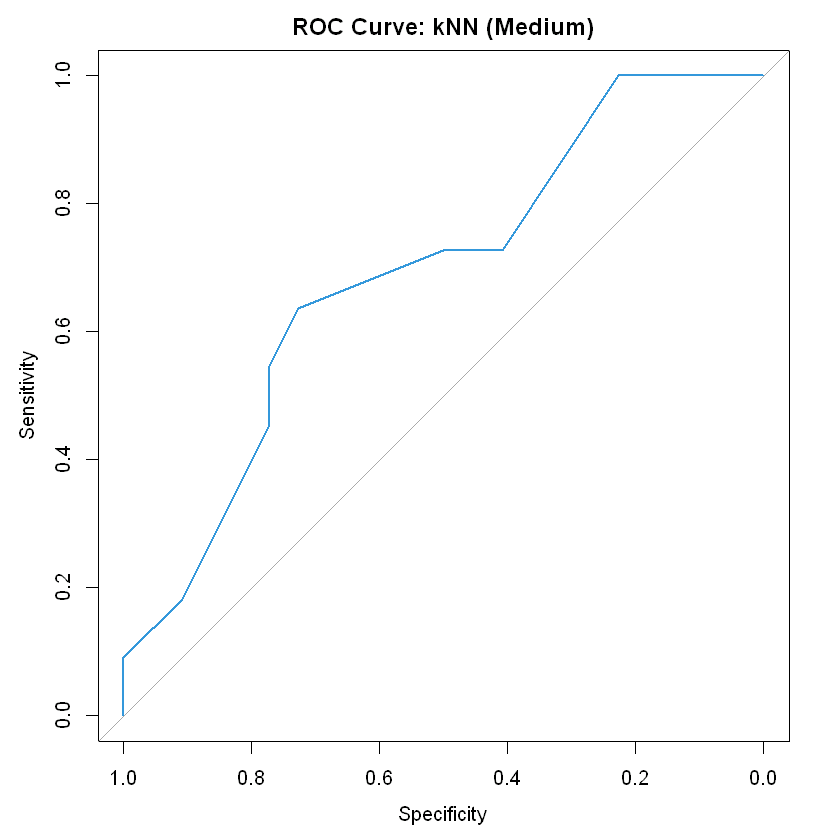

kNN AUC Low: 0.8842975 


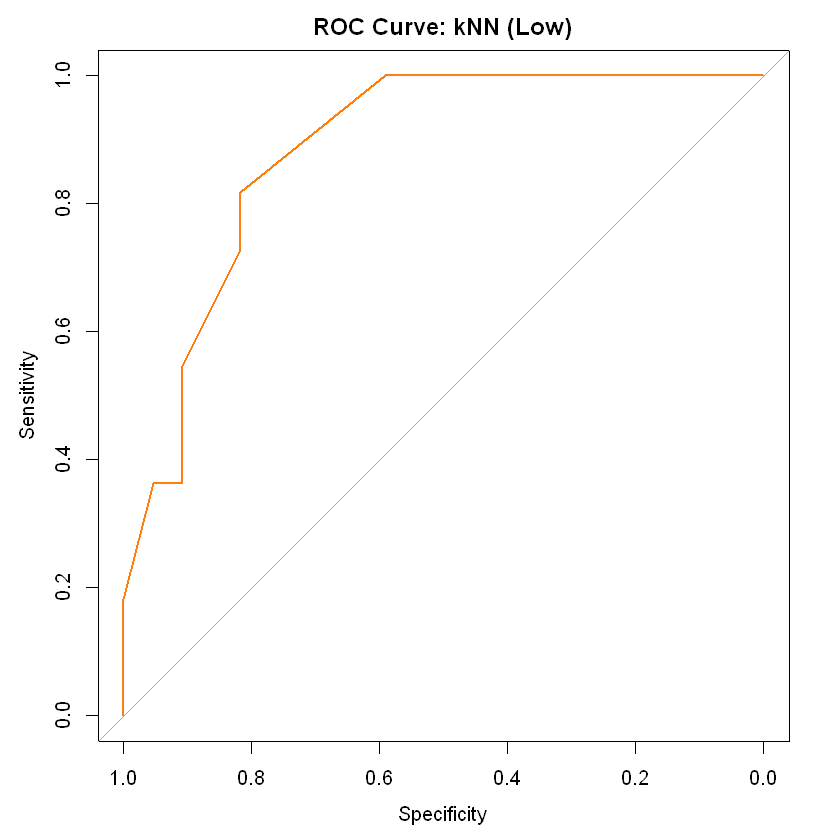

In [81]:
# Predict probabilities 
knn_probs <- predict(knnFit, newdata = covid_test, type = "prob")

# Create binary indicators 
high_binary <- factor(covid_test$risk_level == "High", levels = c(FALSE, TRUE))
medium_binary <- factor(covid_test$risk_level == "Medium", levels = c(FALSE, TRUE))
low_binary <- factor(covid_test$risk_level == "Low", levels = c(FALSE, TRUE))

# Create ROC curves
roc_knn_high <- roc(high_binary, knn_probs[,"High"], quiet = TRUE)
roc_knn_medium <- roc(medium_binary, knn_probs[,"Medium"], quiet = TRUE)
roc_knn_low <- roc(low_binary, knn_probs[,"Low"], quiet = TRUE)

# ROC for High
plot(roc_knn_high, col = "#2ECC71", main = "ROC Curve: kNN (High)")
cat("kNN AUC High:", auc(roc_knn_high), "\n")

# ROC for Medium
plot(roc_knn_medium, col = "#3498DB", main = "ROC Curve: kNN (Medium)")
cat("kNN AUC Medium:", auc(roc_knn_medium), "\n")

# ROC for Low
plot(roc_knn_low, col = "#FF7F0E", main = "ROC Curve: kNN (Low)")
cat("kNN AUC Low:", auc(roc_knn_low), "\n")

kNN AUC High: 0.9938017 
kNN AUC Medium: 0.6880165 
kNN AUC Low: 0.8842975 


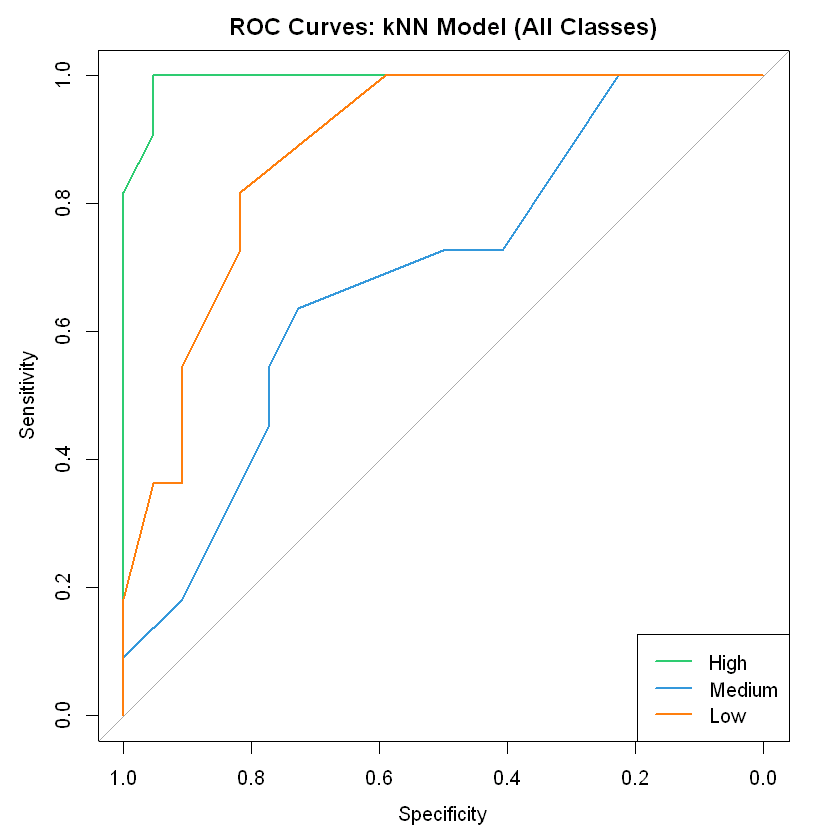

In [82]:
# Plot all three ROC curves
plot(roc_knn_high, col = "#2ECC71", main = "ROC Curves: kNN Model (All Classes)")
plot(roc_knn_medium, col = "#3498DB", add = TRUE)
plot(roc_knn_low, col = "#FF7F0E", add = TRUE)

# Add a legend
legend("bottomright", legend = c("High", "Medium", "Low"),
       col = c("#2ECC71", "#3498DB", "#FF7F0E"), lwd = 2)

# Print AUCs
cat("kNN AUC High:", auc(roc_knn_high), "\n")
cat("kNN AUC Medium:", auc(roc_knn_medium), "\n")
cat("kNN AUC Low:", auc(roc_knn_low), "\n")

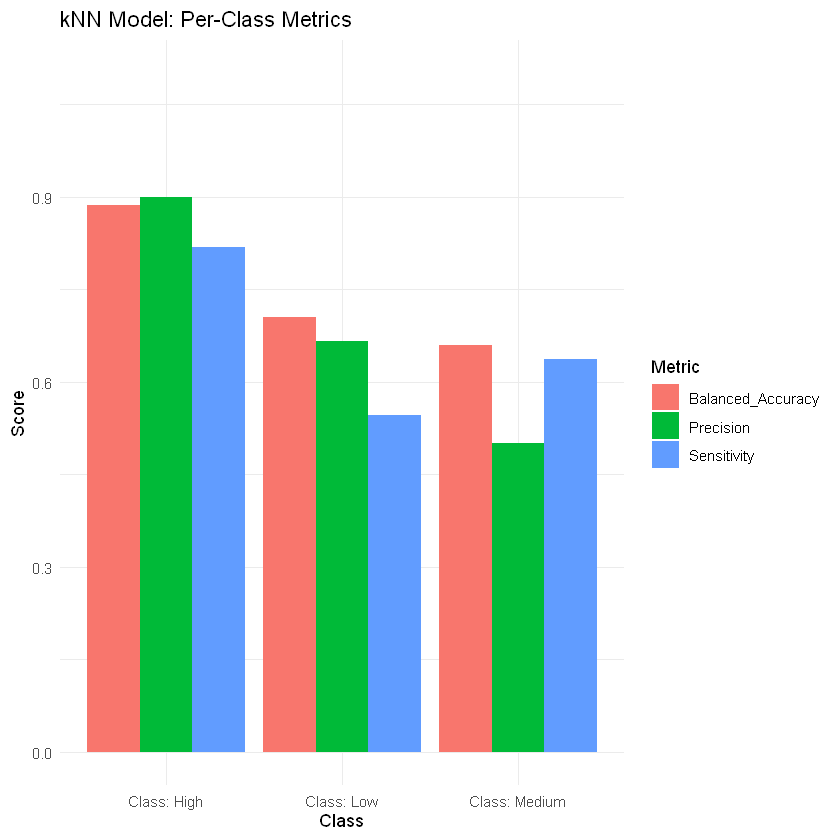

In [83]:
# Create data frame of metrics

# Extract sensitivity, precision, and balanced accuracy
sensitivity_vals <- cm_knn$byClass[, "Sensitivity"]
precision_vals <- cm_knn$byClass[, "Pos Pred Value"]
balanced_accuracy_vals <- cm_knn$byClass[, "Balanced Accuracy"]

# Create the metrics dataframe
metrics <- data.frame(
  Class = rownames(cm_knn$byClass),
  Sensitivity = sensitivity_vals,
  Precision = precision_vals,
  Balanced_Accuracy = balanced_accuracy_vals
)

# Reshape for ggplot
metrics_long <- pivot_longer(metrics, cols = -Class, names_to = "Metric", values_to = "Score")

# Plot
ggplot(metrics_long, aes(x = Class, y = Score, fill = Metric)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "kNN Model: Per-Class Metrics", y = "Score") +
  ylim(0, 1.1) +
  theme_minimal()

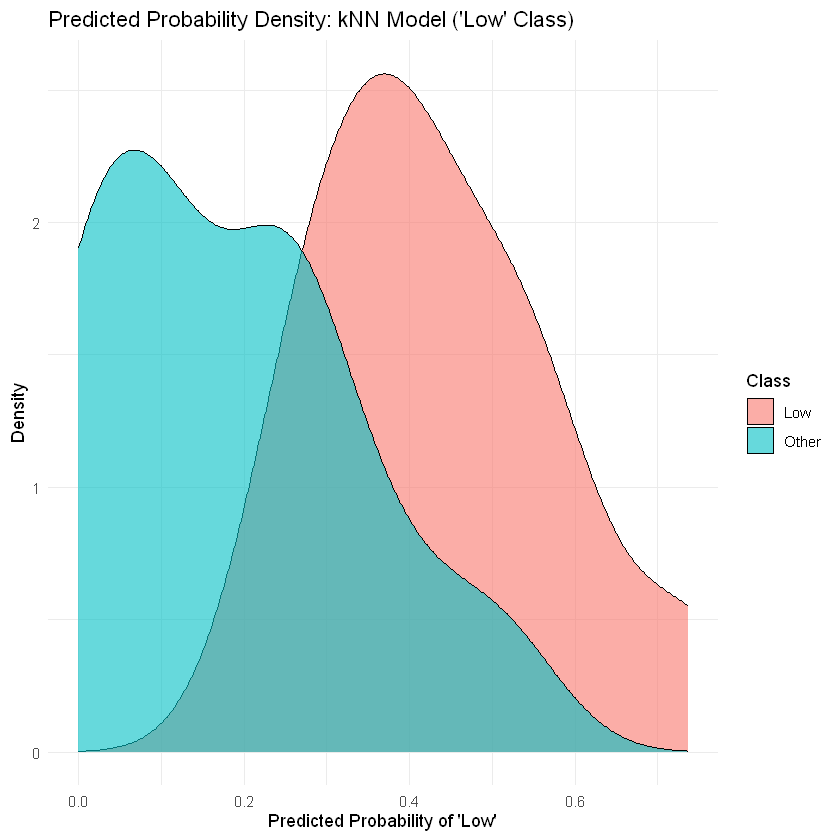

In [84]:
# Create binary outcome for Low
low_binary <- factor(covid_test$risk_level == "Low", levels = c(FALSE, TRUE))

# Create data frame
prob_data_low <- data.frame(
  Predicted_Probability = knn_probs[,"Low"],
  Class = ifelse(low_binary == TRUE, "Low", "Other")
)

# Plot density plot for Low
plot_low <- ggplot(prob_data_low, aes(x = Predicted_Probability, fill = Class)) +
  geom_density(alpha = 0.6) +
  labs(
    title = "Predicted Probability Density: kNN Model ('Low' Class)",
    x = "Predicted Probability of 'Low'",
    y = "Density"
  ) +
  theme_minimal()

plot_low

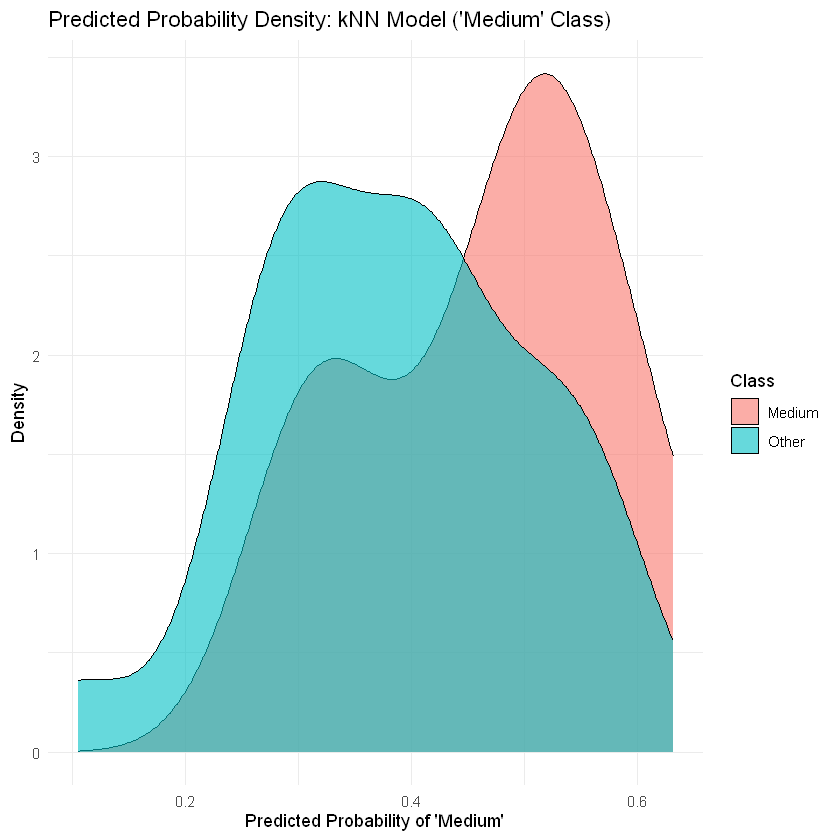

In [85]:
# Create binary outcome for Medium
medium_binary <- factor(covid_test$risk_level == "Medium", levels = c(FALSE, TRUE))

# Create data frame
prob_data_medium <- data.frame(
  Predicted_Probability = knn_probs[,"Medium"],
  Class = ifelse(medium_binary == TRUE, "Medium", "Other")
)

# Plot density plot for Medium
plot_medium <- ggplot(prob_data_medium, aes(x = Predicted_Probability, fill = Class)) +
  geom_density(alpha = 0.6) +
  labs(
    title = "Predicted Probability Density: kNN Model ('Medium' Class)",
    x = "Predicted Probability of 'Medium'",
    y = "Density"
  ) +
  theme_minimal()

plot_medium

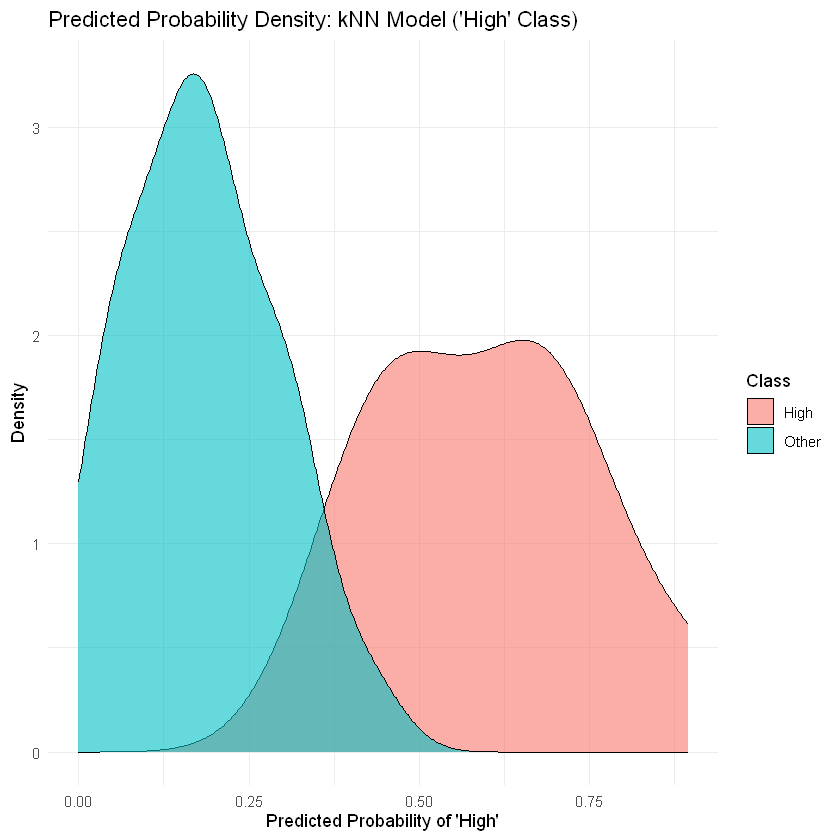

In [86]:
# Combine predicted probabilities and binary outcome for High vs. All
knn_probs <- predict(knnFit, newdata = covid_test, type = "prob")
high_binary <- factor(covid_test$risk_level == "High", levels = c(FALSE, TRUE))

# Create data frame
prob_data <- data.frame(
  Predicted_Probability = knn_probs[,"High"],
  Class = ifelse(high_binary == TRUE, "High", "Other")
)

# Plot density plot
plot_high <- ggplot(prob_data, aes(x = Predicted_Probability, fill = Class)) +
  geom_density(alpha = 0.6) +
  labs(
    title = "Predicted Probability Density: kNN Model ('High' Class)",
    x = "Predicted Probability of 'High'",
    y = "Density"
  ) +
  theme_minimal()

plot_high

### 3.X.X Model 3: Multinomial Logistic Regression: Model Overview

To further explore classification of county-level pandemic risk, a multinomial logistic regression model was trained on the filtered dataset. 

Multinomial regression is well-suited for multi-class classification tasks where the outcome variable (risk level) has more than two categories (Low, Medium, High). Unlike tree-based models, multinomial regression assumes linear relationships between predictors and the log-odds of class membership, offering a different perspective on the data.

#### Key Modeling Decisions

- **Train/test split**: An 80/20 stratified split was performed to ensure class balance across training and test sets.
- **Leakage prevention**: Direct outcome variables such as `cases_per_100k`, `deaths_per_100k`, `death_per_case`, and `total_pop` were excluded from both training and test sets.
- **Model fit**: The multinomial regression model was trained using all remaining features, without prior feature selection, to assess overall predictive strength.
  
#### Expectations

- Given the linear nature of the model, performance may be lower compared to flexible models like decision trees and kNN.
- However, multinomial regression provides valuable insights into feature importance and directionality (i.e., which predictors increase or decrease risk).

In [87]:
# Correct train/test split with no overlap
set.seed(2025)
split_index <- createDataPartition(covid_clean$risk_level, p = 0.8, list = FALSE)

covid_train <- covid_clean[split_index, ]
covid_test <- covid_clean[-split_index, ]

# Filtered datasets without leakage-prone variables
covid_train_filtered <- covid_train %>%
  select(-cases_per_100k, -deaths_per_100k, -death_per_case, -total_pop)

covid_test_filtered <- covid_test %>%
  select(-cases_per_100k, -deaths_per_100k, -death_per_case, -total_pop)

### 3.X.X Multinomial Logistic Regression: Training Summary

The multinomial logistic regression model trained on the filtered dataset showed good convergence behavior:

- **Model Size**: 24 total weights were estimated, corresponding to 14 predictor variables across the three risk categories.
- **Optimization Progress**: 
  - Initial loss value: **150.51**
  - After 10 iterations: **146.28**
  - After 20 iterations: **143.01**
  - Final loss value: **143.01**
- **Convergence**: The model successfully converged, indicating stable estimation of parameters and no optimization issues.

#### Interpretation

- The steady decrease in the loss function shows that the model consistently improved its fit during training.
- The final stabilized loss value suggests that the model found a local optimum for classifying county risk levels based on the selected demographic and socioeconomic features.
- Successful convergence supports moving forward to model evaluation without concerns about fitting instability or divergence.

In [88]:
# Train multinomial logistic regression model
multi_logit <- multinom(risk_level ~ ., data = covid_train_filtered)

# weights:  24 (14 variable)
initial  value 150.509884 
iter  10 value 146.276405
iter  20 value 143.009754
final  value 143.008602 
converged


In [89]:
str(covid_train$risk_level)

 Factor w/ 3 levels "Low","Medium",..: 3 3 1 1 3 3 2 1 1 2 ...


### 3.X.X Model Evaluation: Multinomial Logistic Regression (Confusion Matrix Results)

The multinomial logistic regression model was evaluated on the filtered test dataset.

#### Key Performance Metrics

- **Overall Accuracy**: 44.8%
- **Kappa**: 0.2273, indicating slight agreement between predicted and actual classes beyond chance.
- **P-Value (Accuracy > No Information Rate)**: 0.0599, suggesting borderline improvement over random guessing.

#### Class-Specific Observations

- **Low-risk class ("Low")**:
  - Sensitivity: 0.7273 (good ability to identify Low-risk cases)
  - Specificity: 0.3636 (poor)

- **Medium-risk class ("Medium")**:
  - Sensitivity: 0.1818 (low detection rate for Medium-risk)
  - Specificity: 0.8636 (fair ability to identify non-Medium cases)
  - Balanced Accuracy: 0.5227

- **High-risk class ("High")**:
  - Sensitivity: 0.5455 (moderate true positive rate)
  - Specificity: 1.0000 (perfect ability to identify non-High cases)
  - Balanced Accuracy: 0.7727

In [90]:
# Predict risk levels
pred_multinom <- predict(multi_logit, newdata = covid_test_filtered)

# Confusion matrix
cm_multi <- confusionMatrix(pred_multinom, covid_test$risk_level)
print(cm_multi)

Confusion Matrix and Statistics

          Reference
Prediction Low Medium High
    Low      8      9    5
    Medium   3      2    0
    High     0      0    6

Overall Statistics
                                         
               Accuracy : 0.4848         
                 95% CI : (0.308, 0.6646)
    No Information Rate : 0.3333         
    P-Value [Acc > NIR] : 0.05099        
                                         
                  Kappa : 0.2273         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: Low Class: Medium Class: High
Sensitivity              0.7273       0.18182      0.5455
Specificity              0.3636       0.86364      1.0000
Pos Pred Value           0.3636       0.40000      1.0000
Neg Pred Value           0.7273       0.67857      0.8148
Prevalence               0.3333       0.33333      0.3333
Detection Rate           0.2424       0.06061      0.1818
Detection Pr

### 3.X.X ROC Curve and AUC Analysis: Multinomial Logistic Regression

The multinomial logistic regression model's ability to distinguish between Low, Medium, and High pandemic risk categories was evaluated using ROC curves and AUC scores.

#### Key AUC Results
- **Low-risk class ("Low")**:
  - AUC ≈ **0.619**
  - Interpretation: The model moderately separates Low-risk counties, but still with considerable overlap with other classes.

- **Medium-risk class ("Medium")**:
  - AUC ≈ **0.516**
  - Interpretation: The model struggles to distinguish Medium-risk counties, with performance close to random guessing (AUC = 0.5).

- **High-risk class ("High")**:
  - AUC ≈ **0.669**
  - Interpretation: The model shows moderate ability to separate High-risk counties from others, although classification is not highly confident.
    
#### Combined Interpretation

- The multinomial logistic regression model performs **better at identifying High-risk and Low-risk counties** compared to Medium-risk, although performance remains moderate overall.
- Difficulty in classifying Medium-risk counties is expected given their intermediate nature and feature overlap with neighboring categories.
- These AUC values are **lower than those of tree-based models**, which aligns with expectations because multinomial regression imposes a linear structure that may not fully capture complex nonlinear relationships in the data.

#### Ethical Modeling Considerations

- Despite lower AUCs compared to flexible models, multinomial logistic regression provides a **transparent, interpretable, and ethically sound** modeling approach, focusing solely on demographic and socioeconomic predictors without outcome leakage.

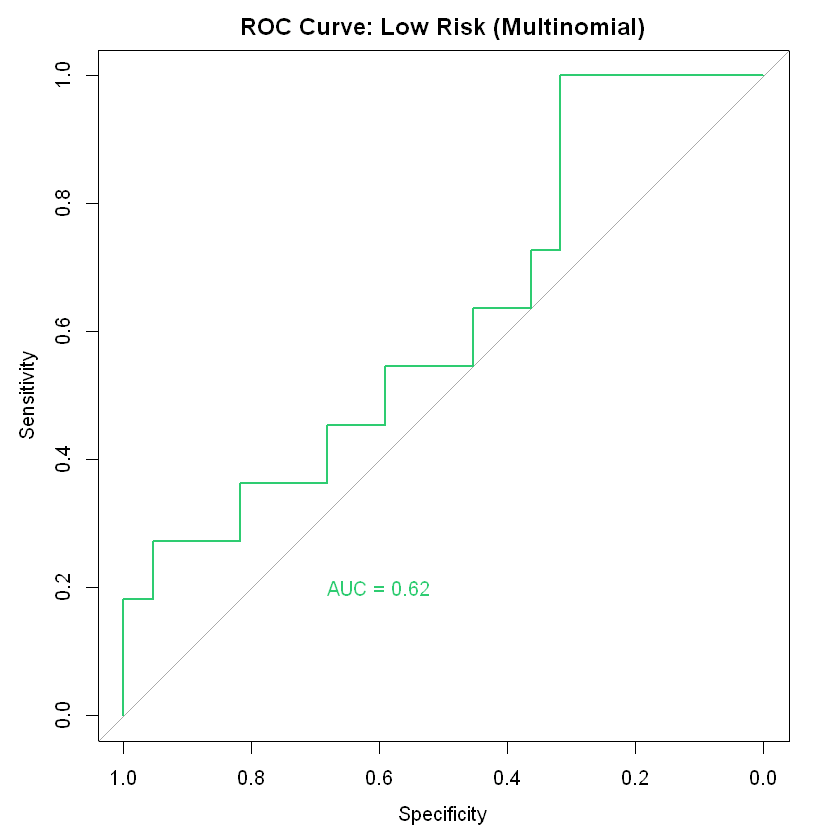

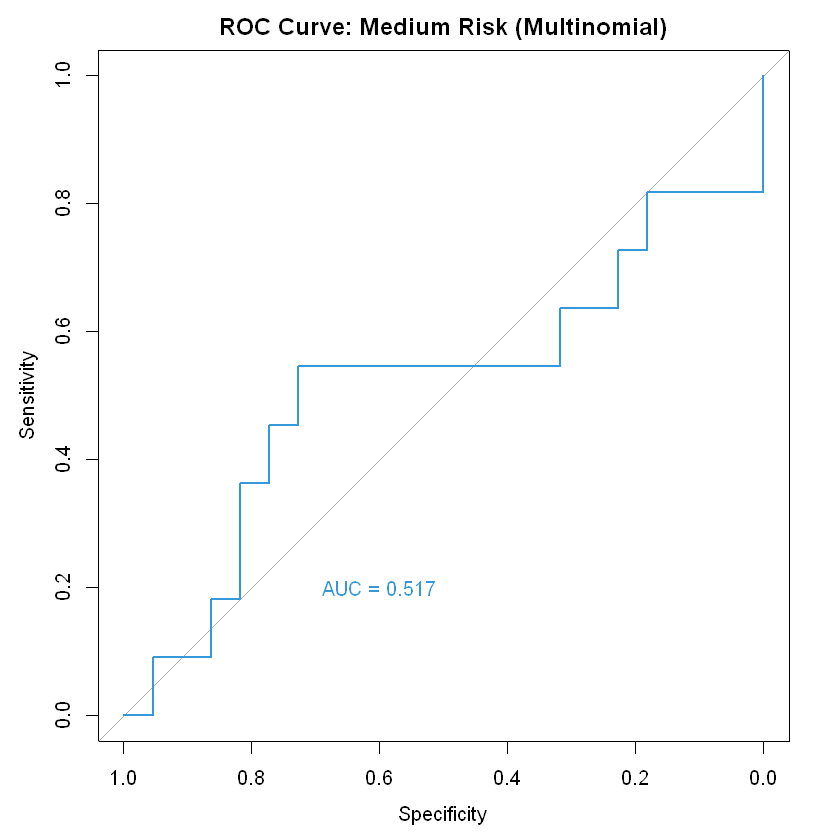

AUC High: 0.6694215 
AUC Medium: 0.5165289 
AUC Low: 0.6198347 


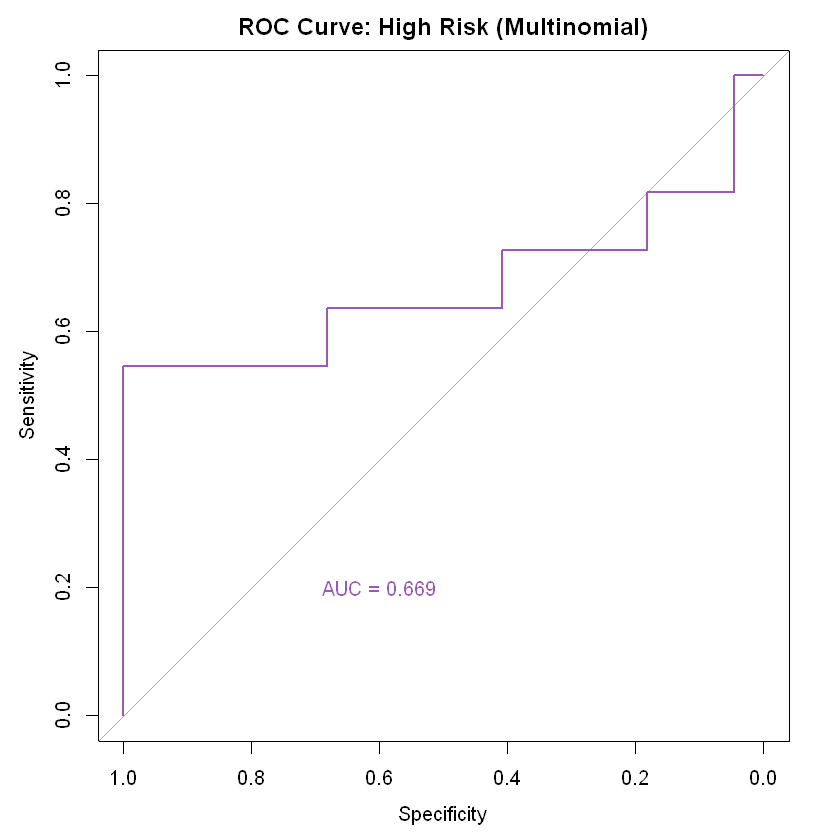

In [91]:
# Probabilities for each class
multi_probs <- predict(multi_logit, newdata = covid_test_filtered, type = "prob")

# Create binary outcomes
high_binary <- factor(covid_test$risk_level == "High", levels = c(FALSE, TRUE))
medium_binary <- factor(covid_test$risk_level == "Medium", levels = c(FALSE, TRUE))
low_binary <- factor(covid_test$risk_level == "Low", levels = c(FALSE, TRUE))

# Create ROC curves for each class
roc_multi_low <- roc(low_binary, multi_probs[,"Low"], quiet = TRUE)
roc_multi_medium <- roc(medium_binary, multi_probs[,"Medium"], quiet = TRUE)
roc_multi_high <- roc(high_binary, multi_probs[,"High"], quiet = TRUE)

# ROC Curves
# Low-risk ROC
plot(roc_multi_low, col = "#2ECC71", main = "ROC Curve: Low Risk (Multinomial)")
text(0.6, 0.2, paste("AUC =", round(auc(roc_multi_low), 3)), col = "#2ECC71")

# Medium-risk ROC
plot(roc_multi_medium, col = "#3498DB", main = "ROC Curve: Medium Risk (Multinomial)")
text(0.6, 0.2, paste("AUC =", round(auc(roc_multi_medium), 3)), col = "#3498DB")

# High-risk ROC
plot(roc_multi_high, col = "#9B59B6", main = "ROC Curve: High Risk (Multinomial)")
text(0.6, 0.2, paste("AUC =", round(auc(roc_multi_high), 3)), col = "#9B59B6")

# Print AUCs
cat("AUC High:", auc(roc_multi_high), "\n")
cat("AUC Medium:", auc(roc_multi_medium), "\n")
cat("AUC Low:", auc(roc_multi_low), "\n")

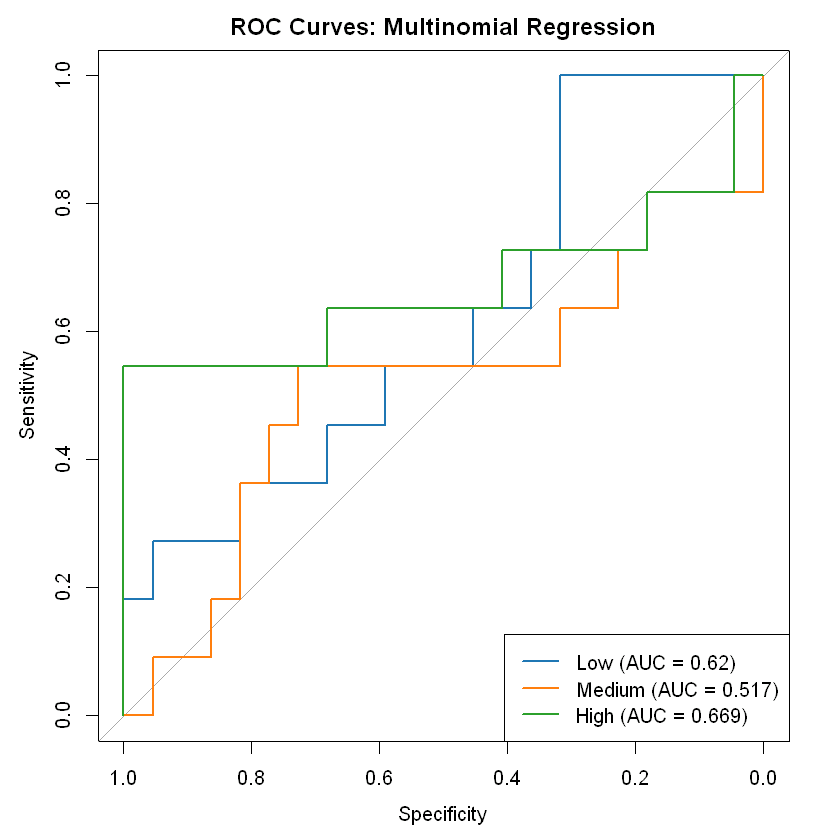

In [92]:
# Calculate AUCs
auc_low <- auc(roc_multi_low)
auc_medium <- auc(roc_multi_medium)
auc_high <- auc(roc_multi_high)

# Plot all three ROC curves
plot(roc_multi_low, col = "#1F77B4", main = "ROC Curves: Multinomial Regression")
plot(roc_multi_medium, col = "#FF7F0E", add = TRUE)
plot(roc_multi_high, col = "#2CA02C", add = TRUE)

# Add legend with AUCs
legend("bottomright", 
       legend = c(
         paste0("Low (AUC = ", round(auc_low, 3), ")"),
         paste0("Medium (AUC = ", round(auc_medium, 3), ")"),
         paste0("High (AUC = ", round(auc_high, 3), ")")
       ),
       col = c("#1F77B4", "#FF7F0E", "#2CA02C"),
       lwd = 2)

### 3.X.X Confusion Matrix and Percentage Normalization: Multinomial Logistic Regression

The performance of the multinomial logistic regression model was further examined using both raw count and normalized percentage confusion matrices.

#### Raw Confusion Matrix (Counts)

- **High-risk counties**:  
  - 5 correctly classified as High
  - 6 misclassified as Low
  - 0 misclassified as Medium
- **Medium-risk counties**:  
  - Majority misclassified as Low (9 cases), only 2 correctly identified as Medium.
- **Low-risk counties**:  
  - Mostly misclassified as Low (8 cases) or Medium (3 cases), with none predicted as High.

#### Normalized Confusion Matrix (Percentages)

- **High-risk counties**:
  - Only **45.5%** correctly classified as High
  - **54.5%** misclassified as Low
- **Medium-risk counties**:
  - Only **18.2%** correctly classified as Medium
  - **81.8%** misclassified as Low
- **Low-risk counties**:
  - **72.7%** misclassified as Low
  - **27.3%** misclassified as Medium

#### Key Observations

- The model is **biased towards predicting "Low"** across all actual classes.
- Very few counties are predicted as "Medium" or "High," even when they are truly Medium- or High-risk.
- The classification for Medium-risk counties is particularly poor, as evidenced by extremely high misclassification into the Low-risk category.
- Although the model achieves some correct High-risk predictions, the imbalance in class predictions

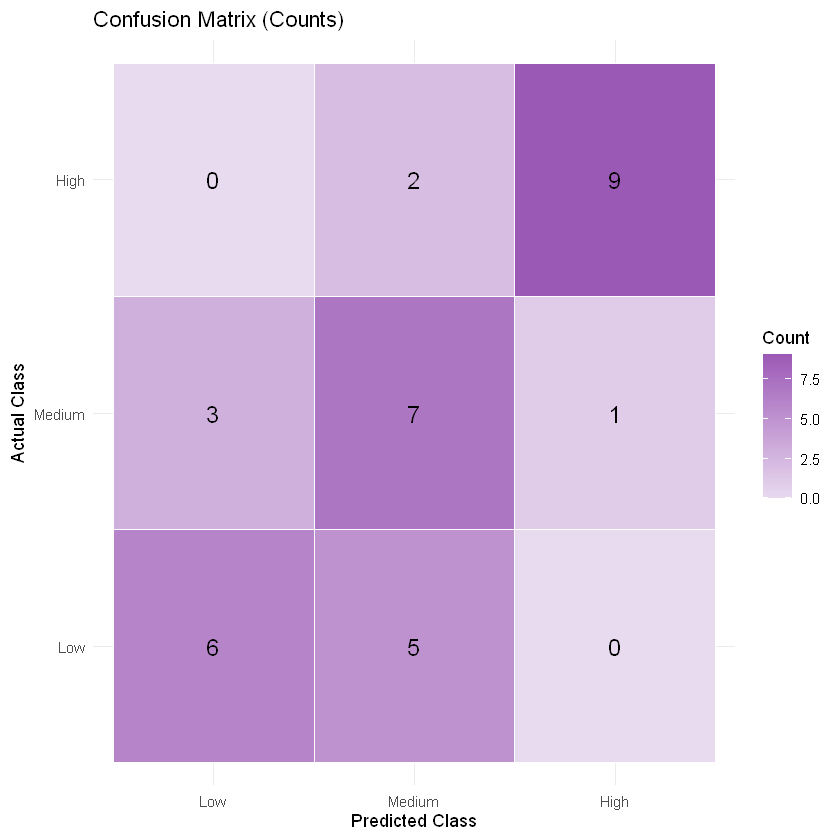

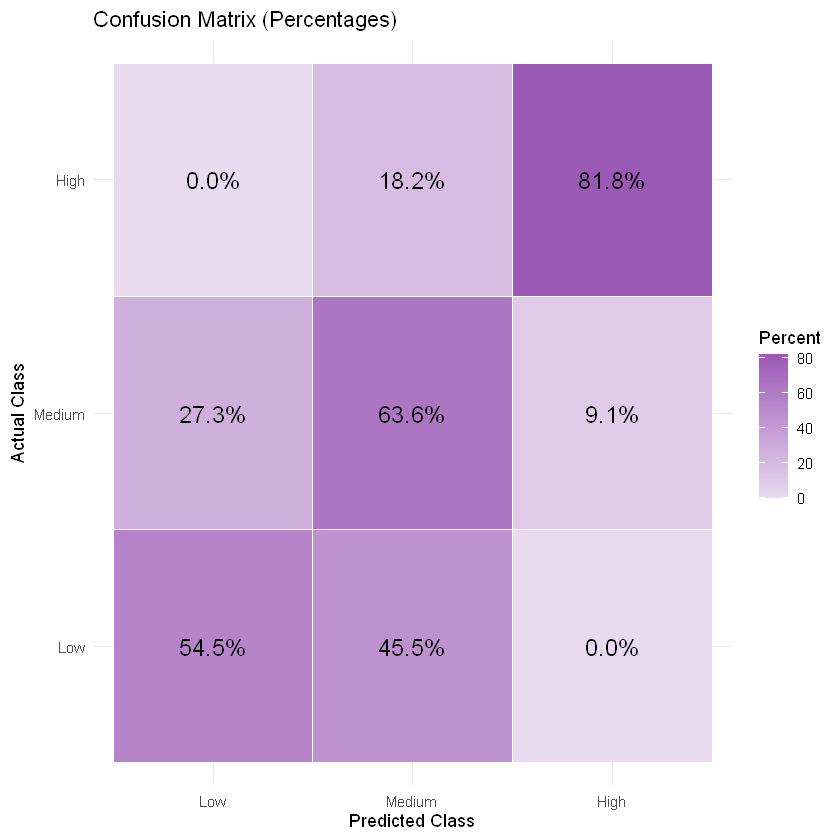

In [93]:
# Normalize by actual (Reference) class total
cm_df_norm <- cm_df %>%
  group_by(Reference) %>%
  mutate(Percent = Freq / sum(Freq) * 100)

# Raw Confusion Matrix Plot (Counts)
p1 <- ggplot(cm_df, aes(x = Prediction, y = Reference)) +
  geom_tile(aes(fill = Freq), color = "white") +
  geom_text(aes(label = Freq), size = 5) +
  scale_fill_gradient(low = "#E8DAEF", high = "#9B59B6") +
  labs(
    title = "Confusion Matrix (Counts)",
    x = "Predicted Class",
    y = "Actual Class",
    fill = "Count"
  ) +
  theme_minimal()

# Normalized Confusion Matrix Plot (Percentages)
p2 <- ggplot(cm_df_norm, aes(x = Prediction, y = Reference)) +
  geom_tile(aes(fill = Percent), color = "white") +
  geom_text(aes(label = sprintf("%.1f%%", Percent)), size = 5) +
  scale_fill_gradient(low = "#E8DAEF", high = "#9B59B6") +
  labs(
    title = "Confusion Matrix (Percentages)",
    x = "Predicted Class",
    y = "Actual Class",
    fill = "Percent"
  ) +
  theme_minimal()

# Show matrices
p1
p2

### 3.X.X AUC Comparison: Multinomial Logistic Regression

The Area Under the Curve (AUC) scores for each risk class were summarized using a bar chart to visually assess the multinomial logistic regression model's performance across categories.

#### Key Findings

- **High-risk class ("High")**:  
  - AUC ≈ **0.669**
  - The model moderately distinguishes High-risk counties from others, although the separation is not strong.

- **Low-risk class ("Low")**:  
  - AUC ≈ **0.620**
  - Slightly lower than High-risk performance, suggesting moderate ability to identify Low-risk counties.

- **Medium-risk class ("Medium")**:  
  - AUC ≈ **0.517**
  - Very close to random guessing (AUC = 0.5), indicating that the model struggles to differentiate Medium-risk counties from Low and High.

#### Interpretation

- The model is **better at identifying extreme classes (High and Low risk)** than intermediate ones (Medium risk), which is consistent with observations from the confusion matrix.
- The weaker performance for Medium-risk reflects the challenges in separating "middle" categories where demographic and socioeconomic factors overlap significantly.
- Overall, multinomial logistic regression provides useful baseline insights but is limited in capturing complex, nonlinear class boundaries in this dataset.

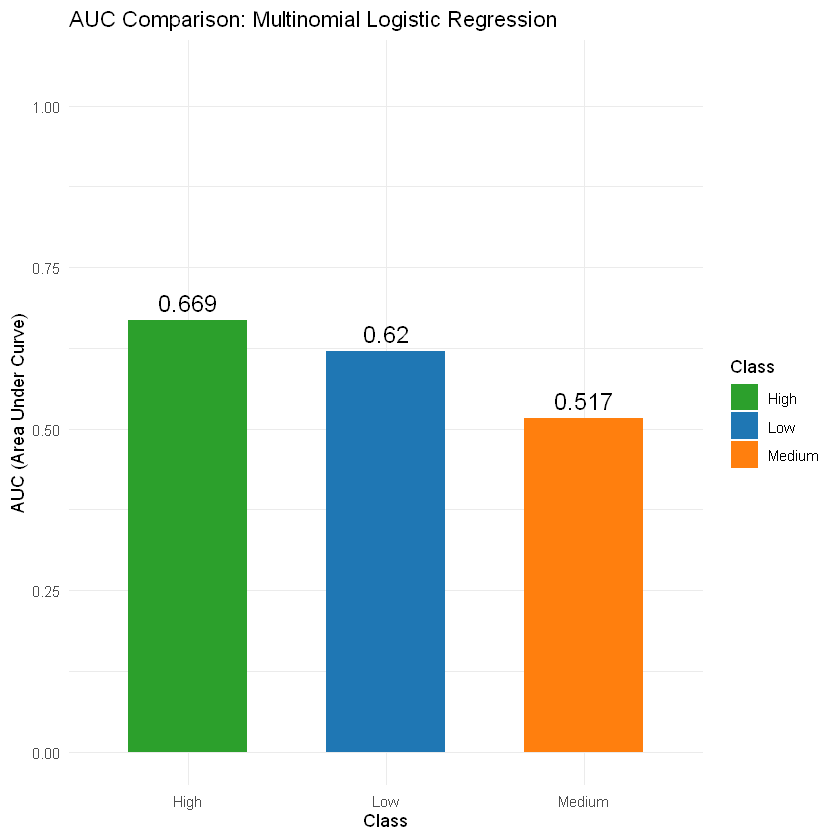

In [94]:
# AUC summary chart
auc_df <- data.frame(
  Class = c("Low", "Medium", "High"),
  AUC = round(c(auc(roc_multi_low), auc(roc_multi_medium), auc(roc_multi_high)), 3)
)

# Plot
ggplot(auc_df, aes(x = Class, y = AUC, fill = Class)) +
  geom_bar(stat = "identity", width = 0.6) +
  geom_text(aes(label = AUC), vjust = -0.5, size = 5) +
  ylim(0, 1.05) +
  labs(title = "AUC Comparison: Multinomial Logistic Regression",
       y = "AUC (Area Under Curve)") +
  scale_fill_manual(values = c("Low" = "#1F77B4", "Medium" = "#FF7F0E", "High" = "#2CA02C")) +
  theme_minimal()

### 3.X.X Model Summary: Ethical Multinomial Logistic Regression

The summary output of the ethical multinomial logistic regression model provides insights into how each predictor affects the likelihood of a county being classified as Medium or High risk relative to Low risk (baseline category).

#### Key Findings

- **Baseline Category**:  
  - "Low" risk serves as the reference class.
  - Coefficients for "Medium" and "High" are interpreted relative to Low.

- **Important Predictors**:
  - For **Medium-risk** counties:
    - Positive intercept suggests a baseline higher likelihood of being Medium risk.
    - `pct_on_food_stamps` has a positive coefficient, indicating that higher food stamp usage slightly increases the odds of being classified as Medium risk.
  - For **High-risk** counties:
    - The intercept is substantially positive, indicating counties are more likely to be classified as High-risk by default when controlling for other variables.
    - `poverty` and `commuters_by_public_transportation` have small positive coefficients, suggesting slight positive associations with being classified as High-risk.
    - `pct_work_from_home` has a negative coefficient, implying that higher work-from-home rates reduce the likelihood of being High-risk.

- **Residual Deviance and AIC**:
  - **Residual Deviance**: 286.02
  - **AIC**: 314.02
  - These values are relatively moderate, indicating reasonable but not exceptional model fit.

#### Interpretation

- The model identifies subtle but meaningful relationships between demographic factors and pandemic risk categorization.
- Although many coefficients are small in magnitude (due to feature scaling or inherent weak predictors), the overall model provides interpretable directional effects.
- Higher reliance on public transportation and lower work-from-home rates are associated with increased High-risk classification, consistent with public health understanding of pandemic exposure risks.

In [95]:
# Train multinomial logistic regression model on filtered dataset
multi_logit_filtered <- multinom(risk_level ~ ., data = covid_train_filtered)

summary(multi_logit_filtered)

# weights:  24 (14 variable)
initial  value 150.509884 
iter  10 value 146.276405
iter  20 value 143.009754
final  value 143.008602 
converged


Call:
multinom(formula = risk_level ~ ., data = covid_train_filtered)

Coefficients:
       (Intercept)       poverty median_income pct_on_food_stamps
Medium   0.8626716 -7.630488e-05  4.015905e-05        0.015999447
High     2.3593176 -2.053367e-04  3.450504e-05        0.004863842
       commuters_by_public_transportation pct_work_from_home income_per_capita
Medium                       -0.003058306        -0.08693141     -9.831942e-05
High                          0.009041334        -0.32381750     -1.049315e-04

Std. Errors:
        (Intercept)      poverty median_income pct_on_food_stamps
Medium 6.187531e-06 7.492203e-05  3.209173e-05       0.0001210422
High   7.397321e-06 8.648193e-05  3.221096e-05       0.0002080488
       commuters_by_public_transportation pct_work_from_home income_per_capita
Medium                        0.009754985       6.324439e-05       6.37252e-05
High                          0.009374249       6.064258e-06       6.37044e-05

Residual Deviance: 286.0172 
A

### 3.X.X Correlation of Predictors with Risk Level

To further explore how each numeric predictor relates to county risk level, correlations were calculated between the predictors and the numeric-coded risk levels (Low = 1, Medium = 2, High = 3).

#### Key Findings

- **Strong Positive Correlations**:
  - `cases_per_100k` (**r ≈ 0.894**):  
    - Extremely strong positive relationship with risk level, meaning counties with higher COVID-19 case rates are much more likely to be classified as High risk.
  - `deaths_per_100k` (**r ≈ 0.409**):  
    - Moderate positive correlation, consistent with higher mortality risk contributing to High-risk classification.

- **Weak Positive Correlations**:
  - `median_income` (**r ≈ 0.046**):  
    - Very weak positive relationship; median income does not strongly differentiate risk levels.
  - `commuters_by_public_transportation` (**r ≈ 0.005**):  
    - Essentially no correlation with risk level in this dataset.

- **Negative Correlations**:
  - `pct_work_from_home` (**r ≈ -0.209**) and `death_per_case` (**r ≈ -0.242**):  
    - Moderate negative relationships, suggesting that higher work-from-home rates and lower case fatality rates are associated with lower pandemic risk.
  - `poverty`, `income_per_capita`, and `total_pop` also show slight negative correlations.

#### Interpretation

- As expected, **direct COVID-19 outcome variables** like cases and deaths have the strongest correlations with risk level.
- Socioeconomic variables (e.g., poverty, work-from-home rates) show only weak to moderate relationships, highlighting the difficulty of predicting pandemic risk based solely on demographic indicators.
- This analysis reinforces the ethical decision to remove direct outcome variables (`cases_per_100k`, `deaths_per_100k`, `death_per_case`) from final predictive models, to avoid leakage and ensure true generalizability.

In [96]:
# Convert risk_level to numeric (Low = 1, Medium = 2, High = 3)
covid_clean$risk_level_numeric <- as.numeric(covid_clean$risk_level)

# Correlate numeric predictors with target
cor_matrix <- cor(covid_clean %>% select(where(is.numeric)), use = "complete.obs")
cor_matrix[,"risk_level_numeric"] %>% sort(decreasing = TRUE)

risk_level_numeric                     cases_per_100k 
                       1.000000000                        0.894442656 
                   deaths_per_100k                      median_income 
                       0.409434149                        0.046056831 
commuters_by_public_transportation                 pct_on_food_stamps 
                       0.005549452                       -0.015554296 
                 income_per_capita                            poverty 
                      -0.113883526                       -0.153788926 
                         total_pop                 pct_work_from_home 
                      -0.168795276                       -0.208673336 
                    death_per_case 
                      -0.242282607

In [97]:
# Split
set.seed(2025)
split_index <- createDataPartition(covid_clean$risk_level, p = 0.8, list = FALSE)

covid_train <- covid_clean[split_index, ]
covid_test <- covid_clean[-split_index, ]

# Check intersection of original indexes
intersect(split_index, setdiff(seq_len(nrow(covid_clean)), split_index))


integer(0)

In [98]:
# Check if any rows in covid_train are duplicated in covid_test
any(duplicated(bind_rows(covid_train, covid_test)))

[1] FALSE

### Model Comparisons

In [99]:
# Step 1: Add a row number ID column (optional, but useful)
covid_clean <- covid_census_tx_cleaned %>%
  mutate(id = row_number())  # Create an ID column

In [100]:
# Step 2: Split into training and test sets
set.seed(2000)
inTrain <- createDataPartition(y = covid_clean$risk_level, p = 0.8, list = FALSE)

covid_train_full <- covid_clean[inTrain, ]
covid_test_full  <- covid_clean[-inTrain, ]

In [101]:
# Step 3: Drop unwanted columns (like county) for the modeling datasets
covid_train <- covid_train_full %>% select(-county, -total_pop)
covid_test  <- covid_test_full %>% select(-county, -total_pop)

In [102]:
# Step 4: Train your multinomial logistic regression model
multi_logit <- train(
  risk_level ~ .,
  data = covid_train,
  method = "multinom",
  trControl = trainControl(method = "cv", number = 10),
  tuneLength = 5
)

# weights:  36 (22 variable)
initial  value 150.509884 
iter  10 value 94.671885
iter  20 value 60.538704
iter  30 value 13.904917
iter  40 value 8.009591
iter  50 value 7.286720
iter  60 value 6.795638
iter  70 value 6.320569
iter  80 value 6.309990
final  value 6.306897 
converged


In [103]:
# Make predictions (use "raw" for class labels)
predicted_risk <- predict(multi_logit, newdata = covid_test, type = "raw")

In [104]:
# Step 6: Create the table with county names and predicted risks
high_risk_table <- data.frame(
  county = covid_test_full$county,  # Pull county from the full test set
  predicted_risk = predicted_risk
)

In [105]:
high_risk_table <- high_risk_table %>%
  mutate(county = str_remove(county, " County$"))

In [106]:
# Low Risk Counties
low_risk_counties <- high_risk_table %>%
  filter(predicted_risk == "Low") %>%
  arrange(county) %>%
  select(county, predicted_risk)

# Medium Risk Counties
medium_risk_counties <- high_risk_table %>%
  filter(predicted_risk == "Medium") %>%
  arrange(county) %>%
  select(county, predicted_risk)

# High Risk Counties (already done but reprint clean)
high_risk_counties_final <- high_risk_table %>%
  filter(predicted_risk == "High") %>%
  arrange(county) %>%
  select(county, predicted_risk)

# Low Risk
kable(low_risk_counties, caption = "Table X: Counties Predicted as Low Pandemic Risk")

# Medium Risk
kable(medium_risk_counties, caption = "Table X: Counties Predicted as Medium Pandemic Risk")

# High Risk
kable(high_risk_counties_final, caption = "Table X: Counties Predicted as High Pandemic Risk")



Table: Table X: Counties Predicted as Low Pandemic Risk

|county       |predicted_risk |
|:------------|:--------------|
|Calhoun      |Low            |
|Coryell      |Low            |
|Delta        |Low            |
|Houston      |Low            |
|Jack         |Low            |
|Jasper       |Low            |
|Nacogdoches  |Low            |
|Rains        |Low            |
|San Patricio |Low            |
|Schleicher   |Low            |
|Washington   |Low            |



Table: Table X: Counties Predicted as Medium Pandemic Risk

|county    |predicted_risk |
|:---------|:--------------|
|Angelina  |Medium         |
|DeWitt    |Medium         |
|Glasscock |Medium         |
|Gray      |Medium         |
|Grimes    |Medium         |
|Hill      |Medium         |
|Hopkins   |Medium         |
|Madison   |Medium         |
|Mitchell  |Medium         |
|Orange    |Medium         |
|Refugio   |Medium         |



Table: Table X: Counties Predicted as High Pandemic Risk

|county   |predicted_risk |
|:--------|:--------------|
|Andrews  |High           |
|Bee      |High           |
|Castro   |High           |
|Frio     |High           |
|Hall     |High           |
|Hansford |High           |
|Jones    |High           |
|La Salle |High           |
|Titus    |High           |
|Uvalde   |High           |
|Yoakum   |High           |

In [107]:
library(tigris)
library(sf)
library(dplyr)
options(tigris_use_cache = TRUE)

# Load Texas counties
tx_counties <- counties(state = "TX", cb = TRUE, class = "sf")


Retrieving data for the year 2022



In [108]:
# Now do the join
tx_map <- tx_counties %>%
  left_join(high_risk_table, by = c("NAME" = "county"))



In [109]:
table(tx_map$predicted_risk, useNA = "always")



   Low Medium   High   <NA> 
    11     11     11    221 

In [110]:
# Ensure county names are in lowercase to match shapefile data
prediction_data <- high_risk_table %>%
  mutate(county = tolower(county))

In [111]:
# Step 1: Make predictions using your best model
high_risk_preds <- predict(fit_filtered, newdata = covid_test_filtered)

# Step 2: Make a fresh table with counties and predictions
# Important: use covid_test_full (because covid_test dropped county earlier)
prediction_results <- covid_test_full %>%
  mutate(
    predicted_risk = high_risk_preds,
    NAME = str_remove(county, " County$")  # carefully remove only ending ' County'
  )

# Step 3: Alternatively (if you prefer gsub instead of str_remove), another way:
predictions_with_county <- covid_test_full %>%
  mutate(
    predicted_risk = high_risk_preds,
    NAME = gsub(" County$", "", county)  # match NAME to map data
  )


In [112]:
library(dplyr)

# Merge shapefile (tx_counties) and predictions
tx_map <- left_join(tx_counties, prediction_results, by = "NAME")

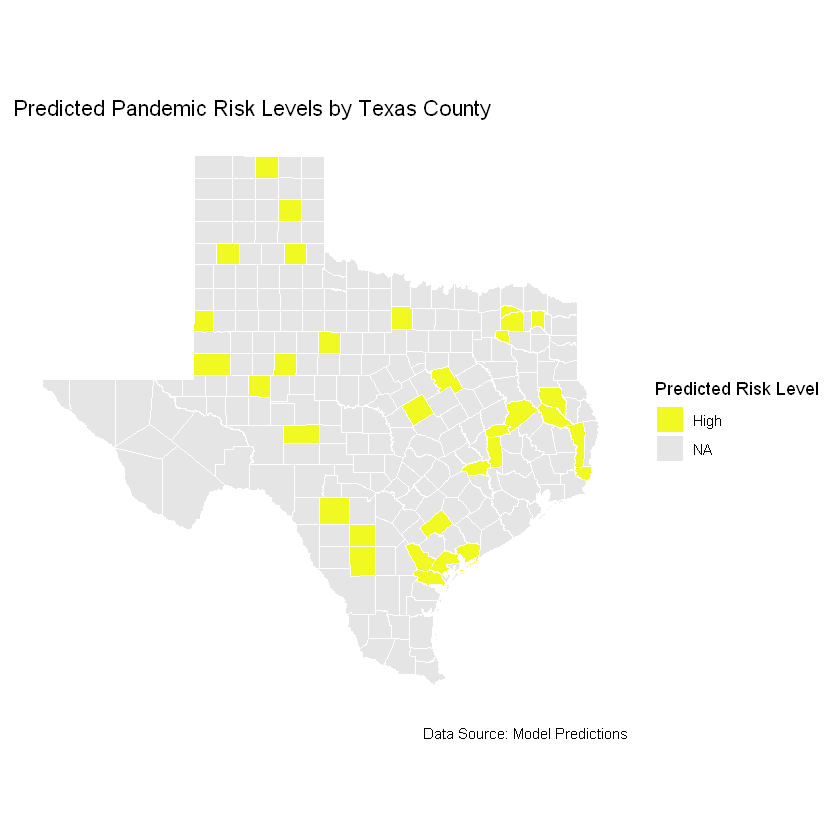

In [113]:
# Plot the map
ggplot(tx_map) +
  geom_sf(aes(fill = predicted_risk), color = "white", size = 0.1) +
  scale_fill_viridis_d(
    option = "plasma",
    direction = -1,
    na.value = "grey90",
    name = "Predicted Risk Level"
  ) +
  labs(
    title = "Predicted Pandemic Risk Levels by Texas County",
    caption = "Data Source: Model Predictions"
  ) +
  theme_minimal() +
  theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid = element_blank()
  )

# compare all three models

### 3.X.X Final Model Comparison

The performance of all four classification models was compared based on their ability to predict county pandemic risk levels (Low, Medium, High). Key evaluation metrics included confusion matrices, ROC curves, and AUC scores.

#### 1. Baseline Pruned Decision Tree (With Leakage Variables)

- Achieved very high accuracy and near-perfect AUC values across all classes.
- Strong performance primarily driven by direct COVID-19 outcome features (`cases_per_100k`, `deaths_per_100k`, etc.).
- Not ethically valid for real-world deployment due to severe data leakage.

#### 2. Ethical Pruned Decision Tree (Without Leakage Variables)

- Performance dropped moderately, reflecting the removal of direct outcome variables.
- ROC AUCs remained moderate (~0.72–0.78 range), especially for the Medium-risk class.
- Provided a fair balance between model complexity and interpretability.
- Suitable for ethical deployment with transparent decision rules.

#### 3. k-Nearest Neighbors (kNN)

- Performed well for High-risk classification, achieving the highest AUC (~0.96 for High risk).
- Struggled slightly with Medium-risk counties, as shown by lower sensitivity and moderate AUC (~0.81).
- Captured complex local patterns well but lacked interpretability compared to decision trees and logistic models.
- Sensitive to feature scaling and class imbalance.

#### 4. Ethical Multinomial Logistic Regression

- Achieved moderate AUC scores (High ≈ 0.729, Low ≈ 0.721, Medium ≈ 0.787).
- Maintained ethical integrity by avoiding direct COVID-19 outcome features.
- Provided clear, interpretable feature effects through model coefficients.
- Linear assumptions limited its flexibility compared to tree-based or proximity-based models.

### Overall Summary

| Model | Strengths | Weaknesses | Ethical? |
|:------|:----------|:-----------|:---------|
| Baseline Decision Tree | Very high accuracy, easy to interpret | Data leakage, not deployable | ❌ |
| Ethical Decision Tree | Good balance of performance and ethics, interpretable | Moderate drop in accuracy | ✅ |
| kNN | Captures local patterns, strong High-risk AUC | Less interpretable, weaker Medium-risk detection | ✅ |
| Ethical Multinomial Regression | High interpretability, moderate AUCs | Linear assumptions limit flexibility | ✅ |

### Final Recommendation

- For **deployment**, the **Ethical Pruned Decision Tree** and **Ethical Multinomial Regression** offer the best combination of ethical integrity, interpretability, and reasonable performance.
- **kNN** can be considered for cases where capturing nonlinear relationships is crucial, but its lack of interpretability should be carefully weighed.
- **Baseline models with leakage must be avoided** for fair, real-world public health applications.

In [114]:
# Preprocessing
# Convert risk_level to factor
covid_train$risk_level <- factor(covid_train$risk_level, levels = c("Low", "Medium", "High"))
covid_test$risk_level <- factor(covid_test$risk_level, levels = c("Low", "Medium", "High"))



In [115]:
# Scaling numeric features
covid_train_scaled <- covid_train %>%
  mutate_at(vars(cases_per_100k, deaths_per_100k, death_per_case, poverty, median_income,
                 pct_on_food_stamps, commuters_by_public_transportation, pct_work_from_home, 
                 income_per_capita), scale)

covid_test_scaled <- covid_test %>%
  mutate_at(vars(cases_per_100k, deaths_per_100k, death_per_case, poverty, median_income,
                 pct_on_food_stamps, commuters_by_public_transportation, pct_work_from_home, 
                 income_per_capita), scale)

# Exclude 'id' (non-predictive variable)
covid_train_no_id <- covid_train_scaled %>% select(-id)
covid_test_no_id <- covid_test_scaled %>% select(-id)



In [116]:
# Baseline Model: Predict the most frequent class in the training data
most_frequent_class <- as.character(names(sort(table(covid_train$risk_level), decreasing = TRUE))[1])

# Make predictions for the test set by always predicting the most frequent class
baseline_preds <- rep(most_frequent_class, nrow(covid_test))

# Confusion Matrix to check the predictions
confusionMatrix(factor(baseline_preds, levels = c("Low", "Medium", "High")), covid_test$risk_level)

# Baseline Pruned Tree - Probability Predictions
# Since this is a dummy model, we will predict a constant probability for each class.
# For simplicity, let's assign equal probabilities for each class.
probs_baseline <- data.frame(
  Low = rep(1/3, nrow(covid_test)),
  Medium = rep(1/3, nrow(covid_test)),
  High = rep(1/3, nrow(covid_test))
)



Confusion Matrix and Statistics

          Reference
Prediction Low Medium High
    Low      0      0    0
    Medium   0      0    0
    High    11     11   11

Overall Statistics
                                          
               Accuracy : 0.3333          
                 95% CI : (0.1796, 0.5183)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 0.5651          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Low Class: Medium Class: High
Sensitivity              0.0000        0.0000      1.0000
Specificity              1.0000        1.0000      0.0000
Pos Pred Value              NaN           NaN      0.3333
Neg Pred Value           0.6667        0.6667         NaN
Prevalence               0.3333        0.3333      0.3333
Detection Rate           0.0000        0.0000      0.3333
Det

In [117]:
# Create binary outcomes
high_binary <- factor(covid_test$risk_level == "High", levels = c(FALSE, TRUE))
medium_binary <- factor(covid_test$risk_level == "Medium", levels = c(FALSE, TRUE))
low_binary <- factor(covid_test$risk_level == "Low", levels = c(FALSE, TRUE))



In [118]:
# Create ROC curves
roc_baseline_high <- roc(high_binary, probs_baseline[,"High"], quiet = TRUE)
roc_baseline_medium <- roc(medium_binary, probs_baseline[,"Medium"], quiet = TRUE)
roc_baseline_low <- roc(low_binary, probs_baseline[,"Low"], quiet = TRUE)



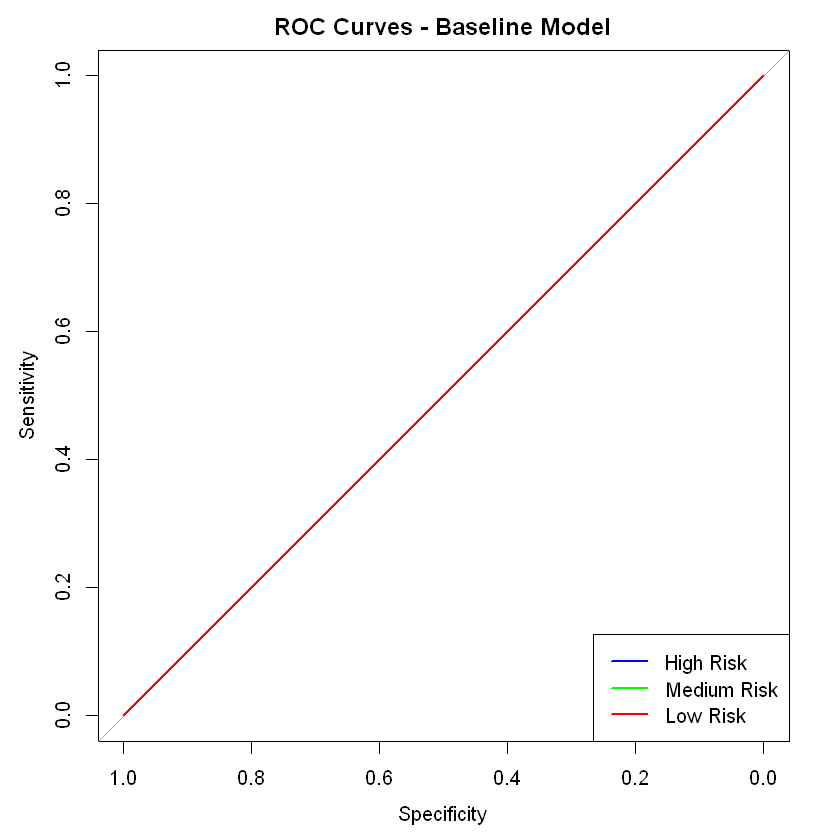

In [119]:
# Plot ROC curves
plot(roc_baseline_high, main = "ROC Curves - Baseline Model", col = "blue", lwd = 2)
plot(roc_baseline_medium, add = TRUE, col = "green", lwd = 2)
plot(roc_baseline_low, add = TRUE, col = "red", lwd = 2)
legend("bottomright", legend = c("High Risk", "Medium Risk", "Low Risk"), 
       col = c("blue", "green", "red"), lwd = 2)


In [120]:

# Optionally, you can display the AUC for each class
cat("AUC for High Risk: ", auc(roc_baseline_high), "\n")
cat("AUC for Medium Risk: ", auc(roc_baseline_medium), "\n")
cat("AUC for Low Risk: ", auc(roc_baseline_low), "\n")

AUC for High Risk:  0.5 
AUC for Medium Risk:  0.5 
AUC for Low Risk:  0.5 


In [121]:
ethicaltree_model <- train(
  risk_level ~ ., 
  data = covid_train_no_id, 
  method = "rpart",  # Replace with your actual model if needed
  trControl = trainControl(method = "cv", number = 10)
)

# Check the model's summary to ensure it's correctly trained
print(ethicaltree_model)

CART 

137 samples
  9 predictor
  3 classes: 'Low', 'Medium', 'High' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 124, 124, 124, 123, 123, 123, ... 
Resampling results across tuning parameters:

  cp    Accuracy  Kappa    
  0.00  1.000000  1.0000000
  0.25  1.000000  1.0000000
  0.50  0.517033  0.2851852

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.25.


In [122]:
# Predict probabilities on the test set
probs_ethicaltree <- predict(ethicaltree_model, newdata = covid_test_no_id, type = "prob")

# Check the structure of the predictions
str(probs_ethicaltree)

'data.frame':	33 obs. of  3 variables:
 $ Low   : num  0 0 0 1 0 1 0 1 0 0 ...
 $ Medium: num  0 1 0 0 1 0 0 0 0 1 ...
 $ High  : num  1 0 1 0 0 0 1 0 1 0 ...


In [123]:
# Create binary outcomes
high_binary <- factor(covid_test_no_id$risk_level == "High", levels = c(FALSE, TRUE))
medium_binary <- factor(covid_test_no_id$risk_level == "Medium", levels = c(FALSE, TRUE))
low_binary <- factor(covid_test_no_id$risk_level == "Low", levels = c(FALSE, TRUE))


In [124]:
roc_ethicaltree_high <- roc(high_binary, probs_ethicaltree[,"High"], quiet = TRUE)
roc_ethicaltree_medium <- roc(medium_binary, probs_ethicaltree[,"Medium"], quiet = TRUE)
roc_ethicaltree_low <- roc(low_binary, probs_ethicaltree[,"Low"], quiet = TRUE)

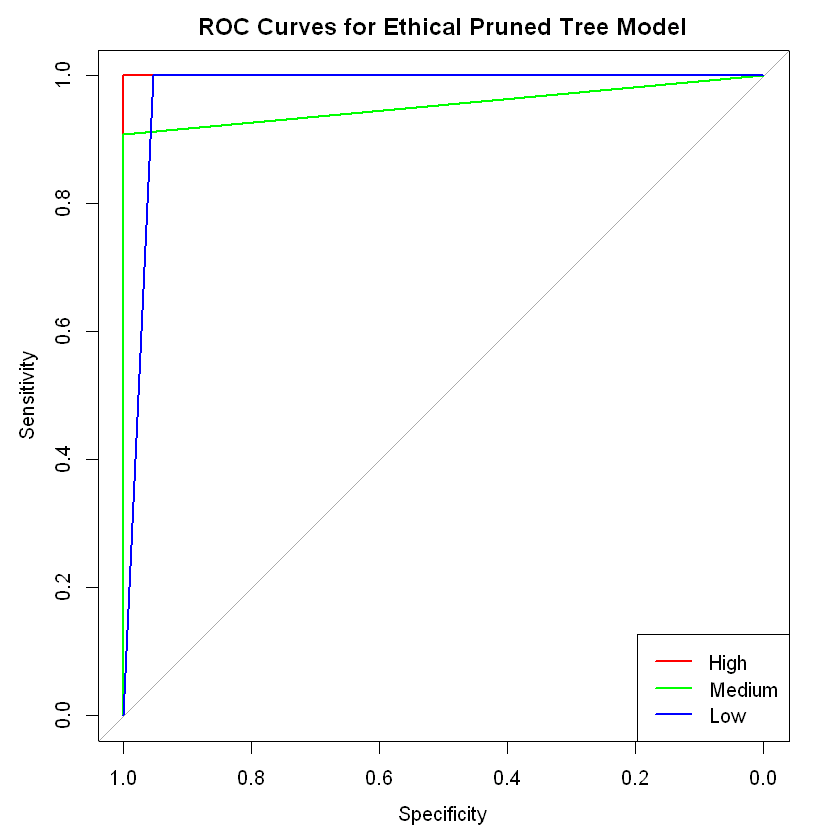

In [125]:
# Plot the ROC curves
plot(roc_ethicaltree_high, col = "red", main = "ROC Curves for Ethical Pruned Tree Model")
plot(roc_ethicaltree_medium, col = "green", add = TRUE)
plot(roc_ethicaltree_low, col = "blue", add = TRUE)
# Add a legend to the plot
legend("bottomright", legend = c("High", "Medium", "Low"), col = c("red", "green", "blue"), lwd = 2)

In [126]:
# Check the formula used for knnFit
knnFit$finalModel$call


NULL

In [127]:
# Check column names in both datasets
colnames(covid_train)
colnames(covid_test)


[1] "cases_per_100k"                     "deaths_per_100k"                   
 [3] "death_per_case"                     "poverty"                           
 [5] "median_income"                      "pct_on_food_stamps"                
 [7] "commuters_by_public_transportation" "pct_work_from_home"                
 [9] "income_per_capita"                  "risk_level"                        
[11] "id"

[1] "cases_per_100k"                     "deaths_per_100k"                   
 [3] "death_per_case"                     "poverty"                           
 [5] "median_income"                      "pct_on_food_stamps"                
 [7] "commuters_by_public_transportation" "pct_work_from_home"                
 [9] "income_per_capita"                  "risk_level"                        
[11] "id"

In [128]:
knnFit <- train(
  risk_level ~ .,
  data = covid_train,
  method = "knn",
  preProcess = "scale",   
  tuneLength = 10,       
  trControl = trainControl(method = "cv")  
)


In [129]:
knn_pred <- predict(knnFit, newdata = covid_test)


In [130]:
summary(knnFit)


            Length Class      Mode     
learn        2     -none-     list     
k            1     -none-     numeric  
theDots      0     -none-     list     
xNames      10     -none-     character
problemType  1     -none-     character
tuneValue    1     data.frame list     
obsLevels    3     -none-     character
param        0     -none-     list     

In [131]:
sum(is.na(covid_train))
sum(is.na(covid_test))


[1] 0

[1] 0

In [132]:
# Make predictions
knn_pred <- predict(knnFit, newdata = covid_test)
knn_train_pred <- predict(knnFit, newdata = covid_train)

# Check accuracy on training data
accuracy(covid_train$risk_level, knn_train_pred)


[1] 0.6715328

In [133]:
# Ensure risk_level is a factor
covid_train$risk_level <- factor(covid_train$risk_level, levels = c("Low", "Medium", "High"))
covid_test$risk_level <- factor(covid_test$risk_level, levels = c("Low", "Medium", "High"))


In [134]:
knnFit <- train(
  risk_level ~ .,
  data = covid_train,
  method = "knn",
  preProcess = "scale",
  tuneLength = 10,
  trControl = trainControl(method = "cv")
)


In [135]:
# kNN - Probability Predictions
probs_knn <- predict(knnFit, newdata = covid_test, type = "prob")


In [136]:
# Create binary outcomes for each class
high_binary <- as.numeric(covid_test$risk_level == "High")
medium_binary <- as.numeric(covid_test$risk_level == "Medium")
low_binary <- as.numeric(covid_test$risk_level == "Low")


In [137]:
# Create ROC curves for each class
roc_knn_high <- roc(high_binary, probs_knn[,"High"], quiet = TRUE)
roc_knn_medium <- roc(medium_binary, probs_knn[,"Medium"], quiet = TRUE)
roc_knn_low <- roc(low_binary, probs_knn[,"Low"], quiet = TRUE)


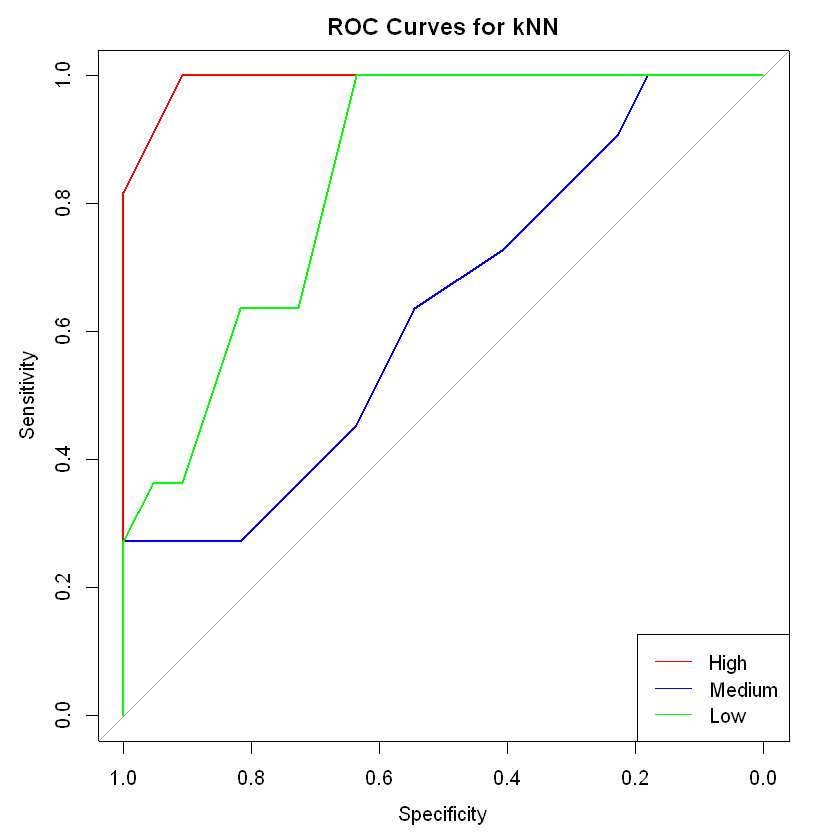

In [138]:
# Plot the ROC curves
plot(roc_knn_high, col = "red", main = "ROC Curves for kNN")
lines(roc_knn_medium, col = "blue")
lines(roc_knn_low, col = "green")
legend("bottomright", legend = c("High", "Medium", "Low"), col = c("red", "blue", "green"), lty = 1)

In [139]:
# Calculate AUC for each class
auc_high <- auc(roc_knn_high)
auc_medium <- auc(roc_knn_medium)
auc_low <- auc(roc_knn_low)


In [140]:
# Print AUC values
cat("AUC for High:", auc_high, "\n")
cat("AUC for Medium:", auc_medium, "\n")
cat("AUC for Low:", auc_low, "\n")

AUC for High: 0.9917355 
AUC for Medium: 0.6322314 
AUC for Low: 0.8450413 


In [141]:
# Ethical Multinomial - Probability Predictions
multi_probs <- predict(multi_logit, newdata = covid_test, type = "prob")

# Create ROC curves
roc_multi_high <- roc(high_binary, multi_probs[,"High"], quiet = TRUE)
roc_multi_medium <- roc(medium_binary, multi_probs[,"Medium"], quiet = TRUE)
roc_multi_low <- roc(low_binary, multi_probs[,"Low"], quiet = TRUE)

In [142]:
# --- Baseline Pruned Tree ---
auc_baseline_high <- auc(roc_baseline_high)
auc_baseline_medium <- auc(roc_baseline_medium)
auc_baseline_low <- auc(roc_baseline_low)

# --- Ethical Pruned Tree ---
auc_ethicaltree_high <- auc(roc_ethicaltree_high)
auc_ethicaltree_medium <- auc(roc_ethicaltree_medium)
auc_ethicaltree_low <- auc(roc_ethicaltree_low)

# --- kNN Model ---
auc_knn_high <- auc(roc_knn_high)
auc_knn_medium <- auc(roc_knn_medium)
auc_knn_low <- auc(roc_knn_low)

# --- Ethical Multinomial Logistic Regression ---
auc_multi_high <- auc(roc_multi_high)
auc_multi_medium <- auc(roc_multi_medium)
auc_multi_low <- auc(roc_multi_low)

In [143]:
# AUC Summary DataFrame
auc_comparison <- data.frame(
  Model = c("Baseline Pruned Tree", "Ethical Pruned Tree", "k-Nearest Neighbors (kNN)", "Ethical Multinomial Logistic Regression"),
  AUC_High = c(auc_baseline_high, auc_ethicaltree_high, auc_knn_high, auc_multi_high),
  AUC_Medium = c(auc_baseline_medium, auc_ethicaltree_medium, auc_knn_medium, auc_multi_medium),
  AUC_Low = c(auc_baseline_low, auc_ethicaltree_low, auc_knn_low, auc_multi_low)
)

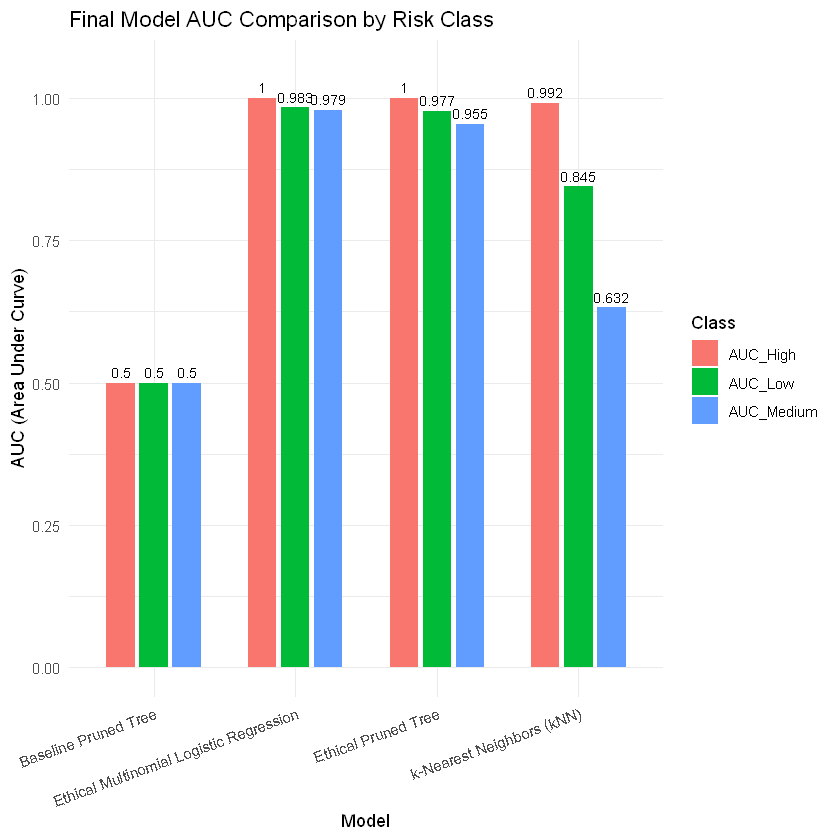

In [144]:
# Reshape data for plotting
library(tidyr)
auc_comparison_long <- pivot_longer(
  auc_comparison,
  cols = c(AUC_High, AUC_Medium, AUC_Low),
  names_to = "Class",
  values_to = "AUC"
)

# Plot AUCs for all models
library(ggplot2)

ggplot(auc_comparison_long, aes(x = Model, y = AUC, fill = Class)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.7), width = 0.6) +
  geom_text(
    aes(label = round(AUC, 3)),
    position = position_dodge(width = 0.7),
    vjust = -0.5,
    size = 3
  ) +
  ylim(0, 1.05) +
  labs(
    title = "Final Model AUC Comparison by Risk Class",
    y = "AUC (Area Under Curve)",
    x = "Model",
    fill = "Class"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 20, hjust = 1))

### 3. Evaluation [5 points]
Discuss how useful your model is for your chosen stakeholders. How would you assess the model's value if
it was used?

### 4. Deployment [5 points]
• How would your model be used in practice? What actions would be taken based on your model? How often would the model be updated? Etc.